In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable # for adding color bars to bar plots, etc. 
from matplotlib import rcParams #for changing the global font size
#from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd 
from scipy import stats
import scipy.constants as sc
import sklearn
from sklearn.linear_model import LinearRegression
import csv
import statsmodels.formula.api as sm
import seaborn as sns
from pathlib import Path #introduced in Python 3.4
import matplotlib.colors as colors
from matplotlib.colors import TwoSlopeNorm

#output the conda environment
#conda env export > thermal_kinetics.yml

The goal of this workbook is to take data generated from kinetics experiments at varying temperatures and calculate 
the transition state thermodynamic properties. 

James McCormick and Kimberly Reynolds 2024. 

This notebook is the companion to Spectra_melt_analysis. 

In [6]:
#change global font settings in plots: 
rcParams['font.family'] = "Arial"
rcParams.update({"axes.grid" : True, "grid.color": "#999999"})
rcParams['lines.markersize'] = 10
rcParams.update({'font.size': 14})

In [14]:
#should we save our output files to pdf?
#change this to 'yes' to save outputs to pdf. 
to_plot = "no"

This function is to import the eyring data that is located in ./input_data/eyring. 
The csv files contain the results of three eyring experiments of kcat measurements at a range of temperatures formatted as ln(kcat/t) vs 1/T
The data is the slope of the first 15 seconds of kinetics (see methods).

In [3]:
def import_data(csv, csv_start,csv_end):
    #load in the eyring information (ln(kcat/t) vs 1/T) as a pandas dataframe
    #dl121_eyring_pd = pd.read_csv("./input_data/eyring/m16p_eyring.csv")
    dl121_eyring_pd = pd.read_csv(csv)
    #pull out the data into a pandas dataframe
    dark_list = []
    df1 = pd.DataFrame({'x': dl121_eyring_pd['Temperature (1/T) (K)'][csv_start:csv_end]\
                            , 'y': dl121_eyring_pd['Dark 1'][csv_start:csv_end]})
    dark_list.append(df1)
    df2 = pd.DataFrame({'x': dl121_eyring_pd['Temperature (1/T) (K)'][csv_start:csv_end]\
                        , 'y': dl121_eyring_pd['Dark 2'][csv_start:csv_end]})
    dark_list.append(df2)
    #dark_df = dark_df.append(df2, ignore_index = True) #append depreciated in pandas
    df3 = pd.DataFrame({'x': dl121_eyring_pd['Temperature (1/T) (K)'][csv_start:csv_end]\
                        , 'y': dl121_eyring_pd['Dark 3'][csv_start:csv_end]})
    dark_list.append(df3)
    dark_df = pd.concat(dark_list)
    #dark_df = dark_df.append(df3, ignore_index = True) #append depreciated in pandas
    #dark_df['x']
    lit_list = []
    ldf1 = pd.DataFrame({'x': dl121_eyring_pd['Temperature (1/T) (K)'][csv_start:csv_end]\
                           , 'y': dl121_eyring_pd['Lit 1'][csv_start:csv_end]})
    lit_list.append(ldf1)
    ldf2 = pd.DataFrame({'x': dl121_eyring_pd['Temperature (1/T) (K)'][csv_start:csv_end]\
                         , 'y': dl121_eyring_pd['Lit 2'][csv_start:csv_end]})
    lit_list.append(ldf2)
    #lit_df = lit_df.append(Ldf2, ignore_index = True) #append depreciated in pandas
    ldf3 = pd.DataFrame({'x': dl121_eyring_pd['Temperature (1/T) (K)'][csv_start:csv_end]\
                         , 'y': dl121_eyring_pd['Lit 3'][csv_start:csv_end]})
    lit_list.append(ldf3)
    lit_df = pd.concat(lit_list)
    #lit_df = lit_df.append(ldf3, ignore_index = True) #append depreciated in pandas
    #lit_df['x']
    return dark_df, lit_df

function to plot the dataframes fed into it. No returns other than printing a plot. 

In [4]:
def classic_plot(dark_df,lit_df,mut,to_plot):  
    #dark_df is the dark pandas dataframe to be plotted. 
    #lit_df is the dark pandas dataframe to be plotted. 
    #mut is the mutant name.
    #to_plot is the variable from above to change if the plot should be written as a pdf. 


    
   ##dark
    ols_model = sm.ols(formula = 'y ~ x', data=dark_df)
    dark_results = ols_model.fit()
    
    # coefficients
    print('Intercept, x-Slope : {}'.format(dark_results.params))
    dark_y_pred = ols_model.fit().predict(dark_df['x'])
    
    # plot results
    plt.scatter(dark_df['x'], dark_df['y'])
    plt.plot(dark_df['x'], dark_y_pred, linewidth=2)
    plt.grid(True)
    plt.xlabel('1/T (K)')
    plt.ylabel('ln(kcat/T)')
    plt.title('Dark %s' % mut)
    plt.show()
    print(dark_results.summary())
    
   ##lit
    ols_model = sm.ols(formula = 'y ~ x', data=lit_df)
    lit_results = ols_model.fit()
    
    # coefficients
    print('Intercept, x-Slope : {}'.format(lit_results.params))
    lit_y_pred = ols_model.fit().predict(lit_df['x'])
    
    # plot results
    plt.scatter(lit_df['x'], lit_df['y'])
    plt.plot(lit_df['x'], lit_y_pred, linewidth=2)
    plt.grid(True)
    plt.xlabel('1/T (K)')
    plt.ylabel('ln($k_{cat}$/T)')
    plt.title('Lit %s' % mut)
    plt.show()
    print(lit_results.summary())

  ##both
    plt.scatter(lit_df['x'], lit_df['y'], c="#0099FF" , edgecolors='black')
    plt.scatter(dark_df['x'], dark_df['y'], c="#999999" , edgecolors='black')
    plt.plot(lit_df['x'], lit_y_pred, linewidth=2, color="#0099FF")
    plt.plot(dark_df['x'], dark_y_pred, linewidth=2, color="#999999")
    plt.grid(True)
    plt.xlabel('1/T (K)')
    plt.ylabel('ln($k_{cat}$/T)')
    title = ('%s' % mut)
    plt.title(title)

    #save the plot out
    if to_plot == 'yes':
        figure_name = ('%s_eyring_scatter.pdf' % mut)
        plt.savefig('./output/eyring_scatter_plots/%s' % figure_name, bbox_inches='tight')
        
    plt.show()
    return

bootstrapping function. Feed in two dataframes of kinetics, and how many iterations of boostrapping to do, and it will return 
the iterations of the slopes and intercepts. 

In [5]:
#bootstrapping for statistics
def bootstrapping(dark_df,lit_df,bootstrapping_number):
    # resample with replacement each row
    #dark
    dark_boot_slopes = []
    dark_boot_interc = []
    n_boots = bootstrapping_number #usually 5000
    for _ in range(n_boots):
        # sample the rows, same size, with replacement
        dark_sample_df = dark_df.sample(n=len(dark_df), replace=True)
        # fit a linear regression
        dark_ols_model_temp = sm.ols(formula = 'y ~ x', data=dark_sample_df)
        dark_results_temp = dark_ols_model_temp.fit()
        
        # append coefficients
        dark_boot_interc.append(dark_results_temp.params[0])
        dark_boot_slopes.append(dark_results_temp.params[1])
        
        # plot a greyed out line
        dark_y_pred_temp = dark_ols_model_temp.fit().predict(dark_sample_df['x'])

    #lit
    lit_boot_slopes = []
    lit_boot_interc = []
    for _ in range(n_boots):
        # sample the rows, same size, with replacement
        lit_sample_df = lit_df.sample(n=len(lit_df), replace=True)
        # fit a linear regression
        lit_ols_model_temp = sm.ols(formula = 'y ~ x', data=lit_sample_df)
        lit_results_temp = lit_ols_model_temp.fit()
        
        # append coefficients
        lit_boot_interc.append(lit_results_temp.params[0])
        lit_boot_slopes.append(lit_results_temp.params[1])
        
        # plot a greyed out line
        lit_y_pred_temp = lit_ols_model_temp.fit().predict(lit_sample_df['x'])
    
    return dark_boot_slopes, dark_boot_interc, lit_boot_slopes, lit_boot_interc

dataframe that takes the dark output of the bootstrapping function and calculates and returns the statistics. 

In [6]:
def boot_statistics_dark(dark_boot_slopes, dark_boot_interc, mut):
    sns.displot(dark_boot_slopes)
    print('dark slopes')
    plt.title('Dark %s slope distribution' % mut)
    plt.show()
    #dark slopes statistics

    dark_slope_mean = np.mean(dark_boot_slopes)
    print("\nMean: ", dark_slope_mean)

    dark_slope_std = np.std(dark_boot_slopes)
    print("\nstd: ", dark_slope_std)

    dark_slope_var = np.var(dark_boot_slopes)
    print("\nvariance: ", dark_slope_var)

    dark_slope_conf_interval = np.percentile(dark_boot_slopes,[2.5,97.5])

    # Print the interval
    print("The 95% confidence interval: ",dark_slope_conf_interval)
    
    #dark intercept statistics 
    sns.displot(dark_boot_interc)
    print('dark intercepts')
    plt.title('Dark %s intercept distribution' % mut)
    plt.show()
    #boot_interc

    dark_interc_mean = np.mean(dark_boot_interc)
    print("\nMean: ", dark_interc_mean)

    dark_interc_std = np.std(dark_boot_interc)
    print("\nstd: ", dark_interc_std)

    dark_interc_var = np.var(dark_boot_interc)
    print("\nvariance: ", dark_interc_var)

    dark_interc_conf_interval = np.percentile(dark_boot_interc,[2.5,97.5])

    # Print the interval
    print("The 95% confidence interval: ",dark_interc_conf_interval)
    
    return dark_slope_mean, dark_slope_std, dark_slope_var, dark_slope_conf_interval, \
    dark_interc_mean, dark_interc_std, dark_interc_var, dark_interc_conf_interval


dataframe that takes the lit output of the bootstrapping function and calculates and returns the statistics.
The code is identical to boot_statistics_dark. 

In [7]:
def boot_statistics_lit(lit_boot_slopes, lit_boot_interc, mut):
    sns.displot(lit_boot_slopes)
    print('lit slopes')
    plt.title('Lit %s slope distribution' % mut)
    plt.show()
    #lit slopes statistics

    lit_slope_mean = np.mean(lit_boot_slopes)
    print("\nMean: ", lit_slope_mean)

    lit_slope_std = np.std(lit_boot_slopes)
    print("\nstd: ", lit_slope_std)

    lit_slope_var = np.var(lit_boot_slopes)
    print("\nvariance: ", lit_slope_var)

    lit_slope_conf_interval = np.percentile(lit_boot_slopes,[2.5,97.5])

    # Print the interval
    print("The 95% confidence interval: ",lit_slope_conf_interval)
    
    #lit intercept statistics 
    sns.displot(lit_boot_interc)
    print('lit intercepts')
    plt.title('Lit %s intercept distribution' % mut)
    plt.show()
    #boot_interc

    lit_interc_mean = np.mean(lit_boot_interc)
    print("\nMean: ", lit_interc_mean)

    lit_interc_std = np.std(lit_boot_interc)
    print("\nstd: ", lit_interc_std)

    lit_interc_var = np.var(lit_boot_interc)
    print("\nvariance: ", lit_interc_var)

    lit_interc_conf_interval = np.percentile(lit_boot_interc,[2.5,97.5])

    # Print the interval
    print("The 95% confidence interval: ",lit_interc_conf_interval)
    
    return lit_slope_mean, lit_slope_std, lit_slope_var, lit_slope_conf_interval, \
    lit_interc_mean, lit_interc_std, lit_interc_var, lit_interc_conf_interval


# Now to propagate into entropy and enthalpy and compare error

In [8]:
def calc_energetics(dark_boot_slopes, dark_boot_interc, lit_boot_slopes, lit_boot_interc,mut):
#dark
    dark_enthalpy_list = []
    dark_entropy_list = []
    for x in dark_boot_slopes: #to get enthalpy 
        #multiply by negative R, in cal/K/mol 
        dark_enthalpy_temp = np.multiply(x,-1.98720425864083)
        #convert to kcal/mol
        dark_enthalpy_kcal = np.multiply(dark_enthalpy_temp, 0.001)
        dark_enthalpy_list.append(dark_enthalpy_kcal)
    for y in dark_boot_interc:
        dark_entropy_temp = np.multiply(y,1.98720425864083) #multiply by R, gas constant. 
        dark_entropy_temp_2 = np.subtract(dark_entropy_temp,47.2163540817713) #subtract R*ln(kb/h)
        dark_entropy_list.append(dark_entropy_temp_2)
    #lit 
    lit_enthalpy_list = []
    lit_entropy_list = []
    for x in lit_boot_slopes: #to get enthalpy 
        #multiply by negative R, in cal/K/mol 
        lit_enthalpy_temp = np.multiply(x,-1.98720425864083)
        #convert to kcal/mol
        lit_enthalpy_kcal = np.multiply(lit_enthalpy_temp, 0.001)
        lit_enthalpy_list.append(lit_enthalpy_kcal)
    for y in lit_boot_interc:
        lit_entropy_temp = np.multiply(y,1.98720425864083) #multiply by R, gas constant. 
        lit_entropy_temp_2 = np.subtract(lit_entropy_temp,47.2163540817713) #subtract R*ln(kb/h)
        lit_entropy_list.append(lit_entropy_temp_2)
    #enthalpy
    print('dark enthalpy')
    dark_enthalpy_mean = np.mean(dark_enthalpy_list)
    print("\nMean: ", dark_enthalpy_mean)

    dark_enthalpy_std = np.std(dark_enthalpy_list)
    print("\nstd: ", dark_enthalpy_std)

    dark_enthalpy_var = np.var(dark_enthalpy_list)
    print("\nvariance: ", dark_enthalpy_var)

    conf_interval = np.percentile(dark_enthalpy_list,[2.5,97.5])

    # Print the interval
    print("The 95% confidence interval: ",conf_interval)
    sns.displot(dark_enthalpy_list)
    plt.title('Dark %s enthalpy distribution' % mut)
    plt.show()

    print('lit enthalpy')
    lit_enthalpy_mean = np.mean(lit_enthalpy_list)
    print("\nMean: ", lit_enthalpy_mean)

    lit_enthalpy_std = np.std(lit_enthalpy_list)
    print("\nstd: ", lit_enthalpy_std)

    lit_enthalpy_var = np.var(lit_enthalpy_list)
    print("\nvariance: ", lit_enthalpy_var)

    conf_interval = np.percentile(lit_enthalpy_list,[2.5,97.5])

    # Print the interval
    print("The 95% confidence interval: ",conf_interval)
    sns.displot(lit_enthalpy_list)
    plt.title('Lit %s Enthalpy distribution' % mut)
    plt.show()

    #are they different?
    statistic,pvalue = stats.ttest_ind(dark_enthalpy_list, lit_enthalpy_list, equal_var=False)
    print("p value that enthalpy are different: ",pvalue)
    #entropy
    print('dark entropy')
    dark_entropy_mean = np.mean(dark_entropy_list)
    print("\nMean: ", dark_entropy_mean)

    dark_entropy_std = np.std(dark_entropy_list)
    print("\nstd: ", dark_entropy_std)

    dark_entropy_var = np.var(dark_entropy_list)
    print("\nvariance: ", dark_entropy_var)

    conf_interval = np.percentile(dark_entropy_list,[2.5,97.5])

    # Print the interval
    print("The 95% confidence interval: ",conf_interval)
    sns.displot(dark_entropy_list)
    plt.title('Dark %s entropy distribution' % mut)
    plt.show()

    print('lit entropy')
    lit_entropy_mean = np.mean(lit_entropy_list)
    print("\nMean: ", lit_entropy_mean)

    lit_entropy_std = np.std(lit_entropy_list)
    print("\nstd: ", lit_entropy_std)

    lit_entropy_var = np.var(lit_entropy_list)
    print("\nvariance: ", lit_entropy_var)

    conf_interval = np.percentile(lit_entropy_list,[2.5,97.5])

    # Print the interval
    print("The 95% confidence interval: ",conf_interval)
    sns.displot(lit_entropy_list)
    plt.title('Dark %s entropy distribution' % mut)
    plt.show()
    #is lit different than dark. 

    #are they different?
    statistic,pvalue = stats.ttest_ind(dark_entropy_list, lit_entropy_list, equal_var=False)
    print("p value that entropy are different: ",pvalue)

    
    return dark_enthalpy_mean, dark_enthalpy_std, dark_entropy_mean, dark_entropy_std,\
    lit_enthalpy_mean, lit_enthalpy_std, lit_entropy_mean, lit_entropy_std,\
    dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list

# To back calculate the kcat at a temperature to check error.
### Getting from entropy and enthalpy to k
 delta G = delta H -(T * delta S)  in joules or calories per mol
 deltaH is enthalpy of activation in kcal/mol or joule
 deltaS is entropy of activation in joule per kelvin
 T is temperature in kelvin
 deltaG is the gibbs energy of activation 
 
 kcat = ((kbT)/h) * e^(-(deltaH/(RT))) * e^(deltaS/R)
 
 R is gas constant 8.31446261815324 joules/K/mol or 1.987204 cal/K/mol (calorie per kelvin per mole. 1 cal = 4.184 joules
 
 kb is the boltzmann/s constant (1.381 x 10^-23 J/K)
 
 h is Planck/s constant (6.62607 x 10^-34 J/Hz) or 1.05457 x 10^-34 Joule second (J times s)

In [9]:
def kcat_back_calculate(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list, n_boots, temp_c,mut):
    kcat_dark = []
    kcat_lit = []
    kcat_ratio = []
    i = 0
    
    #convert C to kelven 
    temperature = np.add(273.0, temp_c)
    
    #multiply temp and botzmann's constant (from scipy.constants)
    kbT = np.multiply(sc.k,temperature)
    
    #divide by planck's constant
    kbTh = np.divide(kbT, sc.h) #nb the joules units cancel out. hashtag sorry, not sorry 
    
    #RT for #e^(-(deltaH/(RT))) #using R in cal/K/mol
    RT = np.multiply(1.987204,temperature)
    
    for i in range(n_boots):
    
        #DARK ZONE
        #need to convert enthalpy from kcal to cal 
        dark_enthalpy_cal = np.multiply(dark_enthalpy_list[i],1000)
        #for the e^(-(deltaH/(RT))) term
        HRT = np.divide(-dark_enthalpy_cal,RT)
        eHRT = np.power(np.e,HRT)
        #multiply the first two sets of terms together ((kbT)/h) * e^(-(deltaH/(RT)))
        kbTheHRT = np.multiply(kbTh,eHRT)
        #for the e^(deltaS/R)
        SR = np.divide(dark_entropy_list[i],1.987204)
        eSR = np.power(np.e,SR)
        kcat_dark_temp = np.multiply(kbTheHRT,eSR)
        kcat_dark.append(kcat_dark_temp)
        
        #LIT ZONE, WATCH OUT, VARIABLE REUSE. 
        
        #need to convert enthalpy from kcal to cal 
        lit_enthalpy_cal = np.multiply(lit_enthalpy_list[i],1000)
        HRT = np.divide(-lit_enthalpy_cal,RT)
        eHRT = np.power(np.e,HRT)
        #multiply the first two sets of terms together ((kbT)/h) * e^(-(deltaH/(RT)))
        kbTheHRT = np.multiply(kbTh,eHRT)
        #for the e^(deltaS/R)
        SR = np.divide(lit_entropy_list[i],1.987204)
        eSR = np.power(np.e,SR)
        kcat_lit_temp = np.multiply(kbTheHRT,eSR)
        kcat_lit.append(kcat_lit_temp)

        #do kcat lit divided by kcat dark

        kcat_ratio_temp = np.divide(kcat_lit_temp,kcat_dark_temp)
        kcat_ratio.append(kcat_ratio_temp)
        
    #compute the stats
    #dark Kcat
    print('kcat_dark')
    kcat_dark_mean = np.mean(kcat_dark)
    print("\nkcat_dark_mean: ", kcat_dark_mean)
      
    kcat_dark_std = np.std(kcat_dark)
    print("\nstd: ", kcat_dark_std)
      
    r3 = np.var(kcat_dark)
    print("\nvariance: ", r3)
    
    conf_interval = np.percentile(kcat_dark,[2.5,97.5])
    
    # Print the interval
    print("The 95% confidence interval: ",conf_interval)
    sns.displot(kcat_dark)
    plt.title('Dark %s $k_{cat}$ distribution' % mut)
    plt.show()
    
    #lit Kcat
    print('Kcat_lit')
    kcat_lit_mean = np.mean(kcat_lit)
    print("\nkcat lit mean: ", kcat_lit_mean)
      
    kcat_lit_std = np.std(kcat_lit)
    print("\nstd: ", kcat_lit_std)
      
    r3 = np.var(kcat_lit)
    print("\nvariance: ", r3)
    
    conf_interval = np.percentile(kcat_lit,[2.5,97.5])
    
    # Print the interval
    print("The 95% confidence interval: ",conf_interval)
    sns.displot(kcat_lit)
    plt.title('Lit %s $k_{cat}$ distribution' % mut)
    plt.show()

    #ratio
    kcat_ratio_mean = np.mean(kcat_ratio)
    kcat_ratio_std = np.std(kcat_ratio)
    

    return kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std

this function calculates the gibbs free energy from the enthalpy and entropy in the ligth and dark. 
It calculates error by performing the calculations on the entire set of iterations passed to it (n_boots). 

In [10]:
#calculate delta G
def delta_g_calculator(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                       n_boots, temp_c, mut ,mute):
    dG_dark = []
    dG_lit = []
    ddelta_G = []
    i = 0
    
    #convert C to kelven 
    temperature = np.add(273.0, temp_c)
    
    
    for i in range(n_boots):
    
        #DARK ZONE
        #need to convert enthalpy from kcal to cal 
        dark_enthalpy_cal = np.multiply(dark_enthalpy_list[i],1000)
        ST = np.multiply(dark_entropy_list[i],temperature)
        dG_dark_temp = np.subtract(dark_enthalpy_cal,ST)
        dG_dark.append(dG_dark_temp)
        
        #LIT ZONE. 
        
        #need to convert enthalpy from kcal to cal 
        lit_enthalpy_cal = np.multiply(lit_enthalpy_list[i],1000)
        ST = np.multiply(lit_entropy_list[i],temperature)
        dG_lit_temp = np.subtract(lit_enthalpy_cal,ST)
        dG_lit.append(dG_lit_temp)
        
        #take delta G to get allosteric effect of the mutant. 
    
        temp_ddelta_G = np.subtract(dG_lit[i],dG_dark[i])
        ddelta_G.append(temp_ddelta_G)
        
    #compute the stats
    #dark deltaG G dark')
    
    dG_dark_mean = np.mean(dG_dark)      
    dG_dark_std = np.std(dG_dark)
    r3 = np.var(dG_dark)
    
    conf_interval = np.percentile(dG_dark,[2.5,97.5])
    
    if mute == 'no_mute':    
        print('delta G dark')
        print("\nMean: ", dG_dark_mean)
        print("\nstd: ", dG_dark_std)
        print("\nvariance: ", r3)  
    # Print the interval
        print("The 95% confidence interval: ",conf_interval)
        sns.displot(dG_dark)
        plt.title('Dark %s dG distribution' % mut)
        plt.show()
    
    #lit deltaG

    dG_lit_mean = np.mean(dG_lit)
    dG_lit_std = np.std(dG_lit)
    r3 = np.var(dG_lit)
    conf_interval = np.percentile(dG_lit,[2.5,97.5])
    
    if mute == 'no_mute':    
        print('delta G lit')
        print("\nMean: ", dG_lit_mean)
        print("\nstd: ", dG_lit_std)
        print("\nvariance: ", r3)    
    # Print the interval
        print("The 95% confidence interval: ",conf_interval)
        sns.displot(dG_lit)
        plt.title('Lit %s dG distribution' % mut)
        plt.show()
    
    #delta deltaG
    
    ddelta_G_mean = np.mean(ddelta_G)
    ddelta_G_std = np.std(ddelta_G)
    r3 = np.var(ddelta_G)
    conf_interval = np.percentile(ddelta_G,[2.5,97.5])
    
    if mute == 'no_mute':    
        print('delta G lit - delta G dark (DeltaDeltaG)')
        print("\nMean: ", ddelta_G_mean)
        print("\nstd: ", ddelta_G_std)
        print("\nvariance: ", r3)
    # Print the interval
        print("The 95% confidence interval: ",conf_interval)
        sns.displot(ddelta_G)
        plt.title(' %s delta delta G distribution' % mut)
        plt.show()

    return dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std,\
    ddelta_G_mean, ddelta_G_std

plotting function for delta G values. 

In [11]:
#function to make plots of the delta G values. 
def delta_g_plotter(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                    n_boots,mut,to_plot):
    #make the lists
    dG_dark_mean_list = []
    dG_dark_std_list = []
    dG_lit_mean_list = []
    dG_lit_std_list = []
    ddelta_G_mean_list = []
    ddelta_G_std_list = []
    temperature_list = []

    #loop through the range of temperatures, 5 through 40C
    for i in range(4,95):
        temp_c = np.add(i,1)

        #cycle through the delta g calculations for each temperature
        dG_dark_mean_temp, dG_dark_std_temp, dG_lit_mean_temp, dG_lit_std_temp, ddelta_G_mean_temp, ddelta_G_std_temp \
        = delta_g_calculator(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                             n_boots, temp_c, mut,"mute")
        
        dG_dark_mean_list.append(dG_dark_mean_temp)
        dG_dark_std_list.append(dG_dark_std_temp)
        dG_lit_mean_list.append(dG_lit_mean_temp)
        dG_lit_std_list.append(dG_lit_std_temp)
        ddelta_G_mean_list.append(ddelta_G_mean_temp)
        ddelta_G_std_list.append(ddelta_G_std_temp)
        temperature_list.append(temp_c)
#least squares on dark delta G
    data_set_dark = pd.DataFrame(
        {'x': np.array(temperature_list, dtype=int),
         'y': np.array(dG_dark_mean_list, dtype=int)
        })
    ols_model = sm.ols(formula = 'y ~ x', data=data_set_dark)
    fit_results_dark = ols_model.fit()
    print('Intercept, x-Slope : {}'.format(fit_results_dark.params))
    fit_y_pred_dark = ols_model.fit().predict(data_set_dark['x'])

#least squares on lit delta G
    data_set_lit = pd.DataFrame(
        {'x': np.array(temperature_list, dtype=int),
         'y': np.array(dG_lit_mean_list, dtype=int)
        })
    ols_model = sm.ols(formula = 'y ~ x', data=data_set_lit)
    fit_results_lit = ols_model.fit()
    x_intercept_lit, slope_lit = fit_results_lit.params
    print('Intercept, x-Slope : {}'.format(fit_results_lit.params))
    fit_y_pred_lit = ols_model.fit().predict(data_set_lit['x'])
    
###fit linear model for delta delta G
    data_set = pd.DataFrame(
        {'x': np.array(temperature_list, dtype=int),
         'y': np.array(ddelta_G_mean_list, dtype=int)
        })
    ols_model = sm.ols(formula = 'y ~ x', data=data_set)
    fit_results = ols_model.fit()
    fit_y_pred = ols_model.fit().predict(data_set['x'])

    #get y intercept for delta delta G
    x_intercept_ddg, slope_ddg = fit_results.params
    y_intercept_ddg = np.divide(np.multiply(x_intercept_ddg, -1),slope_ddg)


###compute line of intersection of dark and lit
    intersect = np.add(np.multiply(y_intercept_ddg, slope_lit), x_intercept_lit)

    
###Plot lit and dark delta G.    
    plt.plot(temperature_list, fit_y_pred_dark, linewidth=2, color="#999999")
    plt.plot(temperature_list, fit_y_pred_lit, linewidth=2, color="#0099FF")

    plt.plot([y_intercept_ddg,y_intercept_ddg], [x_intercept_lit,intersect], linewidth=2, color="#999999", ls=":")
    plt.plot([0,y_intercept_ddg], [intersect,intersect], linewidth=2, color="#999999", ls=":")
    plt.text(0, intersect+0.25, ('Intersect is: %.2f' % intersect))
    plt.text(y_intercept_ddg+0.25, x_intercept_lit, ('Intercept is: %.2f' % y_intercept_ddg), rotation=90)
    #plt.scatter(temperature_list, dG_lit_mean_list, c="#0099FF" , edgecolors='black')
    #plt.scatter(temperature_list, dG_dark_mean_list, c="#999999" , edgecolors='black')
    #plt.plot(lit_df['x'], lit_y_pred, linewidth=2, color="#0099FF")
    #plt.plot(dark_df['x'], dark_y_pred, linewidth=2, color="#999999")
    plt.grid(True)
    plt.xlabel('Temperature (C)')
    plt.ylabel('delta G')
    title = ('%s' % mut)
    plt.title(title)

    #save the plot out
    if to_plot == 'yes':
        figure_name = ('%s_deltaG_vs_temp.pdf' % mut)
        plt.savefig('./output/eyring_scatter_plots/%s' % figure_name, bbox_inches='tight')
        
    plt.show()

###plot delta delta G

    print('Intercept, x-Slope: \n {}'.format(fit_results.params))
    print('Y Intercept is: %.2f' % y_intercept_ddg)
    
    #plt.scatter(temperature_list, ddelta_G_mean_list, c="#0099FF" , edgecolors='black')
    plt.plot(temperature_list, fit_y_pred, linewidth=2, color="#0099FF")
    plt.plot([y_intercept_ddg,y_intercept_ddg], [x_intercept_ddg,0], linewidth=2, color="#999999", ls=":")
    plt.plot([0,y_intercept_ddg], [0,0], linewidth=2, color="#999999", ls=":")
    plt.text(0, 0+0.25, ('Intercept is: %.2f' % y_intercept_ddg))
    plt.grid(True)
    plt.xlabel('Temperature (C)')
    plt.ylabel('delta delta G')
    title = ('%s' % mut)
    plt.title(title)

    #save the plot out
    if to_plot == 'yes':
        figure_name = ('%s_delta_deltaG_vs_temp.pdf' % mut)
        plt.savefig('./output/eyring_scatter_plots/%s' % figure_name, bbox_inches='tight')
        
    plt.show()
    
    return intersect, y_intercept_ddg

calculates the allosteric effect of enthalpy and entropy in relation to the wild type DL121. 

In [12]:
#calculate ddelta S and H
def delta_SH_calculator(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                       n_boots, temp_c, mut ,mute, \
                       dark_enthalpy_list_DL121, dark_entropy_list_DL121, lit_enthalpy_list_DL121, lit_entropy_list_DL121):
    delta_entropy = []
    delta_enthalpy = []
    ddelta_entropy = []
    ddelta_enthalpy = []
    
    i = 0
    
    #convert C to kelven 
    temperature = np.add(273.0, temp_c)
     
    for i in range(n_boots):
    
        #take delta S to get allosteric effect of the mutant. 
        #lit minus dark entropy for mutant
        temp_delta_entropy = np.subtract(lit_entropy_list[i],dark_entropy_list[i])
        #multiply by temperature to get cal/mol from cal/mol*Kelvin
        temp_delta_entropy = np.multiply(temp_delta_entropy, temperature)
    
        delta_entropy.append(temp_delta_entropy)

        #compute mutant lit-dark entropy normalized to DL121
        temp_delta_entropy_DL121 = np.subtract(lit_entropy_list_DL121[i],dark_entropy_list_DL121[i])
        temp_delta_entropy_DL121 = np.multiply(temp_delta_entropy_DL121, temperature)
        temp_ddelta_entropy = np.subtract(temp_delta_entropy,temp_delta_entropy_DL121)

        ddelta_entropy.append(temp_ddelta_entropy)
        
        #compute mutant lit-dark enthalpy 

        temp_delta_enthalpy = np.subtract(lit_enthalpy_list[i],dark_enthalpy_list[i])
        #multiply by tmperature to get cal/mol from kcal/mol
        temp_delta_enthalpy = np.multiply(temp_delta_enthalpy, 1000)
        
        delta_enthalpy.append(temp_delta_enthalpy)

        #compute mutant lit-dark enthalpy normalized to DL121
        temp_delta_enthalpy_DL121 = np.subtract(lit_enthalpy_list_DL121[i],dark_enthalpy_list_DL121[i])
        temp_delta_enthalpy_DL121 = np.multiply(temp_delta_enthalpy_DL121, 1000)
        temp_ddelta_enthalpy = np.subtract(temp_delta_enthalpy,temp_delta_enthalpy_DL121)

        ddelta_enthalpy.append(temp_ddelta_enthalpy)

    #compute the stats
    delta_entropy_mean = np.mean(delta_entropy)
    delta_entropy_std = np.std (delta_entropy)

    delta_enthalpy_mean = np.mean(delta_enthalpy)
    delta_enthalpy_std = np.std (delta_enthalpy)

    ddelta_entropy_mean = np.mean(ddelta_entropy)
    ddelta_entropy_std = np.std (ddelta_entropy)

    ddelta_enthalpy_mean = np.mean(ddelta_enthalpy)
    ddelta_enthalpy_std = np.std (ddelta_enthalpy)


    return delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std,\
    ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std

calculates the allosteric effect of enthalpy and entropy in relation to the wild type DL121.
This function is for DL121 as the delta_SH_calculator needs the values for DL121 entropy and enthalpy as inputs.
This function does not. 

In [13]:
#calculate ddelta S and H
def delta_SH_calculator_DL121(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                       n_boots, temp_c, mut ,mute):
    delta_entropy = []
    delta_enthalpy = []
    ddelta_entropy = []
    ddelta_enthalpy = []
    
    i = 0
    
    #convert C to kelven 
    temperature = np.add(273.0, temp_c)
     
    for i in range(n_boots):
    
        #take delta S to get allosteric effect of the mutant. 
        #lit minus dark entropy for mutant
        temp_delta_entropy = np.subtract(lit_entropy_list[i],dark_entropy_list[i])
        #multiply by temperature to get cal/mol from cal/mol*Kelvin
        temp_delta_entropy = np.multiply(temp_delta_entropy, temperature)
    
        delta_entropy.append(temp_delta_entropy)

        #compute mutant lit-dark entropy normalized to DL121
        temp_delta_entropy_DL121 = np.subtract(lit_entropy_list[i],dark_entropy_list[i])
        temp_delta_entropy_DL121 = np.multiply(temp_delta_entropy_DL121, temperature)
        temp_ddelta_entropy = np.subtract(temp_delta_entropy,temp_delta_entropy_DL121)

        ddelta_entropy.append(temp_ddelta_entropy)
        
        #compute mutant lit-dark enthalpy 

        temp_delta_enthalpy = np.subtract(lit_enthalpy_list[i],dark_enthalpy_list[i])
        #multiply by tmperature to get cal/mol from kcal/mol
        temp_delta_enthalpy = np.multiply(temp_delta_enthalpy, 1000)
        
        delta_enthalpy.append(temp_delta_enthalpy)

        #compute mutant lit-dark enthalpy normalized to DL121
        temp_delta_enthalpy_DL121 = np.subtract(lit_enthalpy_list[i],dark_enthalpy_list[i])
        temp_delta_enthalpy_DL121 = np.multiply(temp_delta_enthalpy_DL121, 1000)
        temp_ddelta_enthalpy = np.subtract(temp_delta_enthalpy,temp_delta_enthalpy_DL121)

        ddelta_enthalpy.append(temp_ddelta_enthalpy)

    #compute the stats
    delta_entropy_mean = np.mean(delta_entropy)
    delta_entropy_std = np.std (delta_entropy)

    delta_enthalpy_mean = np.mean(delta_enthalpy)
    delta_enthalpy_std = np.std (delta_enthalpy)

    ddelta_entropy_mean = np.mean(ddelta_entropy)
    ddelta_entropy_std = np.std (ddelta_entropy)

    ddelta_enthalpy_mean = np.mean(ddelta_enthalpy)
    ddelta_enthalpy_std = np.std (ddelta_enthalpy)


    return delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std,\
    ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std

This function calls all the above functions with file path  locations, temperature, and bootstrapping as inputs. 
It returns all the energetics paramaters and their statistics for DL121
This is done so that the DL121 values can be fed into the lower enthalpy_entropy_looper.
Which need the values of DL121 as an input to calculate normalized values. 

In [14]:
#function for calculating enthalpy and entropy with error from bootstrapping specific to DL121.
#this is done so that the DL121 values can be fed into the lower enthalpy_entropy_looper \
#which need the values of DL121 as an input to calculate normalized values. 
def enthalpy_entropy_looper_DL121(csv_path,bootstrap_number,csv_start,csv_end,temp_c,mut,to_plot):
  #this section runs all the above functions. "A function of functions"
    dark_df, lit_df = import_data(csv_path,csv_start,csv_end)

    classic_plot(dark_df,lit_df,mut,to_plot)
    
    dark_boot_slopes, dark_boot_interc, lit_boot_slopes, lit_boot_interc \
    = bootstrapping(dark_df,lit_df,bootstrap_number)

    
    dark_slope_mean, dark_slope_std, dark_slope_var, dark_slope_conf_interval,\
    dark_interc_mean, dark_interc_std, dark_interc_var, dark_interc_conf_interval\
    = boot_statistics_dark(dark_boot_slopes, dark_boot_interc,mut)

    
    lit_slope_mean, lit_slope_std, lit_slope_var, lit_slope_conf_interval,\
    lit_interc_mean, lit_interc_std, lit_interc_var, lit_interc_conf_interval\
    = boot_statistics_lit(lit_boot_slopes, lit_boot_interc,mut)


    dark_enthalpy_mean, dark_enthalpy_std, dark_entropy_mean, dark_entropy_std,\
    lit_enthalpy_mean, lit_enthalpy_std, lit_entropy_mean, lit_entropy_std, \
    dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list \
    = calc_energetics(dark_boot_slopes, dark_boot_interc, lit_boot_slopes, lit_boot_interc,mut)

    
    kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std \
    = kcat_back_calculate(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list, bootstrap_number, temp_c, mut)

    
    dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std, ddelta_G_mean, ddelta_G_std \
    = delta_g_calculator(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                         bootstrap_number, temp_c, mut,"no_mute")
    calculated_intersect, calculated_intercept \
    = delta_g_plotter(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                    bootstrap_number,mut,to_plot)
    
    delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std,\
    ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std \
    = delta_SH_calculator_DL121(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                         bootstrap_number, temp_c, mut,"no_mute")
    
    return dark_enthalpy_mean, dark_enthalpy_std, dark_entropy_mean, dark_entropy_std,\
    lit_enthalpy_mean, lit_enthalpy_std, lit_entropy_mean, lit_entropy_std, \
    kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std, \
    dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std, ddelta_G_mean, ddelta_G_std, \
    calculated_intersect, calculated_intercept, \
    delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std,\
    ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std, \
    dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list

This function calls all the above functions with file path  locations, temperature, DL121 energetic values, and bootstrapping as inputs. 
It returns all the energetics paramaters and their statistics. 

In [15]:
#function for calculating enthalpy and entropy with error from bootstrapping
def enthalpy_entropy_looper(csv_path,bootstrap_number,csv_start,csv_end,temp_c,mut,to_plot, \
                           dark_enthalpy_list_DL121, dark_entropy_list_DL121, lit_enthalpy_list_DL121, lit_entropy_list_DL121):
  #this section runs all the above functions. "A function of functions"
    dark_df, lit_df = import_data(csv_path,csv_start,csv_end)

    classic_plot(dark_df,lit_df,mut,to_plot)
    
    dark_boot_slopes, dark_boot_interc, lit_boot_slopes, lit_boot_interc \
    = bootstrapping(dark_df,lit_df,bootstrap_number)

    
    dark_slope_mean, dark_slope_std, dark_slope_var, dark_slope_conf_interval,\
    dark_interc_mean, dark_interc_std, dark_interc_var, dark_interc_conf_interval\
    = boot_statistics_dark(dark_boot_slopes, dark_boot_interc,mut)

    
    lit_slope_mean, lit_slope_std, lit_slope_var, lit_slope_conf_interval,\
    lit_interc_mean, lit_interc_std, lit_interc_var, lit_interc_conf_interval\
    = boot_statistics_lit(lit_boot_slopes, lit_boot_interc,mut)


    dark_enthalpy_mean, dark_enthalpy_std, dark_entropy_mean, dark_entropy_std,\
    lit_enthalpy_mean, lit_enthalpy_std, lit_entropy_mean, lit_entropy_std, \
    dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list \
    = calc_energetics(dark_boot_slopes, dark_boot_interc, lit_boot_slopes, lit_boot_interc,mut)

    
    kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std \
    = kcat_back_calculate(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list, bootstrap_number, temp_c, mut)

    
    dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std, ddelta_G_mean, ddelta_G_std \
    = delta_g_calculator(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                         bootstrap_number, temp_c, mut,"no_mute")
    calculated_intersect, calculated_intercept \
    = delta_g_plotter(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                    bootstrap_number,mut,to_plot)

    delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std,\
    ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std \
    = delta_SH_calculator(dark_enthalpy_list, dark_entropy_list, lit_enthalpy_list, lit_entropy_list,\
                         bootstrap_number, temp_c, mut,"no_mute", \
                         dark_enthalpy_list_DL121, dark_entropy_list_DL121, lit_enthalpy_list_DL121, lit_entropy_list_DL121)
    
    return dark_enthalpy_mean, dark_enthalpy_std, dark_entropy_mean, dark_entropy_std,\
    lit_enthalpy_mean, lit_enthalpy_std, lit_entropy_mean, lit_entropy_std, \
    kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std, \
    dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std, ddelta_G_mean, ddelta_G_std, \
    calculated_intersect, calculated_intercept, \
    delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std,\
    ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std

This section runs the functions for each proten, plots them, calls the energetics calculations, and saves them into a 
pandas dataframe named energetics_df_all. This is done for kinetics measurments between 5 and 35C with 5000 iterations of boostrapping.
The fairly large iterations of bootstrapping results in this cell taking about 15 minutes to run. 

######################## DL121 ########################
Intercept, x-Slope : Intercept      15.022502
x           -6347.365566
dtype: float64


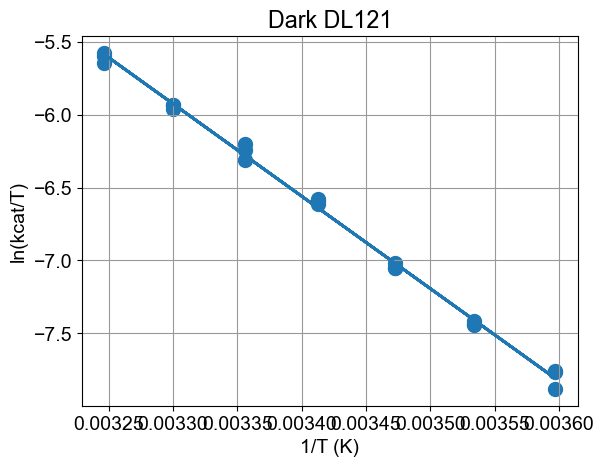

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     6230.
Date:                Wed, 08 May 2024   Prob (F-statistic):           2.21e-25
Time:                        17:42:54   Log-Likelihood:                 37.315
No. Observations:                  21   AIC:                            -70.63
Df Residuals:                      19   BIC:                            -68.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.0225      0.275     54.639      0.0

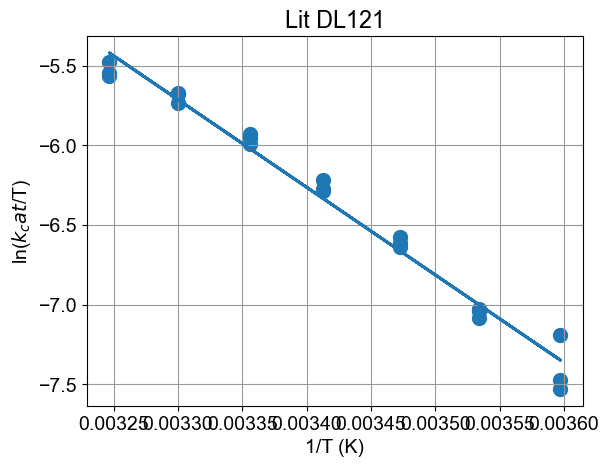

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     960.5
Date:                Wed, 08 May 2024   Prob (F-statistic):           9.87e-18
Time:                        17:42:55   Log-Likelihood:                 20.691
No. Observations:                  21   AIC:                            -37.38
Df Residuals:                      19   BIC:                            -35.29
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.4382      0.607     20.498      0.0

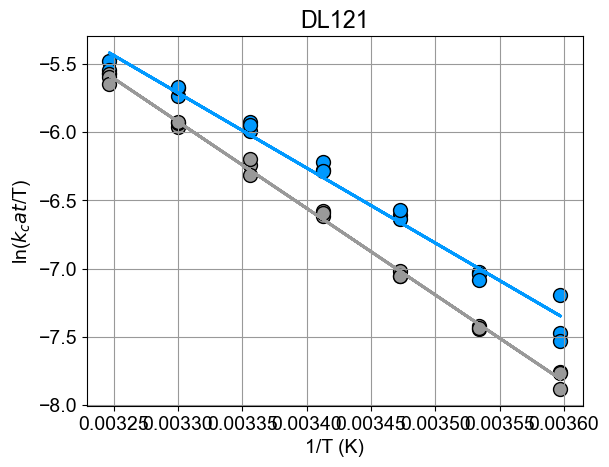

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


dark slopes


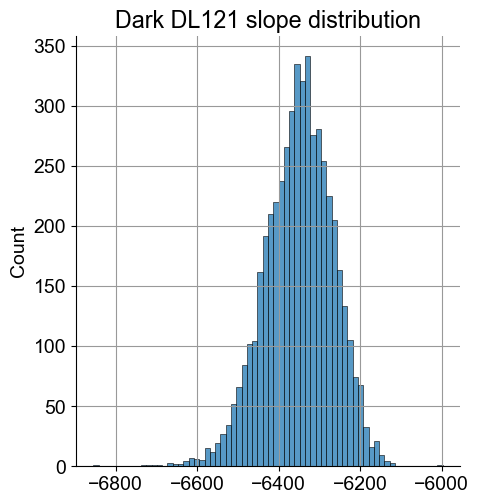


Mean:  -6351.124653673922

std:  83.56980250612627

variance:  6983.9118909129475
The 95% confidence interval:  [-6522.57705941 -6200.20041042]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


dark intercepts


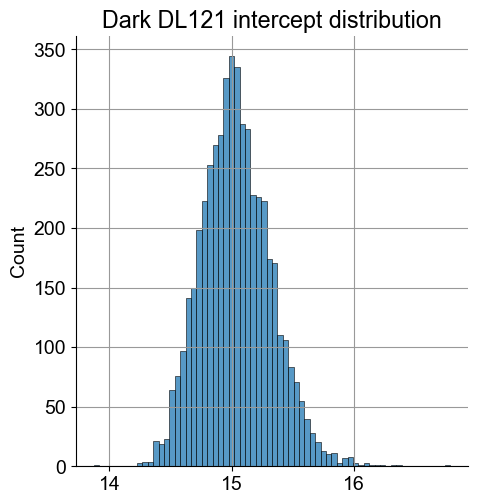


Mean:  15.035960227468173

std:  0.2847420231394791

variance:  0.08107801974156364
The 95% confidence interval:  [14.52589743 15.62532762]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


lit slopes


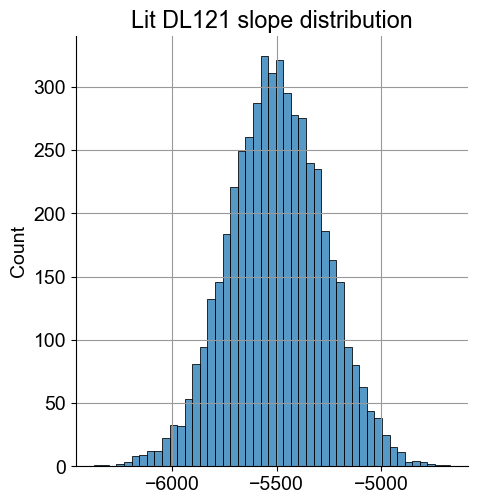


Mean:  -5500.65979829192

std:  228.86246478809105

variance:  52378.02778888021
The 95% confidence interval:  [-5949.46457742 -5048.05550772]
lit intercepts


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


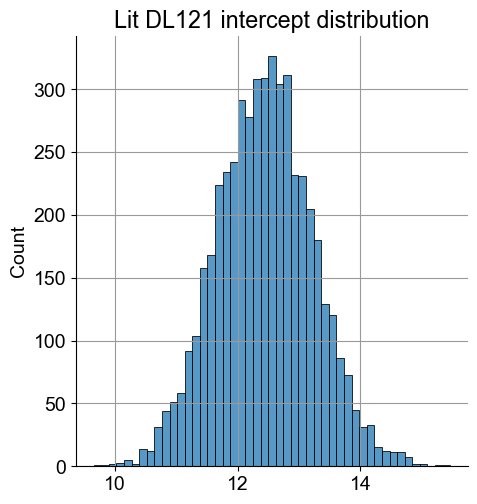


Mean:  12.441971012527173

std:  0.7774623031141662

variance:  0.6044476327635836
The 95% confidence interval:  [10.92702506 13.9846484 ]
dark enthalpy

Mean:  12.620981958939584

std:  0.16607026743394723

variance:  0.02757933372558275
The 95% confidence interval:  [12.32106466 12.96169291]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


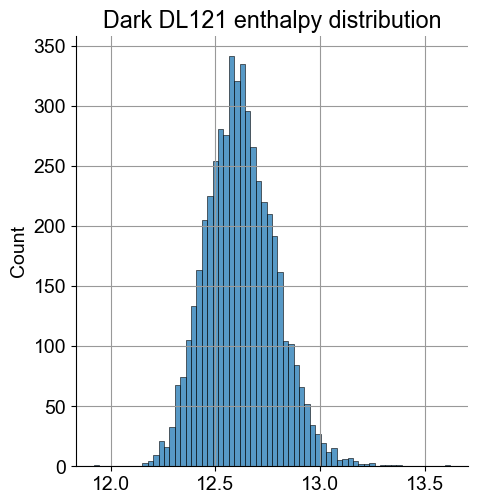

lit enthalpy

Mean:  10.930934576500114

std:  0.4547964646699315

variance:  0.20683982427626824
The 95% confidence interval:  [10.0315174  11.82280134]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


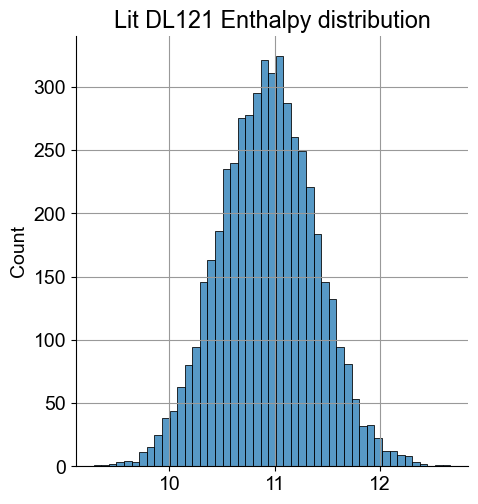

p value that enthalpy are different:  0.0
dark entropy

Mean:  -17.336829884992397

std:  0.5658405609967786

variance:  0.32017554046914914
The 95% confidence interval:  [-18.35042884 -16.16563648]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


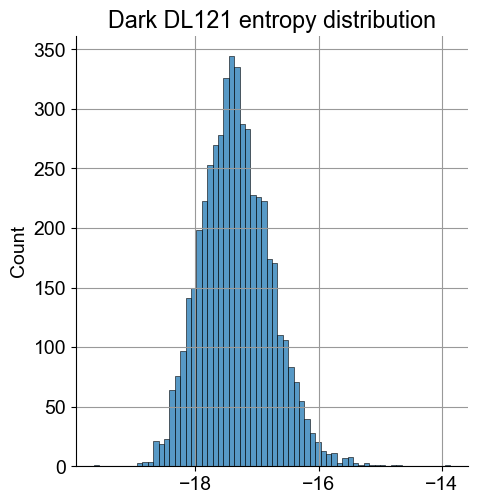

lit entropy

Mean:  -22.49161629979154

std:  1.544976399681179

variance:  2.3869520755718177
The 95% confidence interval:  [-25.50212335 -19.42600122]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


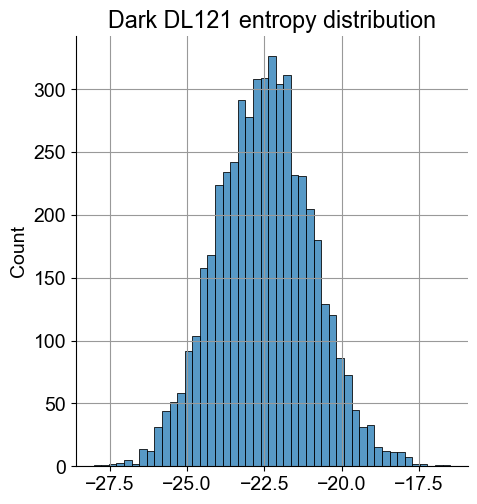

p value that entropy are different:  0.0
kcat_dark

kcat_dark_mean:  0.3149494724524579

std:  0.0030364015944634973

variance:  9.219734642860469e-06
The 95% confidence interval:  [0.30914412 0.32095569]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


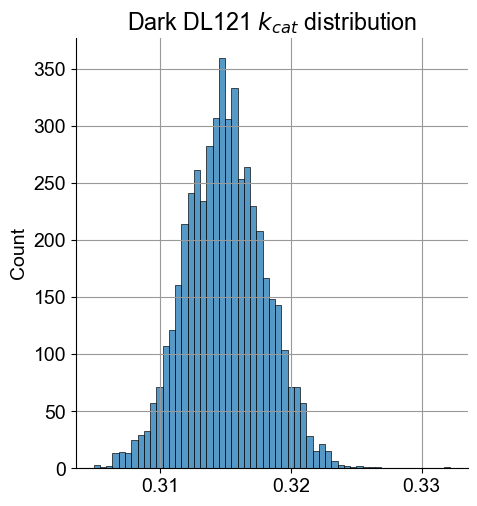

Kcat_lit

kcat lit mean:  0.43975590411351206

std:  0.009913631750296673

variance:  9.828009448049027e-05
The 95% confidence interval:  [0.42130264 0.46103838]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


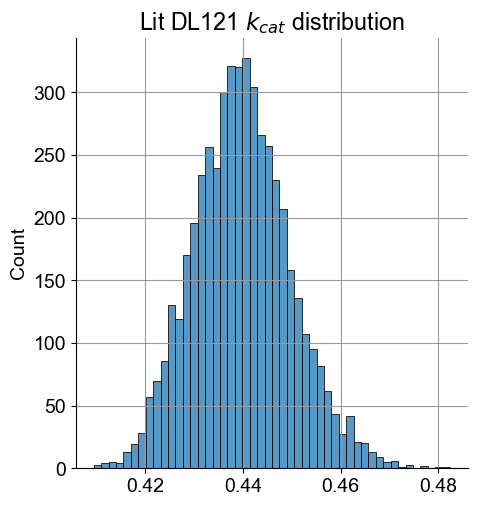

delta G dark

Mean:  17657.331040529876

std:  5.563670875261402

variance:  30.954433608231973
The 95% confidence interval:  [17646.39885622 17668.04437067]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


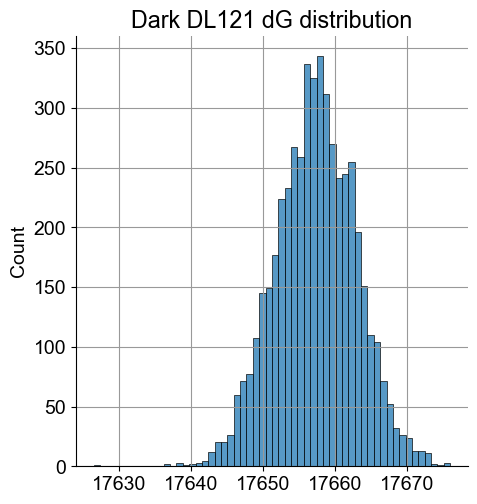

delta G lit

Mean:  17464.749111589557

std:  12.985799159219368

variance:  168.63097980358248
The 95% confidence interval:  [17437.31961909 17489.35002888]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


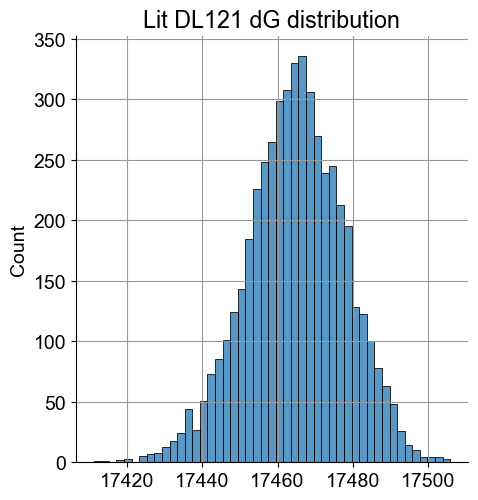

delta G lit - delta G dark (DeltaDeltaG)

Mean:  -192.58192894031956

std:  14.051545990857374

variance:  197.44594473317994
The 95% confidence interval:  [-221.3100338  -165.91734214]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


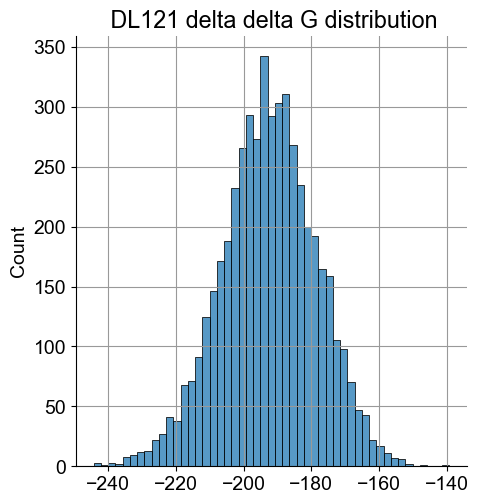

Intercept, x-Slope : Intercept    17353.460742
x               17.336280
dtype: float64
Intercept, x-Slope : Intercept    17070.671285
x               22.490970
dtype: float64


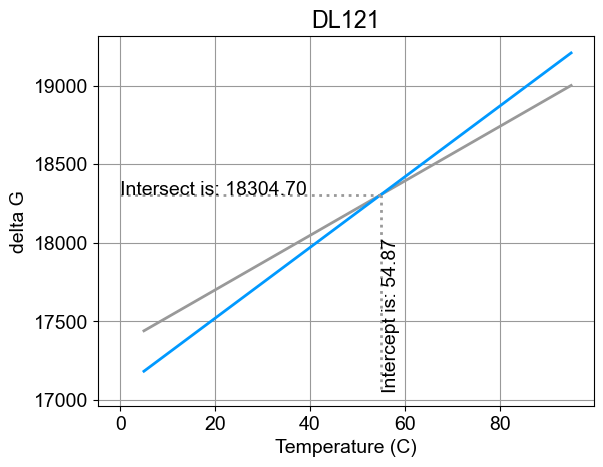

Intercept, x-Slope: 
 Intercept   -281.909380
x              5.137968
dtype: float64
Y Intercept is: 54.87


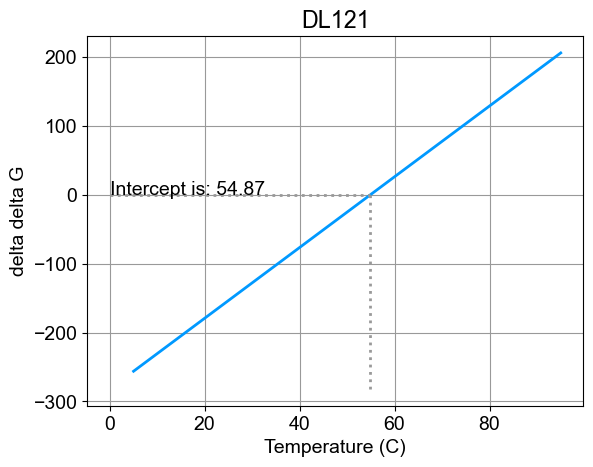

######################## A9N ########################
Intercept, x-Slope : Intercept      11.739937
x           -5271.220282
dtype: float64


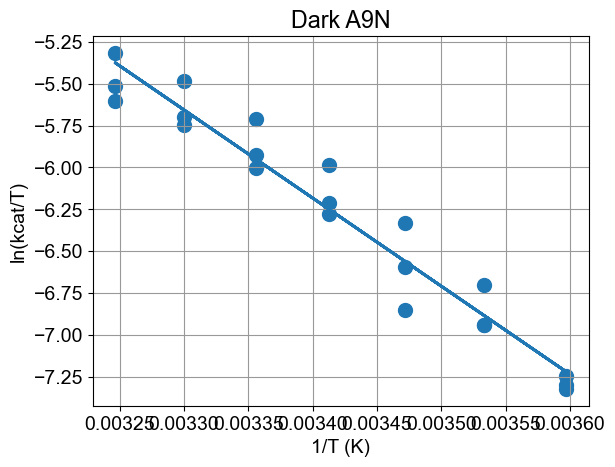

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     341.1
Date:                Wed, 08 May 2024   Prob (F-statistic):           1.35e-13
Time:                        17:46:57   Log-Likelihood:                 10.713
No. Observations:                  21   AIC:                            -17.43
Df Residuals:                      19   BIC:                            -15.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.7399      0.976     12.031      0.0

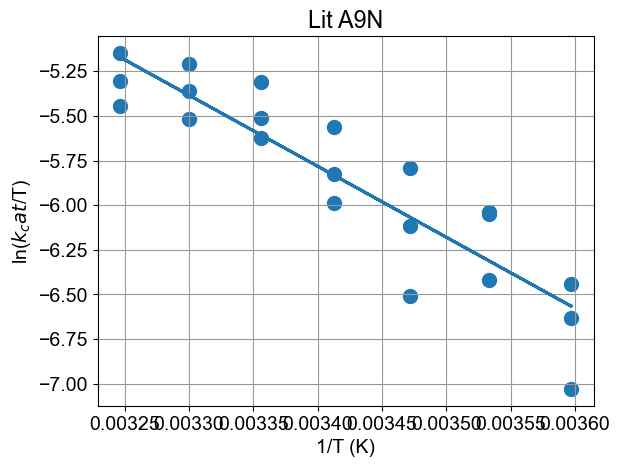

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     85.89
Date:                Wed, 08 May 2024   Prob (F-statistic):           1.77e-08
Time:                        17:46:58   Log-Likelihood:                 2.1495
No. Observations:                  21   AIC:                           -0.2991
Df Residuals:                      19   BIC:                             1.790
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.7406      1.467      5.276      0.0

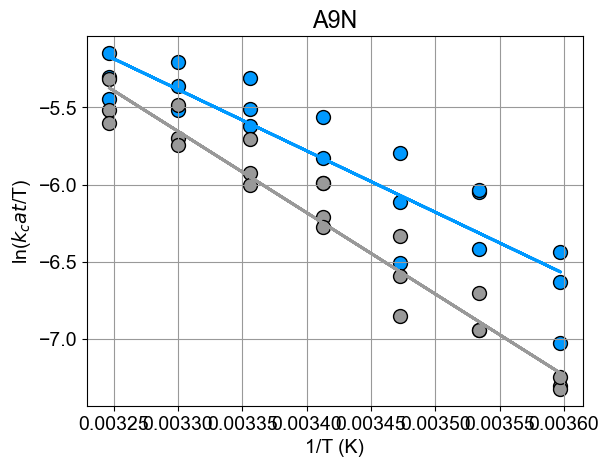

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


dark slopes


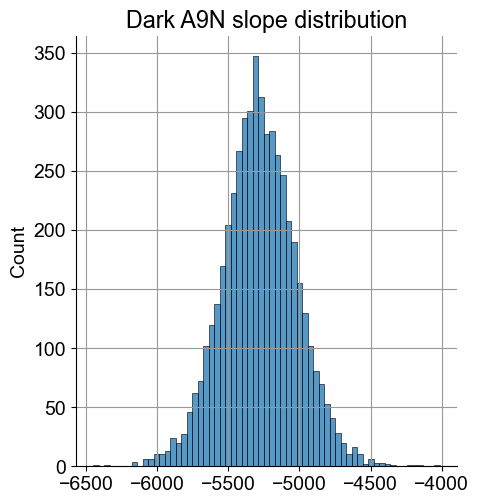


Mean:  -5282.077736825902

std:  259.3795574805317

variance:  67277.75483879645
The 95% confidence interval:  [-5788.353053   -4766.05768656]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


dark intercepts


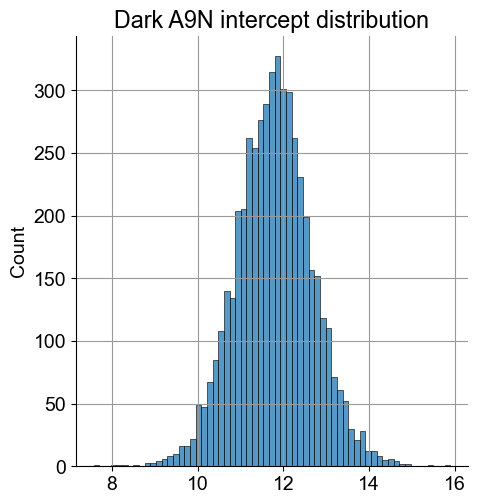


Mean:  11.780503259760525

std:  0.8903121727599214

variance:  0.7926557649644921
The 95% confidence interval:  [10.04383229 13.53615252]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


lit slopes


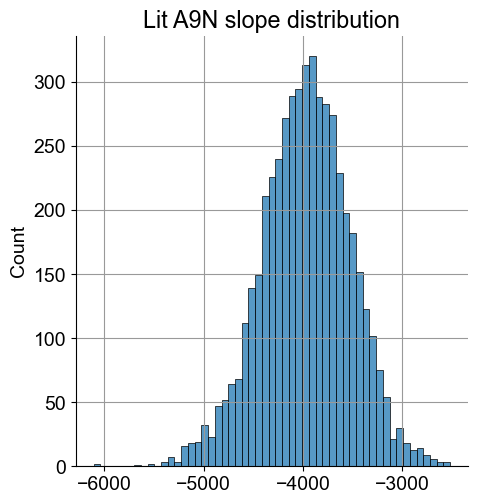


Mean:  -3973.0685256094694

std:  446.0879966591726

variance:  198994.50076339394
The 95% confidence interval:  [-4890.75017889 -3143.42468232]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


lit intercepts


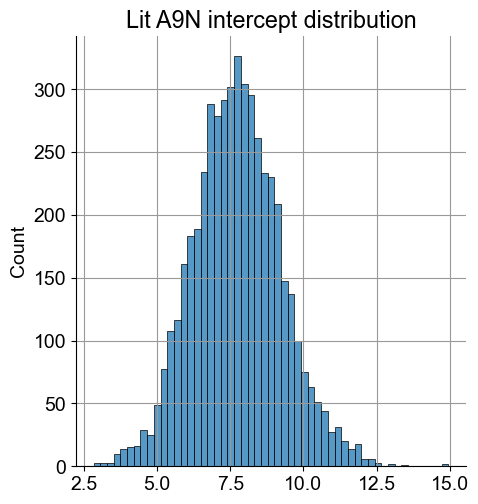


Mean:  7.729852341086719

std:  1.5051839862660232

variance:  2.2655788325116757
The 95% confidence interval:  [ 4.94648941 10.85938783]
dark enthalpy

Mean:  10.496567373092354

std:  0.5154401612296866

variance:  0.26567855980848537
The 95% confidence interval:  [ 9.47113013 11.50263984]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


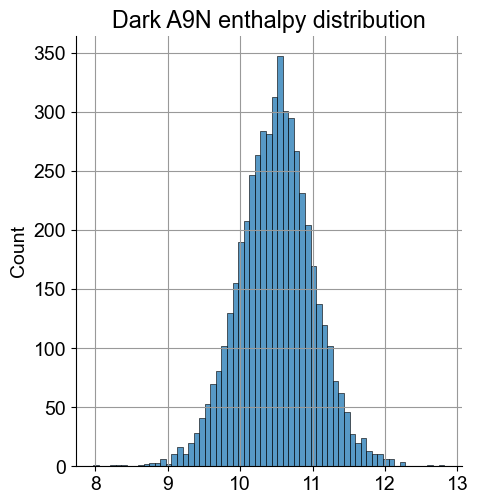

lit enthalpy

Mean:  7.89529869396298

std:  0.886467966689664

variance:  0.7858254559669072
The 95% confidence interval:  [6.24662692 9.71891958]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


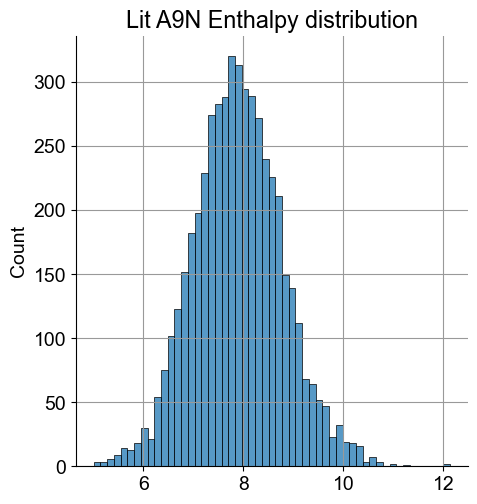

p value that enthalpy are different:  0.0
dark entropy

Mean:  -23.806087835043005

std:  1.769232141228286

variance:  3.1301823695552264
The 95% confidence interval:  [-27.25720778 -20.31725415]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


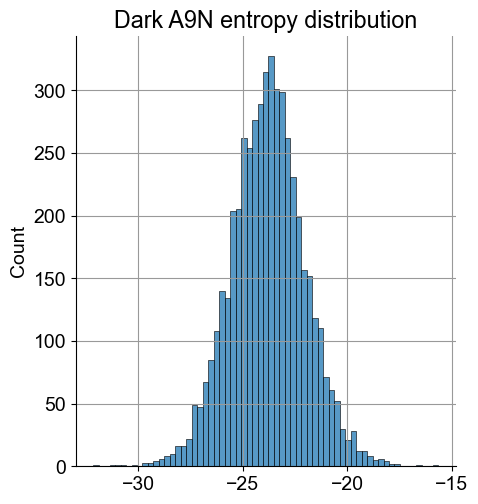

lit entropy

Mean:  -31.855558590898983

std:  2.9911080275458217

variance:  8.946727232449057
The 95% confidence interval:  [-37.38666926 -25.63653234]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


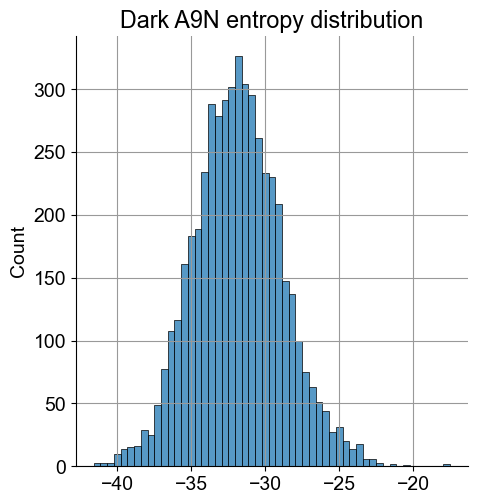

p value that entropy are different:  0.0
kcat_dark

kcat_dark_mean:  0.4817862269865611

std:  0.01626915183395105

variance:  0.0002646853013961528
The 95% confidence interval:  [0.45148188 0.5150677 ]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


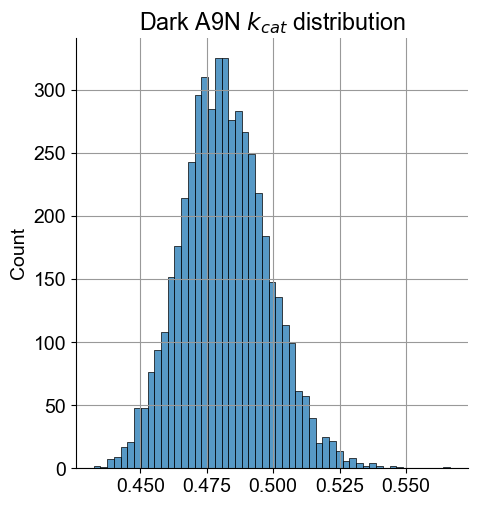

Kcat_lit

kcat lit mean:  0.7604165125101681

std:  0.04209975116109552

variance:  0.001772389047826163
The 95% confidence interval:  [0.68202348 0.84847834]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


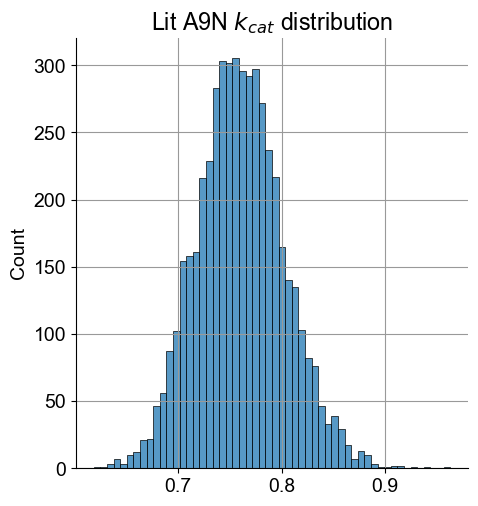

delta G dark

Mean:  17412.235889172345

std:  19.437431708493946

variance:  377.81375142236595
The 95% confidence interval:  [17373.34684686 17449.41141713]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


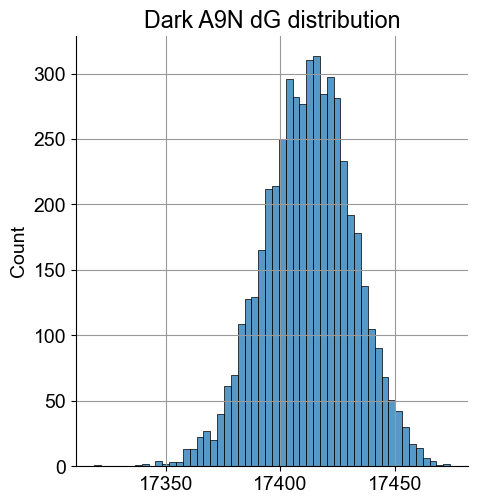

delta G lit

Mean:  17149.338464619137

std:  31.913511609325

variance:  1018.4722232385215
The 95% confidence interval:  [17085.19834296 17211.26562536]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


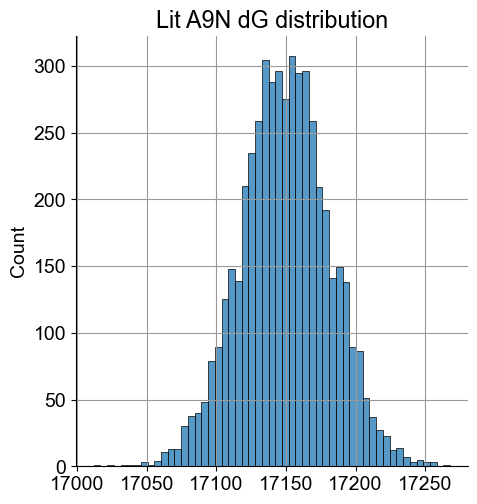

delta G lit - delta G dark (DeltaDeltaG)

Mean:  -262.89742455320993

std:  37.6429321874406

variance:  1416.9903436682514
The 95% confidence interval:  [-336.87405389 -187.50442388]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


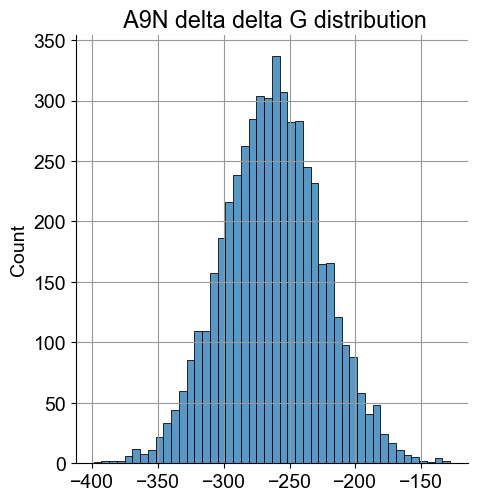

Intercept, x-Slope : Intercept    16995.140309
x               23.805765
dtype: float64
Intercept, x-Slope : Intercept    16591.275362
x               31.857350
dtype: float64


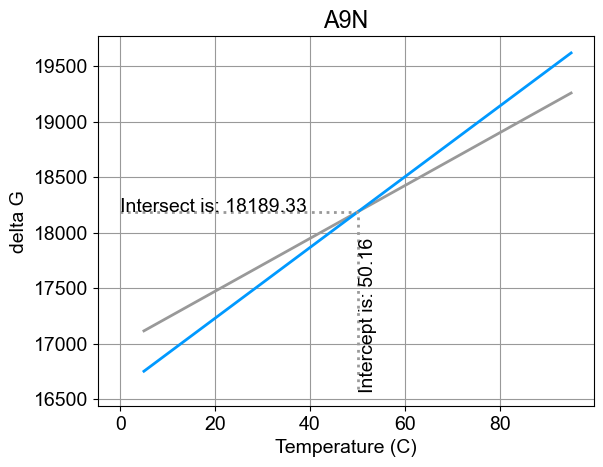

Intercept, x-Slope: 
 Intercept   -402.931358
x              8.032473
dtype: float64
Y Intercept is: 50.16


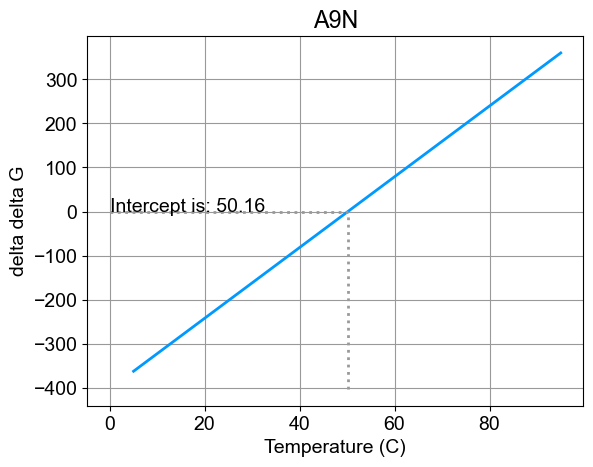

######################## M16A ########################
Intercept, x-Slope : Intercept      14.764333
x           -6518.040632
dtype: float64


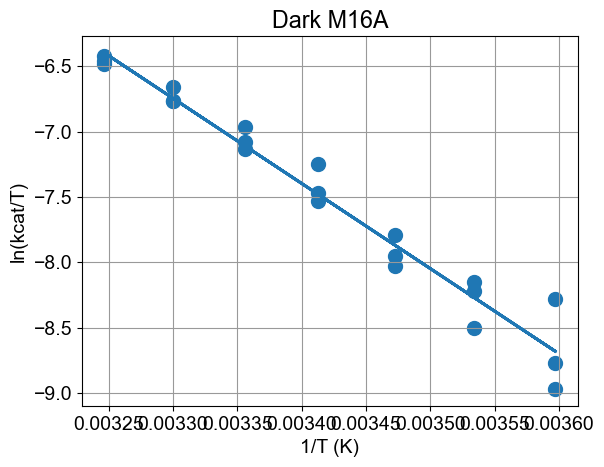

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     508.0
Date:                Wed, 08 May 2024   Prob (F-statistic):           3.59e-15
Time:                        17:51:20   Log-Likelihood:                 10.438
No. Observations:                  21   AIC:                            -16.88
Df Residuals:                      19   BIC:                            -14.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.7643      0.989     14.933      0.0

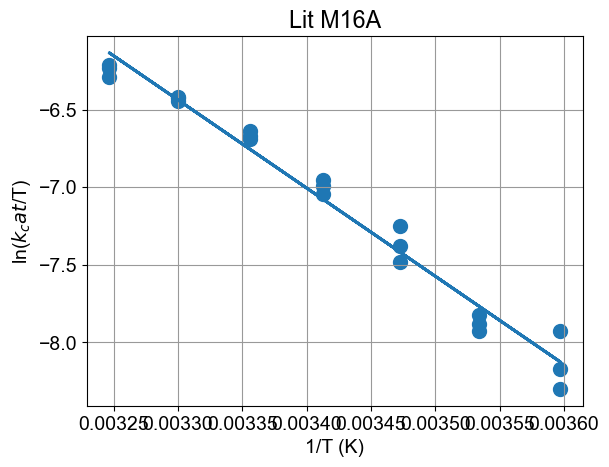

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     731.7
Date:                Wed, 08 May 2024   Prob (F-statistic):           1.24e-16
Time:                        17:51:21   Log-Likelihood:                 17.154
No. Observations:                  21   AIC:                            -30.31
Df Residuals:                      19   BIC:                            -28.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3108      0.718     17.144      0.0

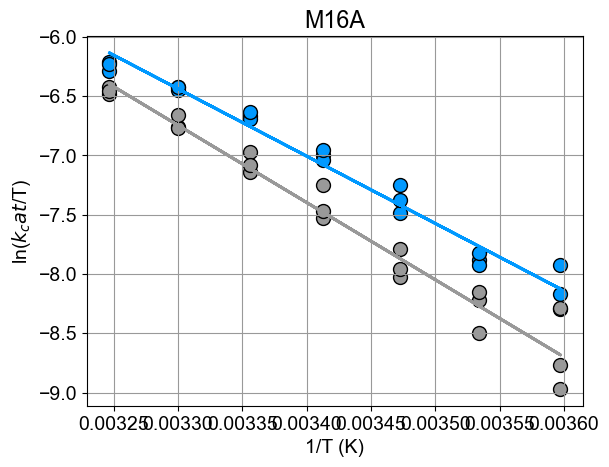

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


dark slopes


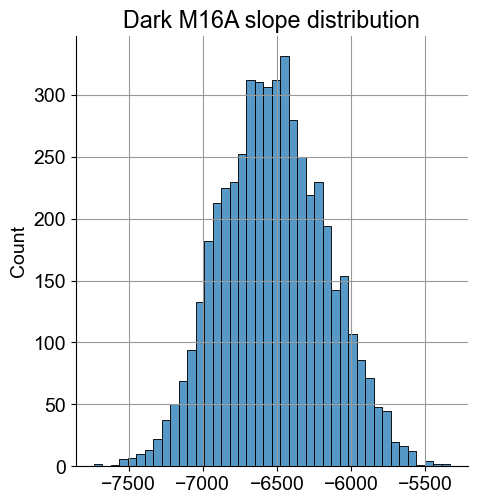


Mean:  -6523.047766467612

std:  353.876709973297

variance:  125228.72586152496
The 95% confidence interval:  [-7187.06393763 -5819.89085176]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


dark intercepts


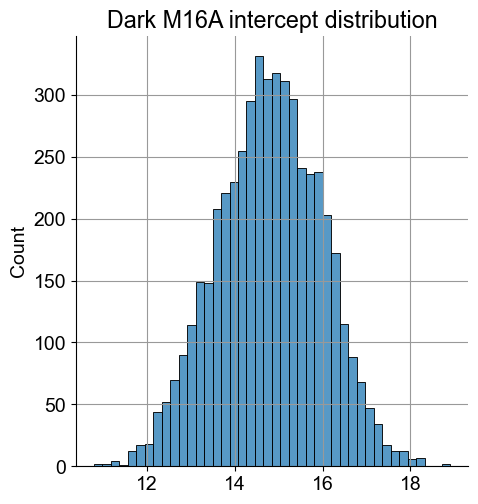


Mean:  14.782782155509858

std:  1.185897733265544

variance:  1.4063534337643553
The 95% confidence interval:  [12.41908848 17.01819975]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


lit slopes


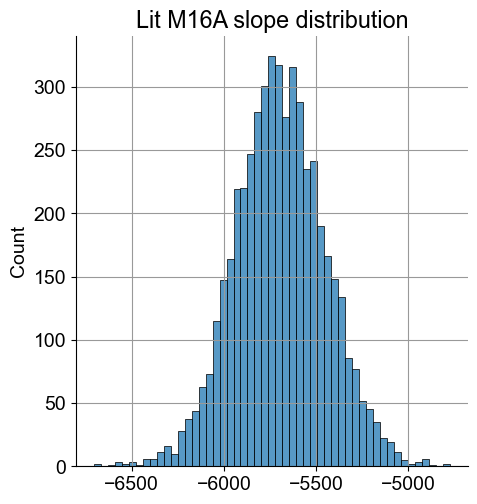


Mean:  -5696.170936144428

std:  245.7269874936338

variance:  60381.75238269646
The 95% confidence interval:  [-6176.99625045 -5212.82849872]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


lit intercepts


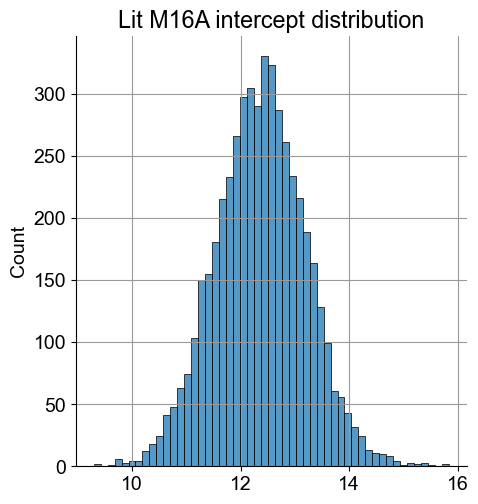


Mean:  12.363663995765808

std:  0.8321304267813162

variance:  0.6924410471752555
The 95% confidence interval:  [10.73920639 14.00026984]
dark enthalpy

Mean:  12.962628300841994

std:  0.7032253050927416

variance:  0.4945258297227796
The 95% confidence interval:  [11.56531189 14.28216406]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


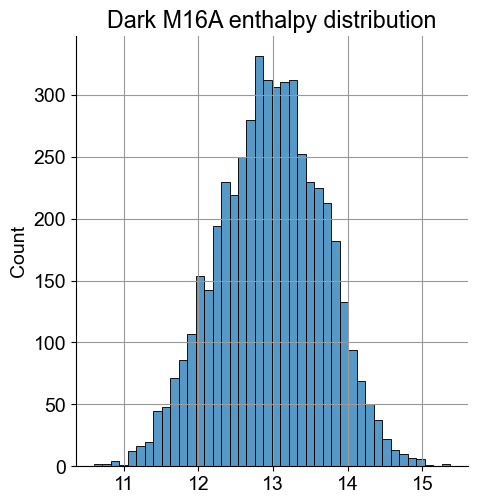

lit enthalpy

Mean:  11.319455142252332

std:  0.4883097160103311

variance:  0.2384463787500902
The 95% confidence interval:  [10.35895499 12.27495325]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


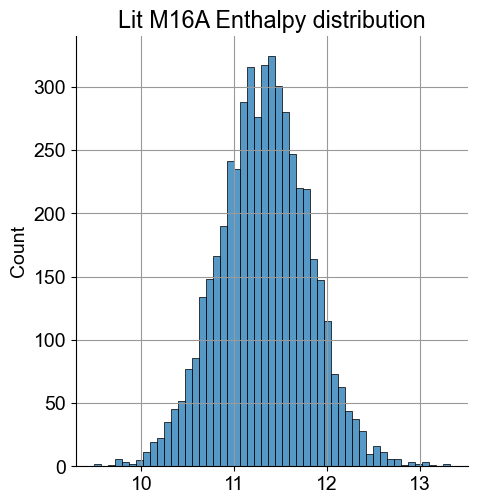

p value that enthalpy are different:  0.0
dark entropy

Mean:  -17.83994642778244

std:  2.356621025857796

variance:  5.553662659515052
The 95% confidence interval:  [-22.53708856 -13.39771507]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


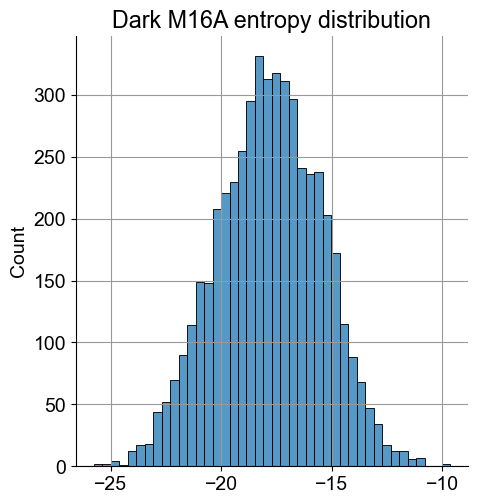

lit entropy

Mean:  -22.647228336981183

std:  1.6536131278444428

variance:  2.734436376579482
The 95% confidence interval:  [-25.87535742 -19.39495824]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


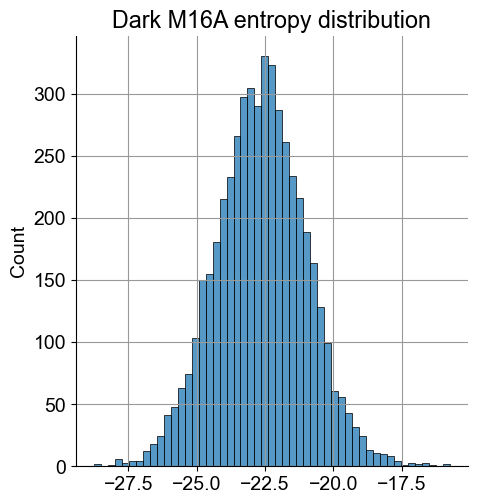

p value that entropy are different:  0.0
kcat_dark

kcat_dark_mean:  0.13539011845304175

std:  0.005401356769689906

variance:  2.9174654953474978e-05
The 95% confidence interval:  [0.12585789 0.14701254]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


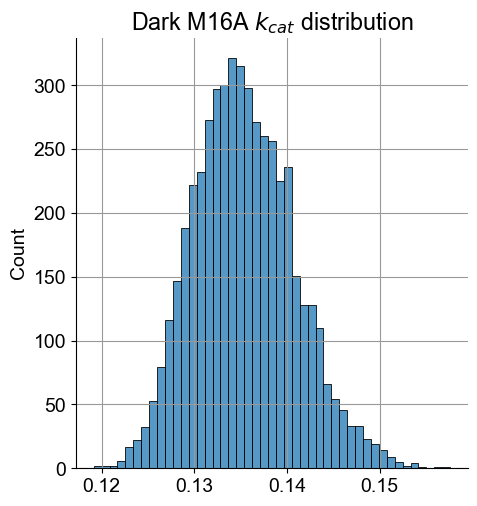

Kcat_lit

kcat lit mean:  0.20747224738834838

std:  0.005534216911599056

variance:  3.0627556824628984e-05
The 95% confidence interval:  [0.19746283 0.21886792]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


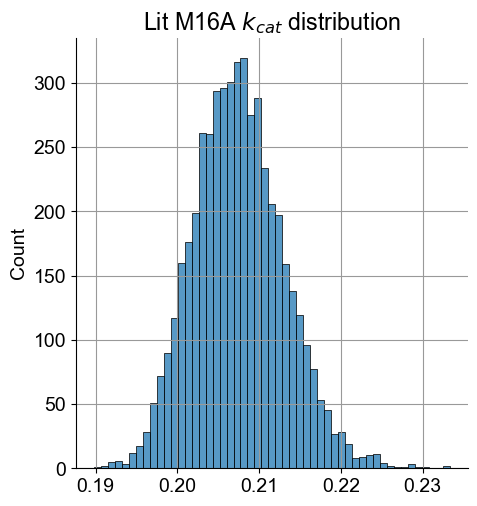

delta G dark

Mean:  18145.132738112796

std:  22.92478858381908

variance:  525.5459316128016
The 95% confidence interval:  [18097.13268278 18186.82193845]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


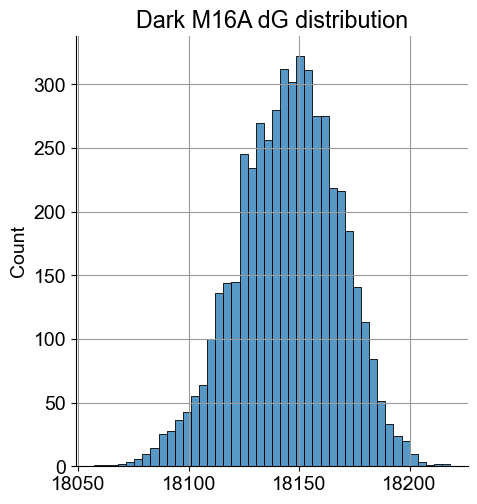

delta G lit

Mean:  17898.474974145363

std:  15.3494906709811

variance:  235.6068638585358
The 95% confidence interval:  [17867.40270347 17926.81553104]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


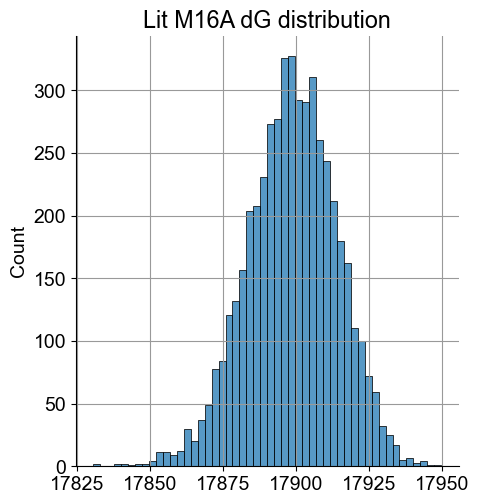

delta G lit - delta G dark (DeltaDeltaG)

Mean:  -246.65776396742643

std:  27.449967988439152

variance:  753.5007425663342
The 95% confidence interval:  [-300.09353449 -191.569813  ]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


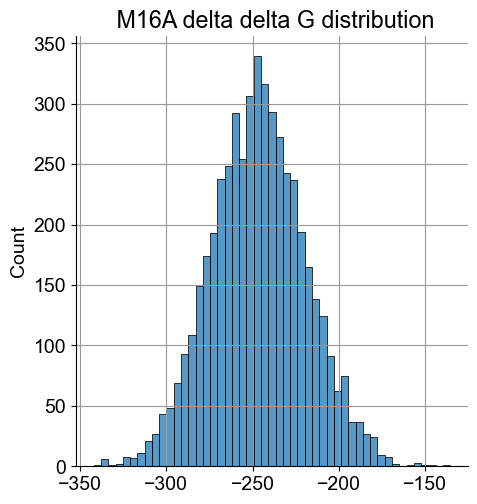

Intercept, x-Slope : Intercept    17832.437649
x               17.840038
dtype: float64
Intercept, x-Slope : Intercept    17501.652492
x               22.646950
dtype: float64


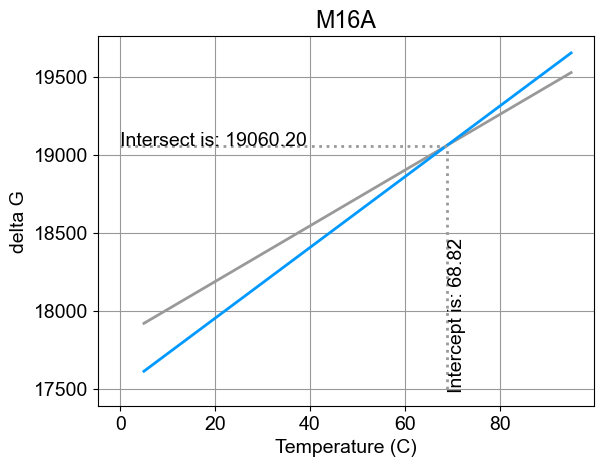

Intercept, x-Slope: 
 Intercept   -329.877528
x              4.793375
dtype: float64
Y Intercept is: 68.82


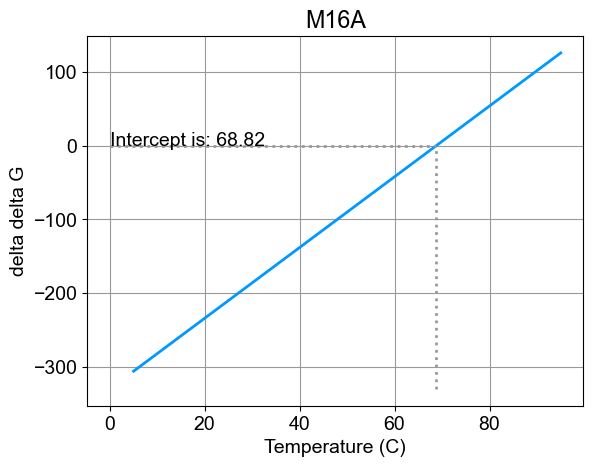

######################## M16P ########################
Intercept, x-Slope : Intercept      13.63022
x           -6628.94769
dtype: float64


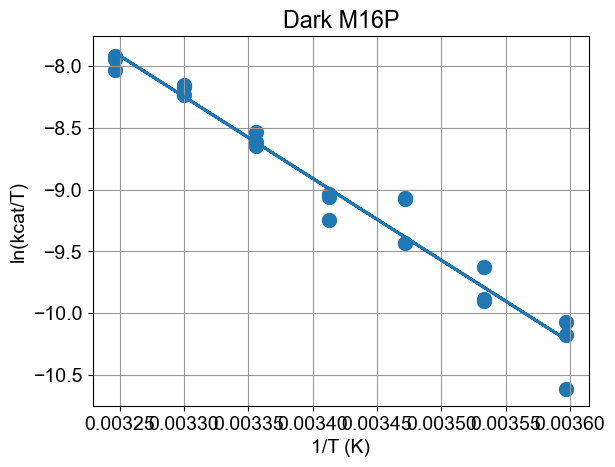

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     441.2
Date:                Wed, 08 May 2024   Prob (F-statistic):           1.30e-14
Time:                        17:55:59   Log-Likelihood:                 8.6033
No. Observations:                  21   AIC:                            -13.21
Df Residuals:                      19   BIC:                            -11.12
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6302      1.079     12.632      0.0

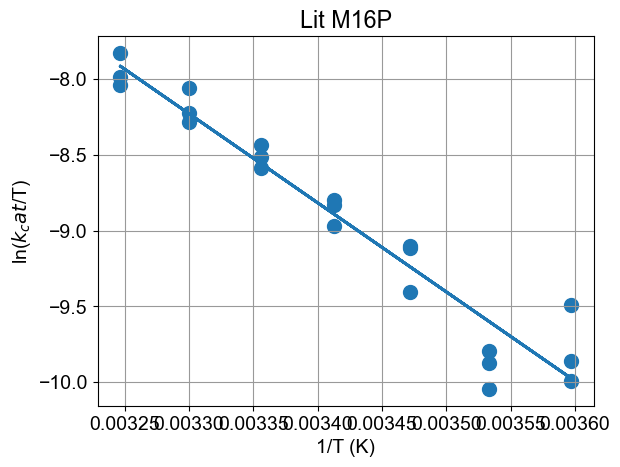

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     264.1
Date:                Wed, 08 May 2024   Prob (F-statistic):           1.33e-12
Time:                        17:55:59   Log-Likelihood:                 5.7487
No. Observations:                  21   AIC:                            -7.497
Df Residuals:                      19   BIC:                            -5.408
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1613      1.236      9.030      0.0

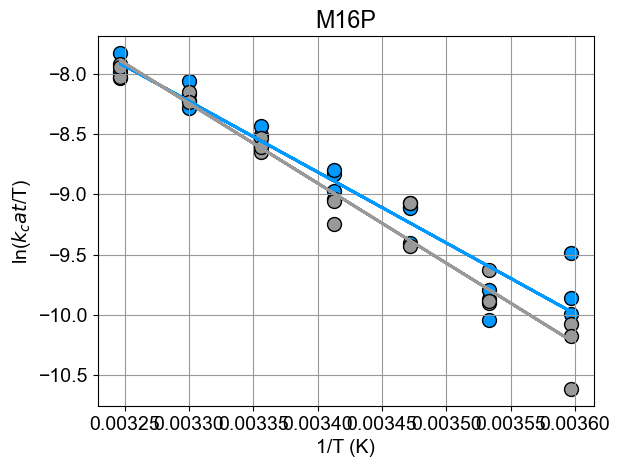

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


dark slopes


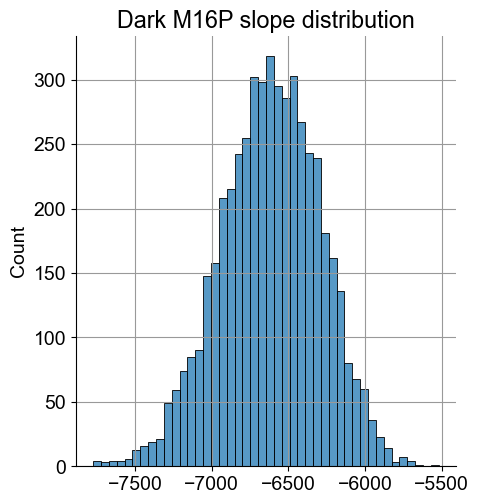


Mean:  -6616.914827669765

std:  323.8715102069284

variance:  104892.75512371652
The 95% confidence interval:  [-7275.51353343 -6014.1041858 ]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


dark intercepts


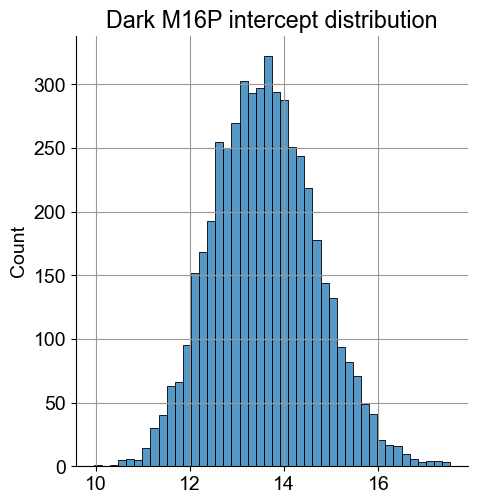


Mean:  13.591281328868877

std:  1.0845746405703003

variance:  1.176302150968196
The 95% confidence interval:  [11.59150968 15.79536833]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


lit slopes


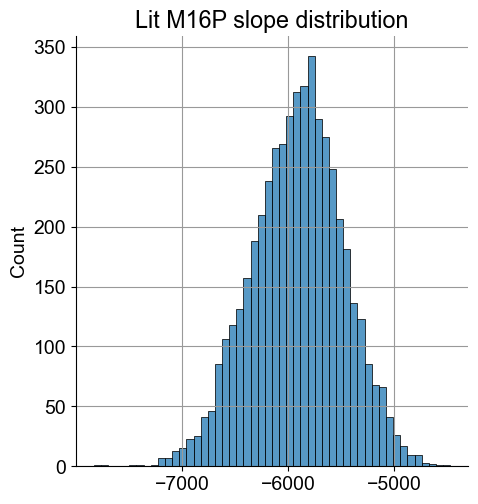


Mean:  -5912.811274916228

std:  428.9548465155754

variance:  184002.26034920083
The 95% confidence interval:  [-6769.77372794 -5096.69064935]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


lit intercepts


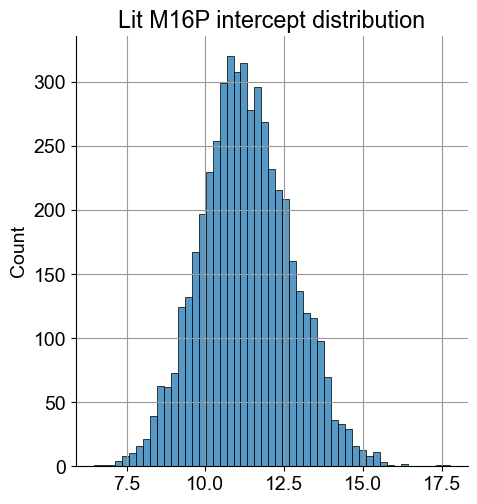


Mean:  11.285680345468108

std:  1.4363344882392377

variance:  2.063056762105473
The 95% confidence interval:  [ 8.56442374 14.17443117]
dark enthalpy

Mean:  13.149161324609013

std:  0.6435988443356452

variance:  0.41421947243017804
The 95% confidence interval:  [11.95125345 14.45793148]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


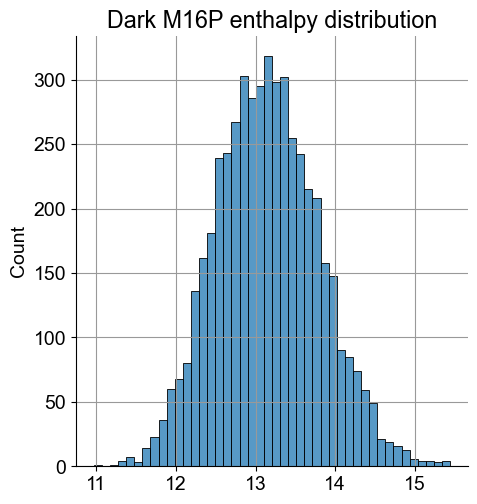

lit enthalpy

Mean:  11.749963746053046

std:  0.8524208977603749

variance:  0.7266213869386036
The 95% confidence interval:  [10.12816536 13.45292318]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


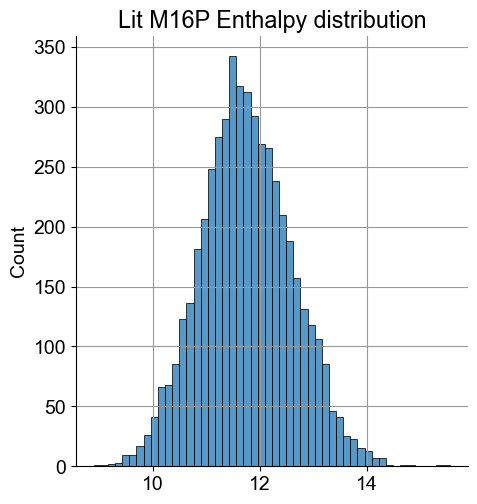

p value that enthalpy are different:  0.0
dark entropy

Mean:  -20.20770194465747

std:  2.1552713445551483

variance:  4.645194568660557
The 95% confidence interval:  [-24.18165667 -15.82773087]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


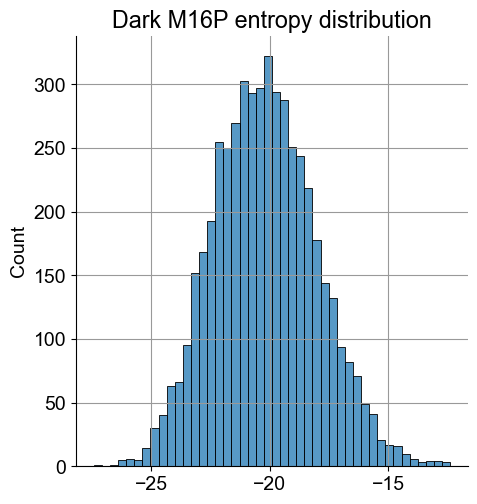

lit entropy

Mean:  -24.78940203759796

std:  2.8542900118617105

variance:  8.146971471813524
The 95% confidence interval:  [-30.19709475 -19.04886409]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


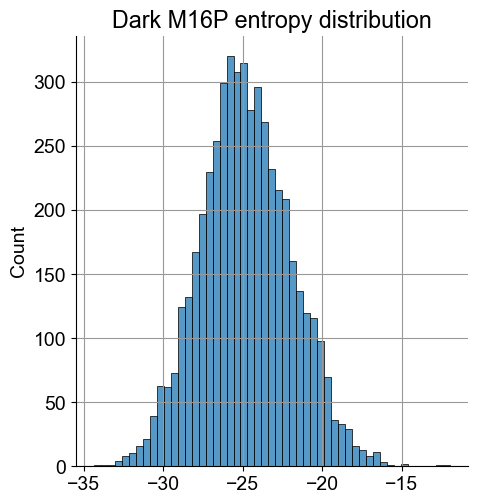

p value that entropy are different:  0.0
kcat_dark

kcat_dark_mean:  0.029773534574716827

std:  0.001245321756817886

variance:  1.5508262780039858e-06
The 95% confidence interval:  [0.02738761 0.03228633]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


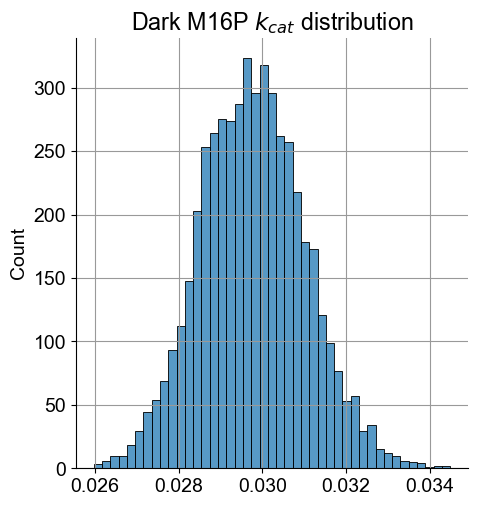

Kcat_lit

kcat lit mean:  0.03351897109674159

std:  0.001644215740838868

variance:  2.7034454024223073e-06
The 95% confidence interval:  [0.03047503 0.03686084]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


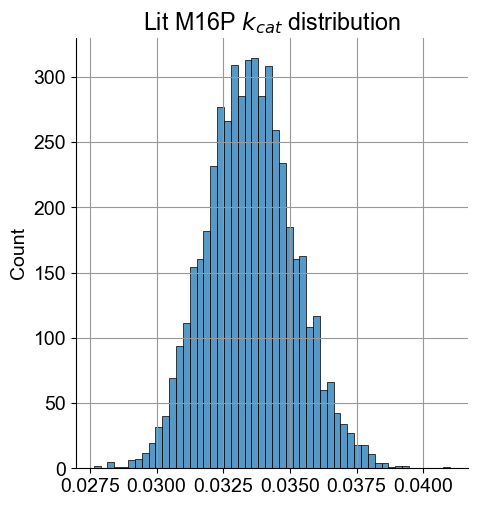

delta G dark

Mean:  19019.498739532006

std:  24.129511931289674

variance:  582.2333460422508
The 95% confidence interval:  [18972.22066377 19067.21437966]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


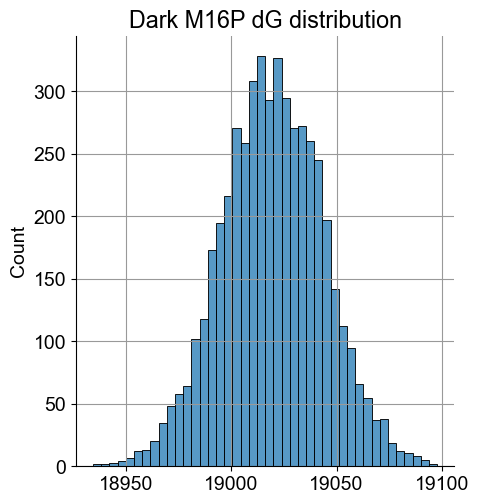

delta G lit

Mean:  18951.285037975253

std:  28.305966016428112

variance:  801.2277121231831
The 95% confidence interval:  [18895.72724656 19005.55067502]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


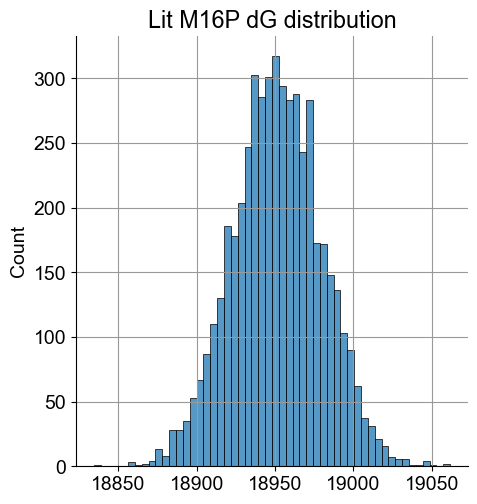

delta G lit - delta G dark (DeltaDeltaG)

Mean:  -68.21370155675183

std:  36.93146795914305

variance:  1363.9333256172097
The 95% confidence interval:  [-140.95666994    2.41695851]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


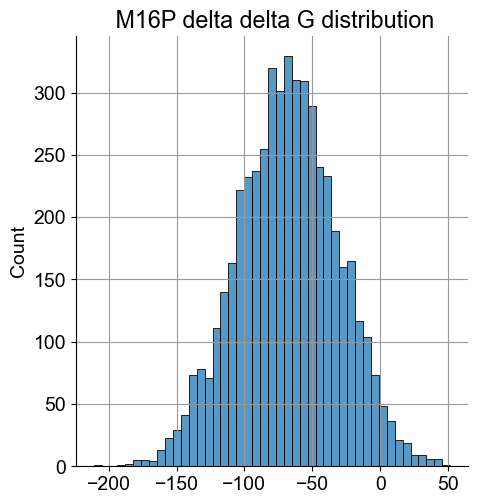

Intercept, x-Slope : Intercept    18665.368211
x               20.207581
dtype: float64
Intercept, x-Slope : Intercept    18516.947125
x               24.789409
dtype: float64


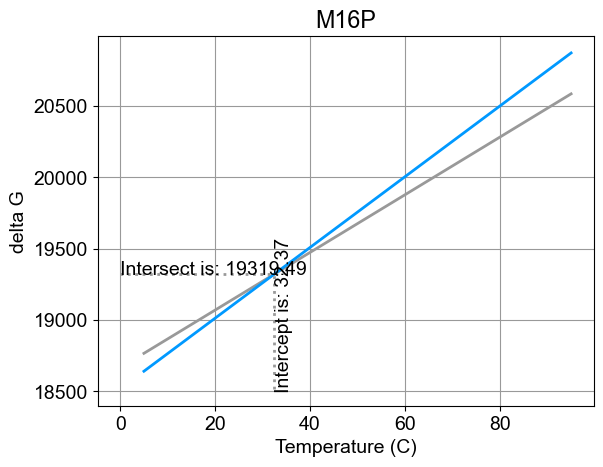

Intercept, x-Slope: 
 Intercept   -147.852365
x              4.566937
dtype: float64
Y Intercept is: 32.37


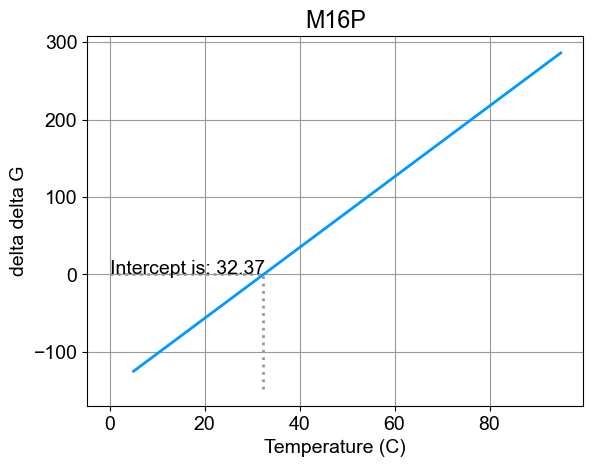

######################## G86K ########################
Intercept, x-Slope : Intercept       7.607439
x           -4178.284915
dtype: float64


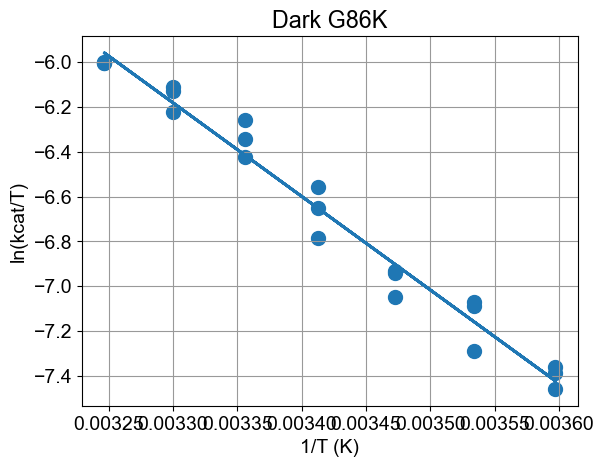

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     721.2
Date:                Wed, 08 May 2024   Prob (F-statistic):           1.42e-16
Time:                        17:59:45   Log-Likelihood:                 23.456
No. Observations:                  21   AIC:                            -42.91
Df Residuals:                      19   BIC:                            -40.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6074      0.532     14.302      0.0

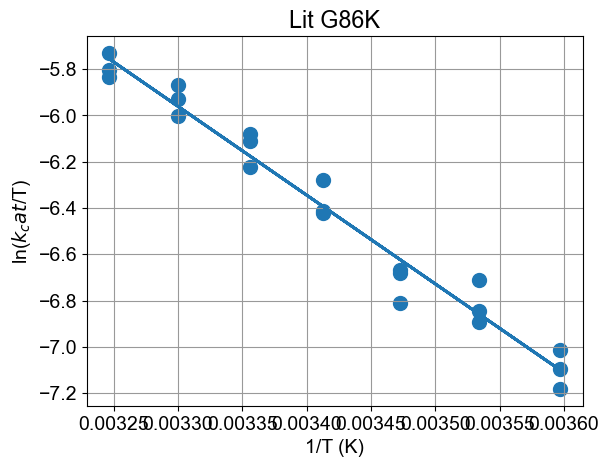

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     625.5
Date:                Wed, 08 May 2024   Prob (F-statistic):           5.28e-16
Time:                        17:59:46   Log-Likelihood:                 23.746
No. Observations:                  21   AIC:                            -43.49
Df Residuals:                      19   BIC:                            -41.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7044      0.525     12.779      0.0

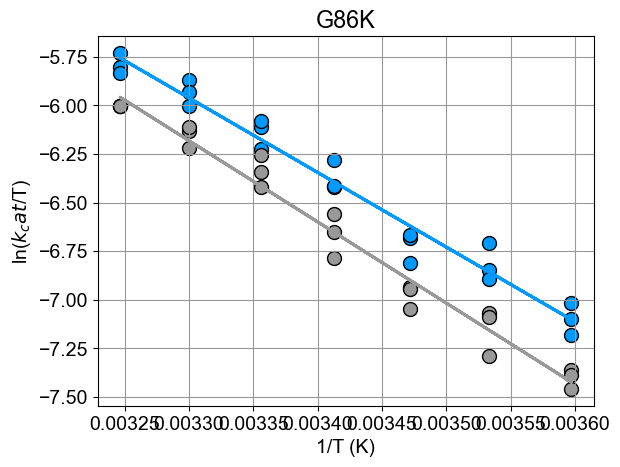

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


dark slopes


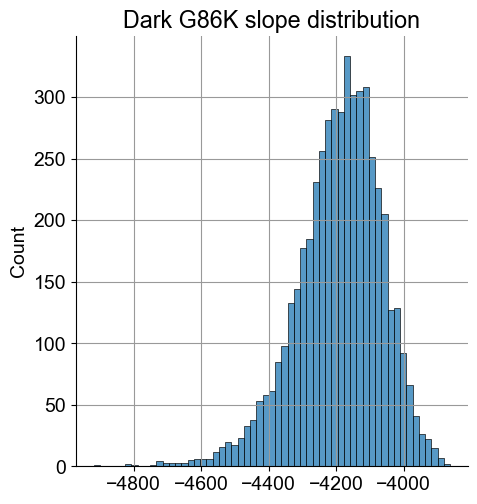


Mean:  -4192.723661768194

std:  127.27378259872441

variance:  16198.615736987364
The 95% confidence interval:  [-4477.95158313 -3976.86328745]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


dark intercepts


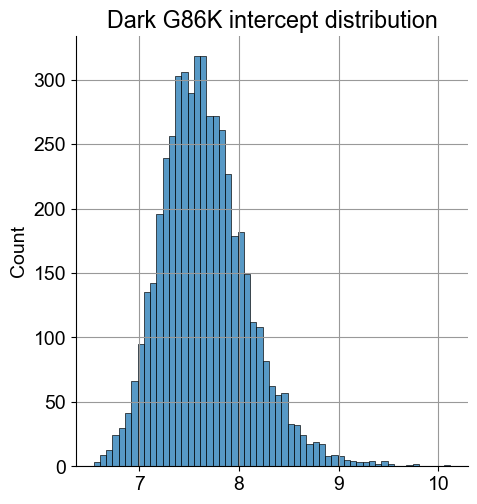


Mean:  7.657236891304981

std:  0.4329073724256047

variance:  0.18740879310044117
The 95% confidence interval:  [6.9284674  8.62417735]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


lit slopes


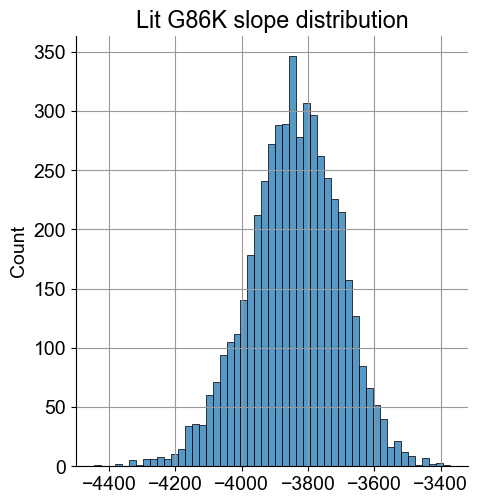


Mean:  -3842.955523831122

std:  137.67210609211733

variance:  18953.60879583921
The 95% confidence interval:  [-4131.03360627 -3586.38428637]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


lit intercepts


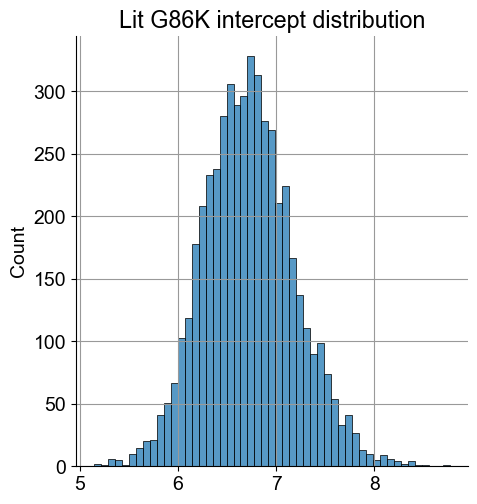


Mean:  6.72155864841825

std:  0.46620566228671173

variance:  0.2173477195481915
The 95% confidence interval:  [5.85541195 7.69336198]
dark enthalpy

Mean:  8.33179831596993

std:  0.2529190027935123

variance:  0.06396802197406469
The 95% confidence interval:  [7.90283966 8.89860446]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


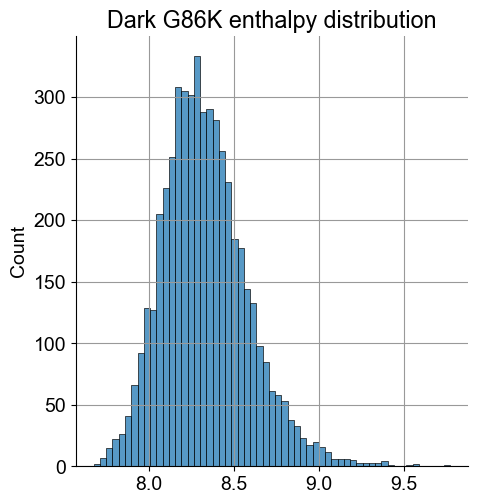

lit enthalpy

Mean:  7.636737582724506

std:  0.27358259552230774

variance:  0.07484743657272264
The 95% confidence interval:  [7.12687813 8.20920757]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


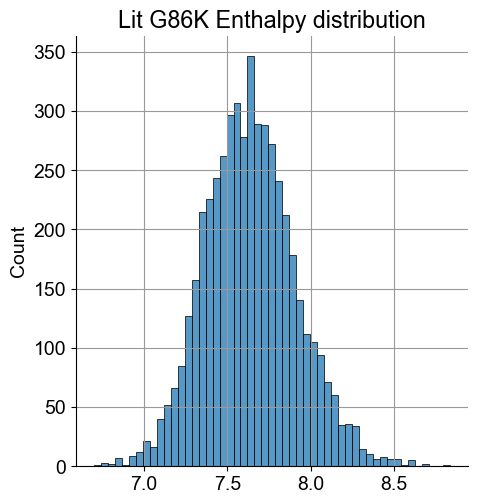

p value that enthalpy are different:  0.0
dark entropy

Mean:  -31.99986032194837

std:  0.8602753740811733

variance:  0.7400737192505027
The 95% confidence interval:  [-33.44807415 -30.07835213]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


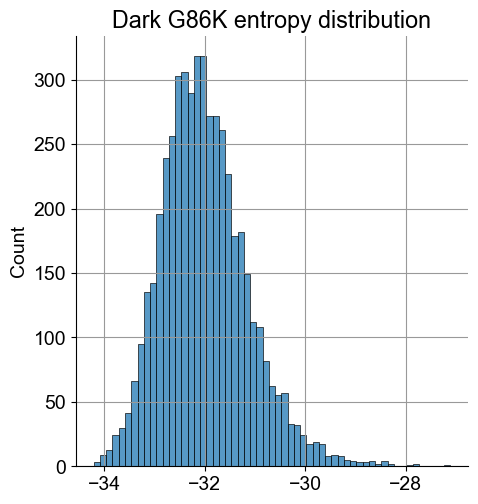

lit entropy

Mean:  -33.859244110930454

std:  0.9264458774986222

variance:  0.8583019639341921
The 95% confidence interval:  [-35.58045452 -31.9280724 ]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


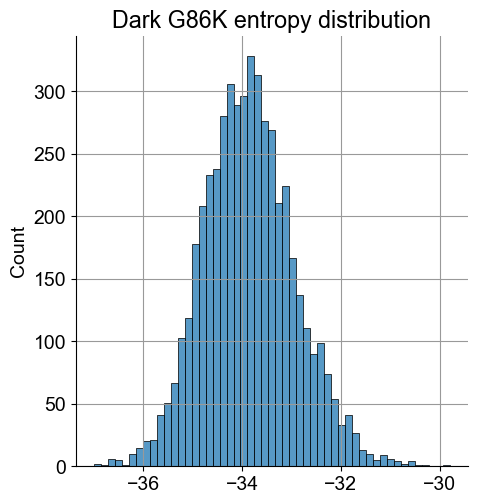

p value that entropy are different:  0.0
kcat_dark

kcat_dark_mean:  0.3315484394692604

std:  0.006285592568135457

variance:  3.950867393259969e-05
The 95% confidence interval:  [0.31945258 0.34407075]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


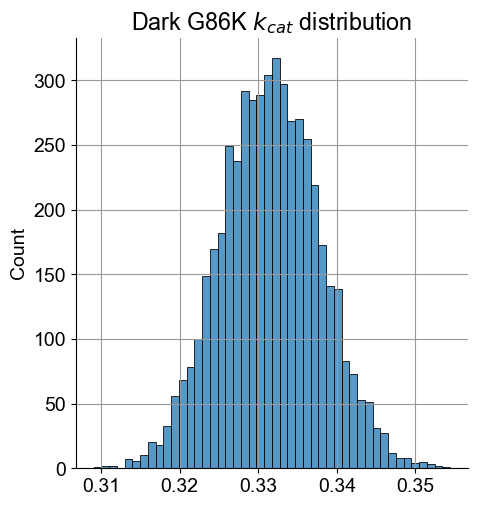

Kcat_lit

kcat lit mean:  0.43359638411874646

std:  0.008155031338624137

variance:  6.650453613394178e-05
The 95% confidence interval:  [0.41761178 0.44980045]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


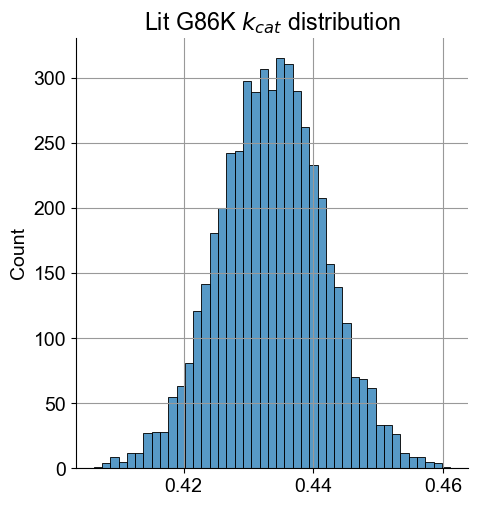

delta G dark

Mean:  17627.75773949593

std:  10.94449879381658

variance:  119.78205384785258
The 95% confidence interval:  [17606.25217247 17649.10876318]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


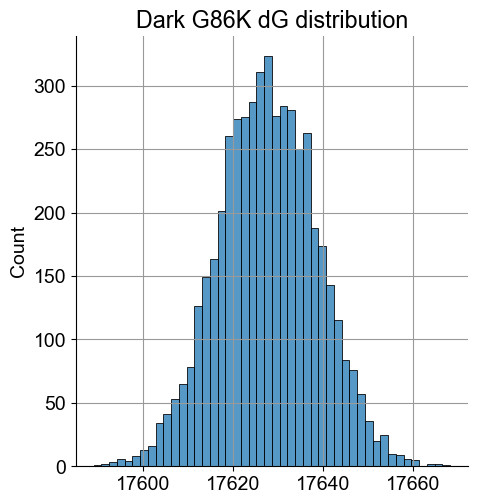

delta G lit

Mean:  17472.847996949804

std:  10.862702639364269

variance:  117.99830863125143
The 95% confidence interval:  [17451.56536926 17494.42965447]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


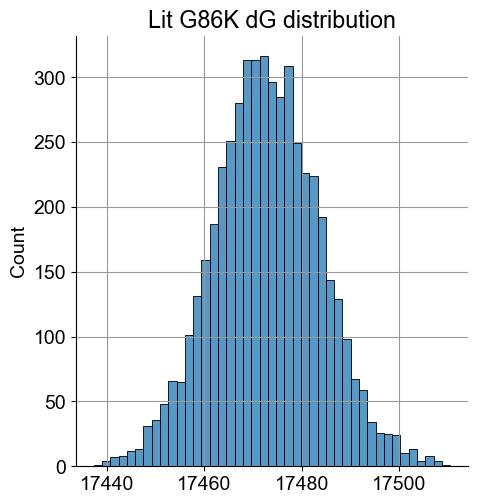

delta G lit - delta G dark (DeltaDeltaG)

Mean:  -154.90974254612746

std:  15.244673660573557

variance:  232.40007501738518
The 95% confidence interval:  [-184.20231996 -124.93454921]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


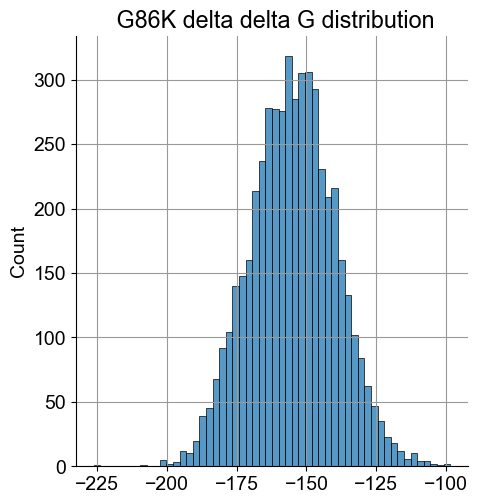

Intercept, x-Slope : Intercept    17067.0
x               32.0
dtype: float64
Intercept, x-Slope : Intercept    16879.806816
x               33.859468
dtype: float64


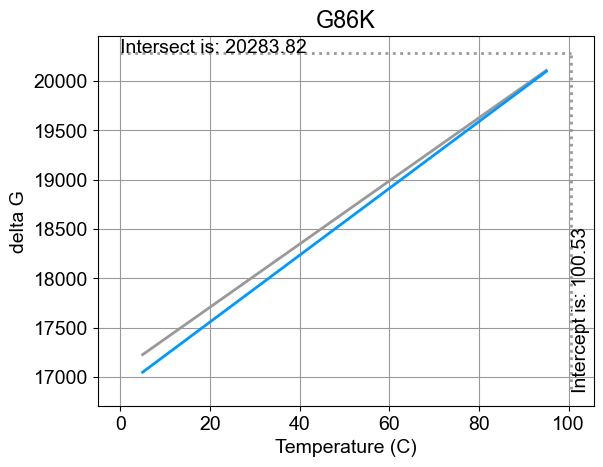

Intercept, x-Slope: 
 Intercept   -186.942029
x              1.859500
dtype: float64
Y Intercept is: 100.53


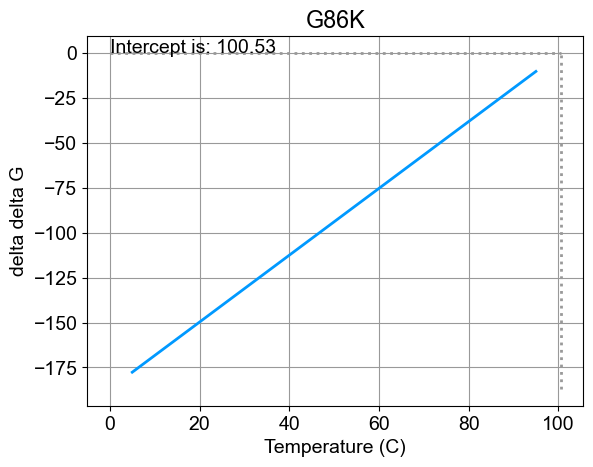

######################## D87A ########################
Intercept, x-Slope : Intercept      13.644569
x           -5864.364822
dtype: float64


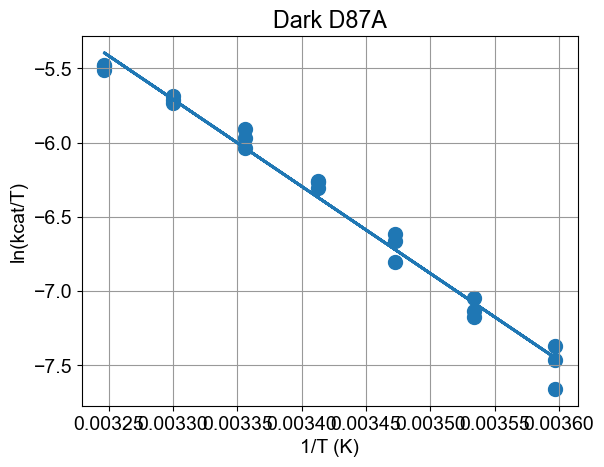

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     1175.
Date:                Wed, 08 May 2024   Prob (F-statistic):           1.50e-18
Time:                        18:03:33   Log-Likelihood:                 21.464
No. Observations:                  21   AIC:                            -38.93
Df Residuals:                      19   BIC:                            -36.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6446      0.585     23.330      0.0

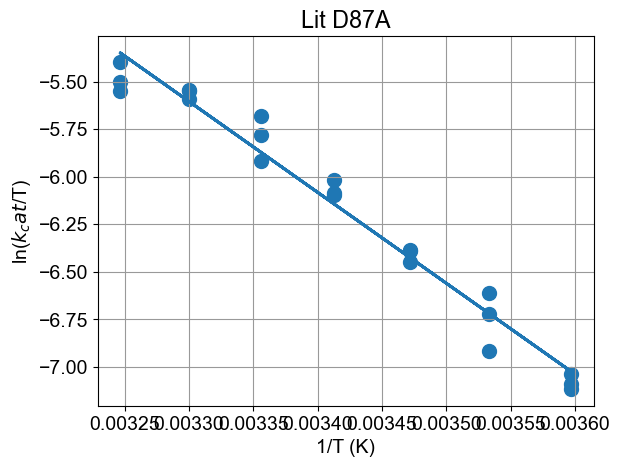

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     598.8
Date:                Wed, 08 May 2024   Prob (F-statistic):           7.90e-16
Time:                        18:03:34   Log-Likelihood:                 18.678
No. Observations:                  21   AIC:                            -33.36
Df Residuals:                      19   BIC:                            -31.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.1698      0.668     15.228      0.0

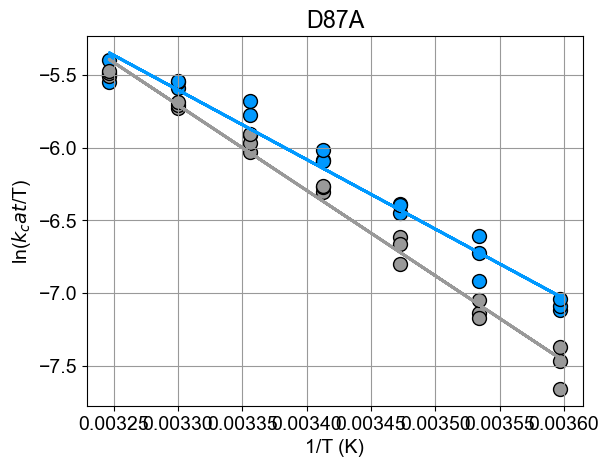

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


dark slopes


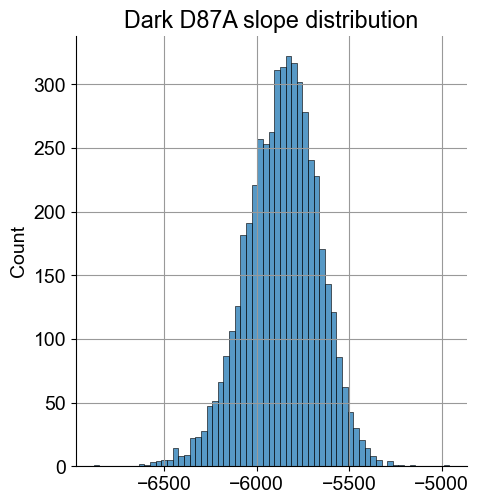


Mean:  -5864.349271538781

std:  196.09770498394084

variance:  38454.3098999687
The 95% confidence interval:  [-6271.81082454 -5507.22020403]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


dark intercepts


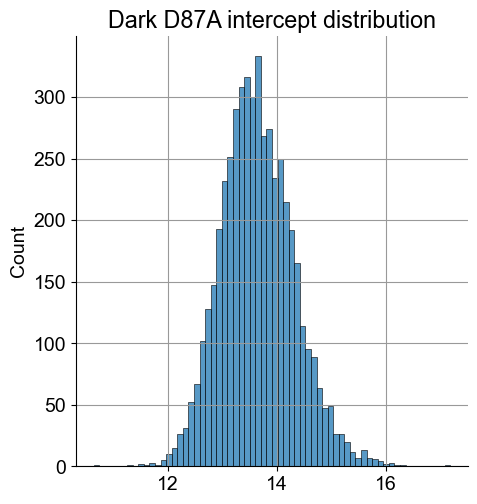


Mean:  13.647318605220667

std:  0.666534053155611

variance:  0.44426764401604685
The 95% confidence interval:  [12.44648105 15.04772723]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


lit slopes


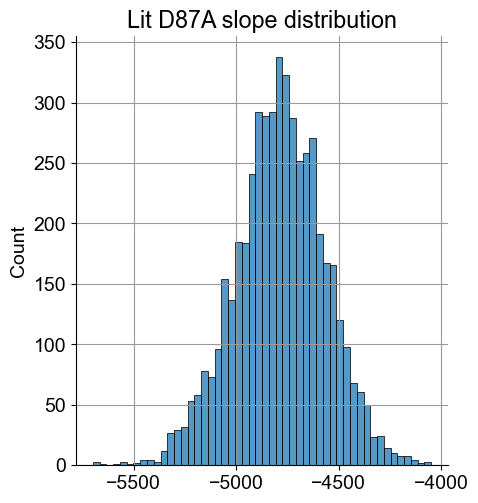


Mean:  -4786.897469383293

std:  219.9907295578272

variance:  48395.92109138506
The 95% confidence interval:  [-5234.00245608 -4362.70318121]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


lit intercepts


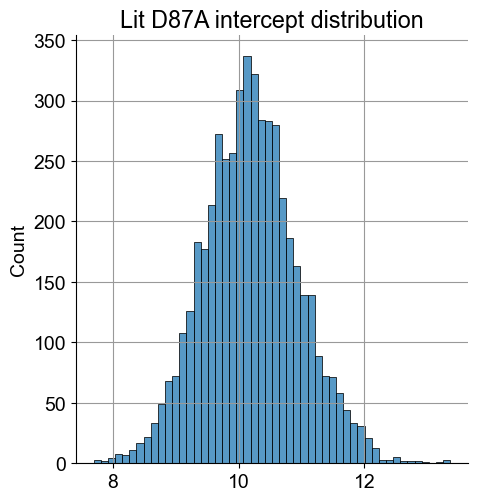


Mean:  10.19647327712051

std:  0.7568561918250101

variance:  0.5728312951038564
The 95% confidence interval:  [ 8.76105476 11.75253094]
dark enthalpy

Mean:  11.653659846559114

std:  0.38968619445378033

variance:  0.1518553301478695
The 95% confidence interval:  [10.94397144 12.46336918]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


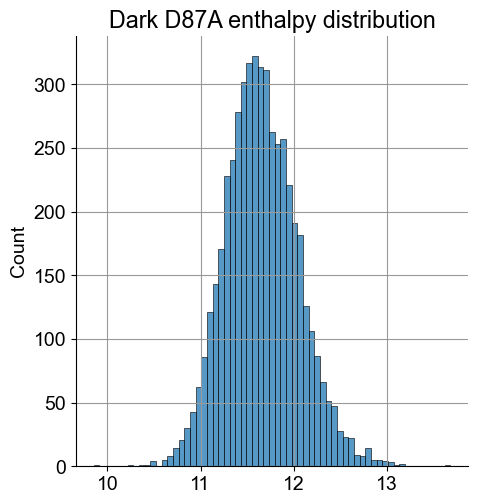

lit enthalpy

Mean:  9.512543036835492

std:  0.43716651463881734

variance:  0.1911145615214513
The 95% confidence interval:  [ 8.66958234 10.40103197]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


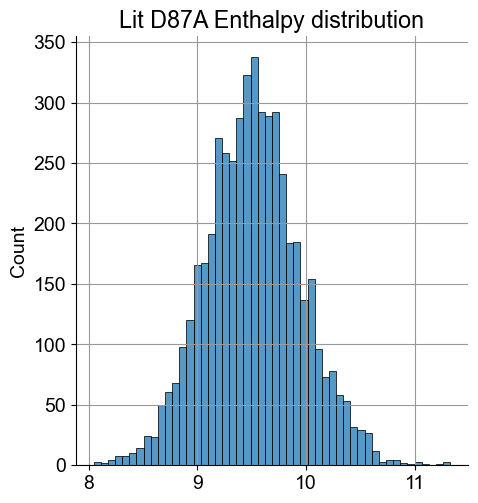

p value that enthalpy are different:  0.0
dark entropy

Mean:  -20.09634443044856

std:  1.3245393089599635

variance:  1.7544043809801377
The 95% confidence interval:  [-22.48265394 -17.31344644]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


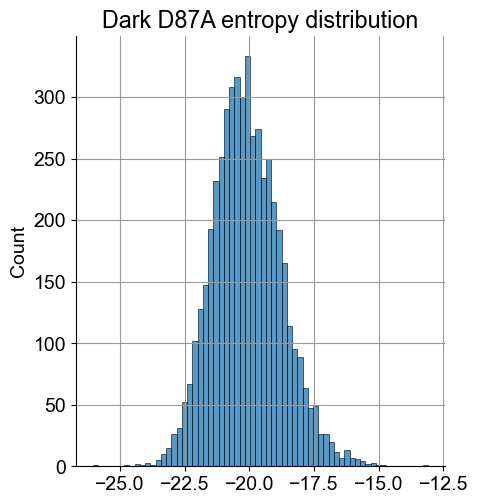

lit entropy

Mean:  -26.953878962360008

std:  1.504027847573341

variance:  2.2620997662760973
The 95% confidence interval:  [-29.80634875 -23.86167454]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


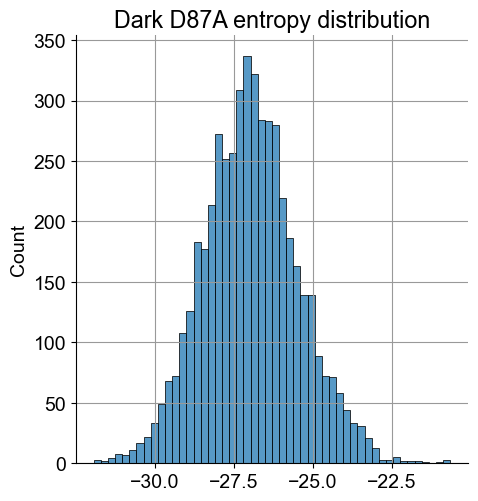

p value that entropy are different:  0.0
kcat_dark

kcat_dark_mean:  0.4197241177077471

std:  0.008939417221161889

variance:  7.991318025400575e-05
The 95% confidence interval:  [0.40224096 0.43718818]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


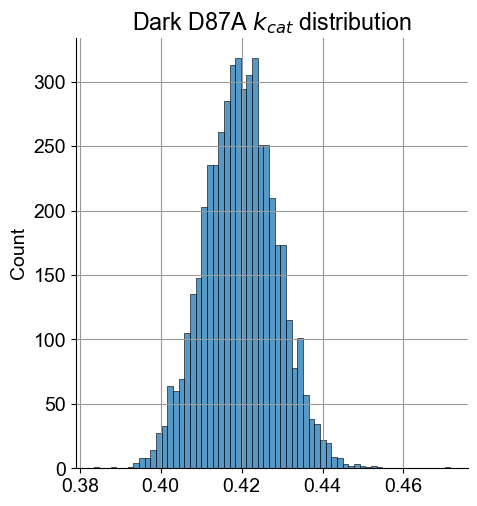

Kcat_lit

kcat lit mean:  0.5433331797593868

std:  0.011928088661582738

variance:  0.00014227929911857866
The 95% confidence interval:  [0.52045444 0.56709284]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


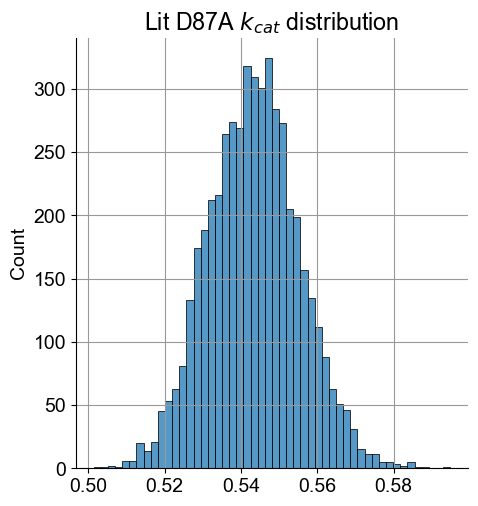

delta G dark

Mean:  17491.647903604426

std:  12.291279236795853

variance:  151.07554527688885
The 95% confidence interval:  [17467.98347482 17516.07830049]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


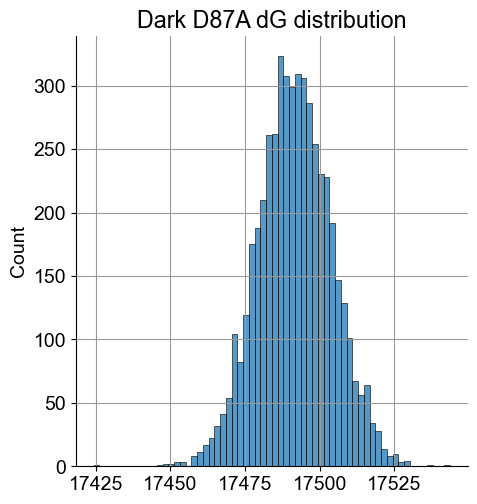

delta G lit

Mean:  17342.644875401074

std:  12.666696783210753

variance:  160.44520739780165
The 95% confidence interval:  [17317.79799458 17367.34078973]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


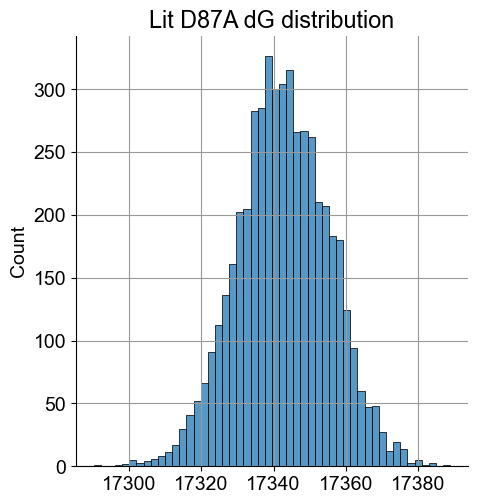

delta G lit - delta G dark (DeltaDeltaG)

Mean:  -149.00302820334787

std:  17.41644946843014

variance:  303.3327120863805
The 95% confidence interval:  [-183.2294852  -114.32902645]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


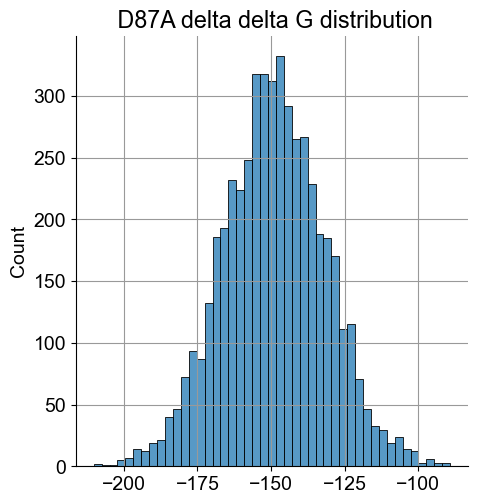

Intercept, x-Slope : Intercept    17139.450709
x               20.096480
dtype: float64
Intercept, x-Slope : Intercept    16870.485587
x               26.953145
dtype: float64


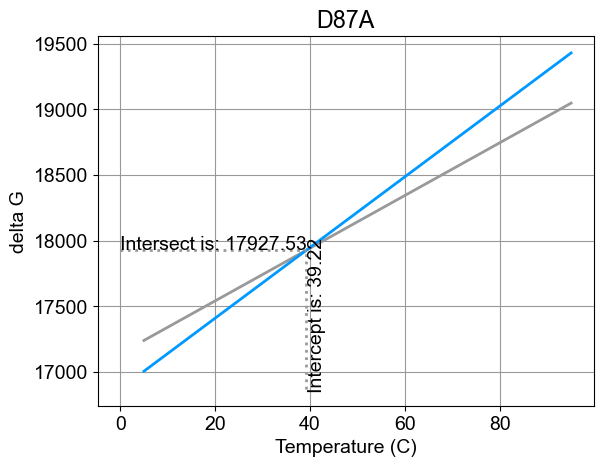

Intercept, x-Slope: 
 Intercept   -268.361841
x              6.842841
dtype: float64
Y Intercept is: 39.22


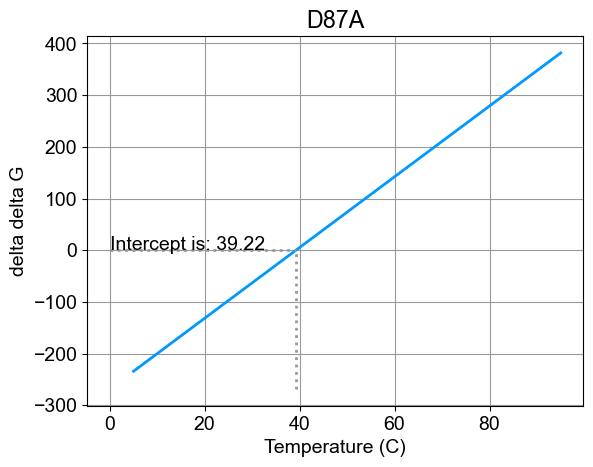

######################## R98M ########################
Intercept, x-Slope : Intercept       9.171813
x           -4505.474062
dtype: float64


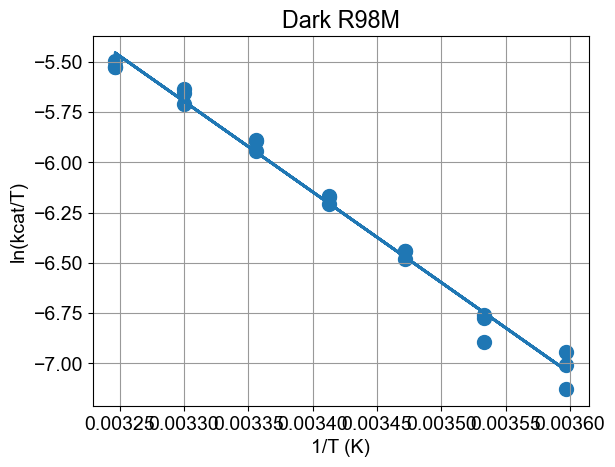

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1647.
Date:                Wed, 08 May 2024   Prob (F-statistic):           6.31e-20
Time:                        18:07:21   Log-Likelihood:                 30.546
No. Observations:                  21   AIC:                            -57.09
Df Residuals:                      19   BIC:                            -55.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.1718      0.380     24.168      0.0

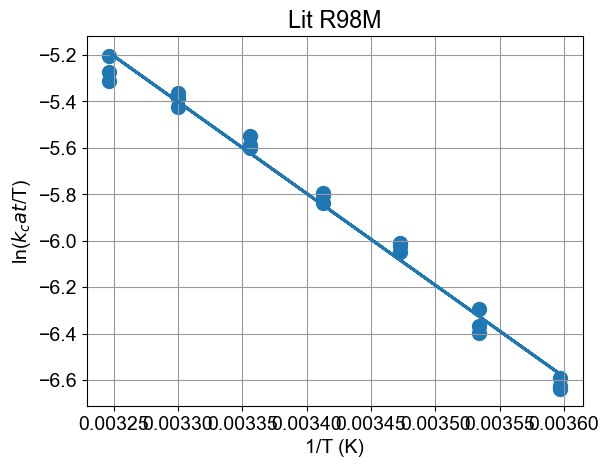

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1405.
Date:                Wed, 08 May 2024   Prob (F-statistic):           2.82e-19
Time:                        18:07:22   Log-Likelihood:                 31.642
No. Observations:                  21   AIC:                            -59.28
Df Residuals:                      19   BIC:                            -57.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6297      0.360     21.181      0.0

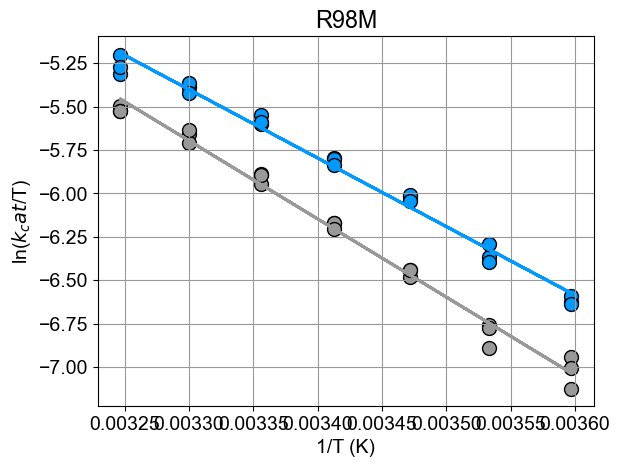

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


dark slopes


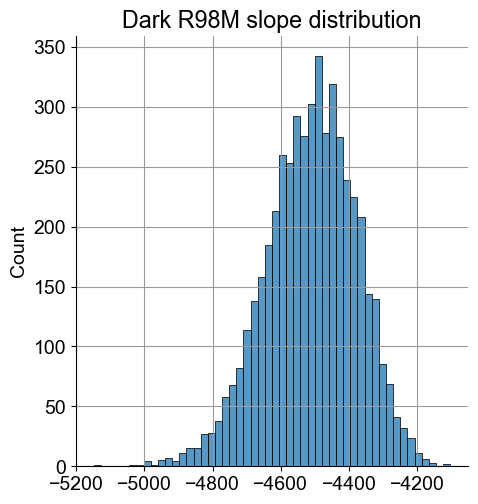


Mean:  -4511.726497717202

std:  133.3304045293998

variance:  17776.996771973394
The 95% confidence interval:  [-4789.22519152 -4271.75057052]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


dark intercepts


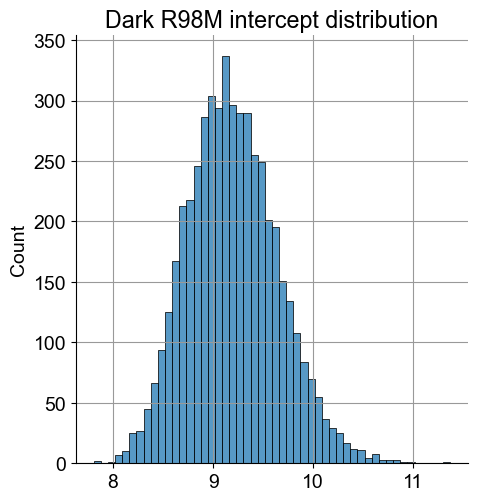


Mean:  9.194200807216315

std:  0.4521144722290746

variance:  0.20440749599897468
The 95% confidence interval:  [ 8.38515773 10.14449713]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


lit slopes


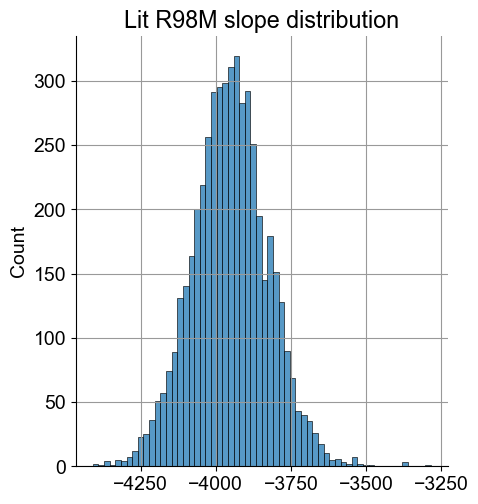


Mean:  -3952.535271785118

std:  126.45278491925592

variance:  15990.306813835597
The 95% confidence interval:  [-4201.97780191 -3701.83687455]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


lit intercepts


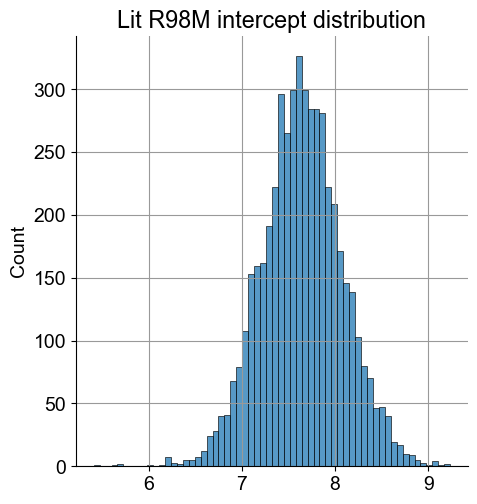


Mean:  7.644407325993192

std:  0.43420255374206174

variance:  0.188531857676128
The 95% confidence interval:  [6.79279322 8.51124882]
dark enthalpy

Mean:  8.9657221100863

std:  0.2649547476871279

variance:  0.07020101832194961
The 95% confidence interval:  [8.48884093 9.5171687 ]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


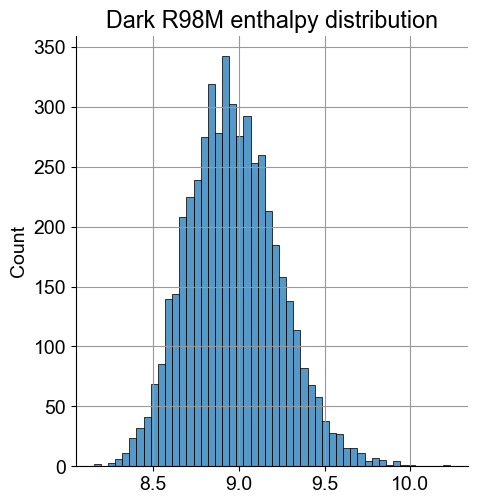

lit enthalpy

Mean:  7.854494924519476

std:  0.25128751270853833

variance:  0.06314541404324381
The 95% confidence interval:  [7.356306   8.35018818]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


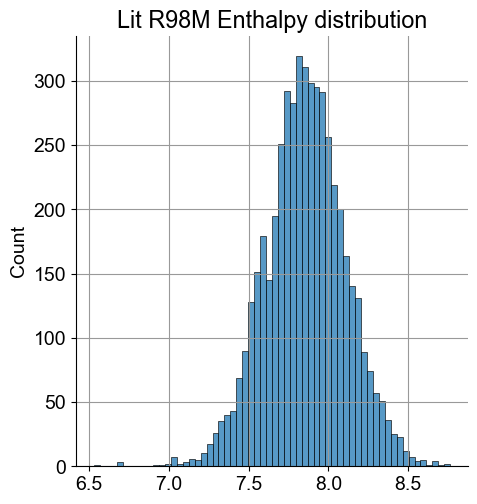

p value that enthalpy are different:  0.0
dark entropy

Mean:  -28.945599082872086

std:  0.8984438046067683

variance:  0.807201270036285
The 95% confidence interval:  [-30.55333294 -27.05716619]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


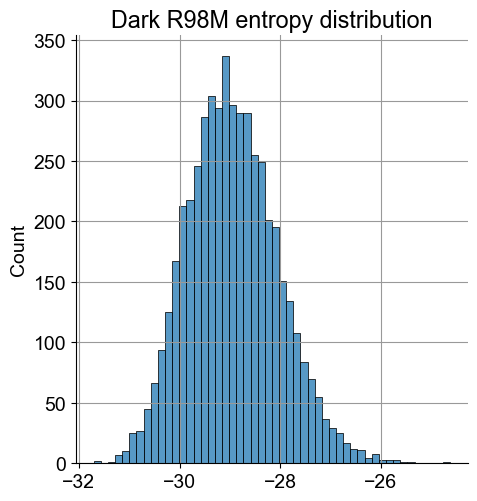

lit entropy

Mean:  -32.02535528877247

std:  0.862849163908949

variance:  0.7445086796583722
The 95% confidence interval:  [-33.71768646 -30.30276419]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


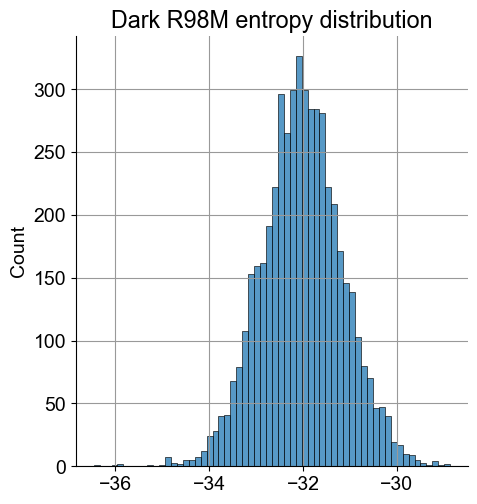

p value that entropy are different:  0.0
kcat_dark

kcat_dark_mean:  0.5141623232969618

std:  0.007169528835857204

variance:  5.1402143728187955e-05
The 95% confidence interval:  [0.50025204 0.52773089]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


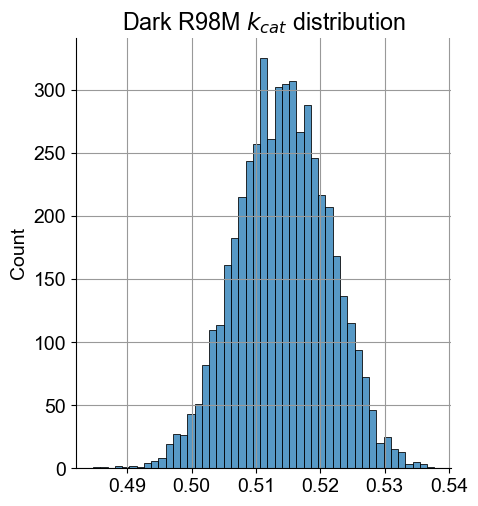

Kcat_lit

kcat lit mean:  0.7481860002117808

std:  0.009263149444048541

variance:  8.580593762277679e-05
The 95% confidence interval:  [0.73079333 0.76727858]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


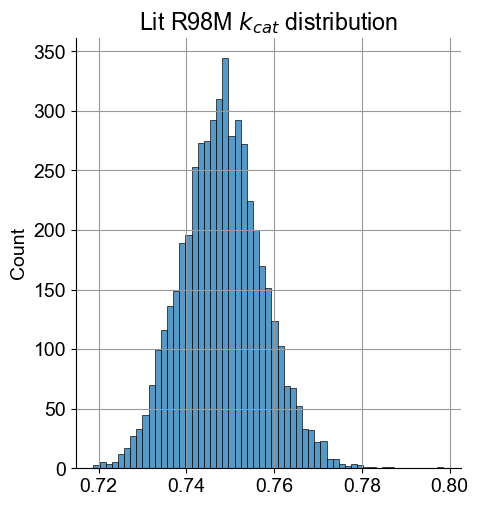

delta G dark

Mean:  17374.41864366064

std:  8.055075422089935

variance:  64.88424005555736
The 95% confidence interval:  [17359.32572643 17390.19558499]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


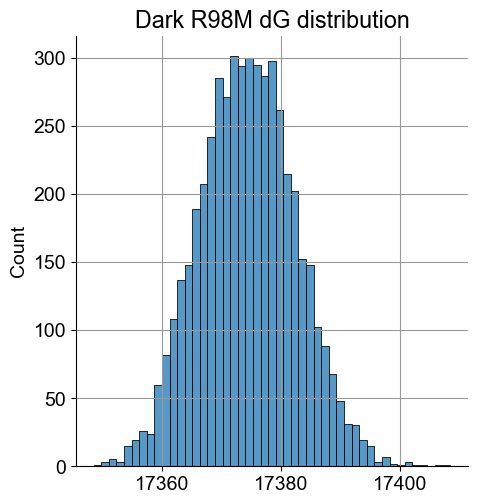

delta G lit

Mean:  17157.86063590788

std:  7.141524444227103

variance:  51.00137138749322
The 95% confidence interval:  [17143.26987821 17171.39465574]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


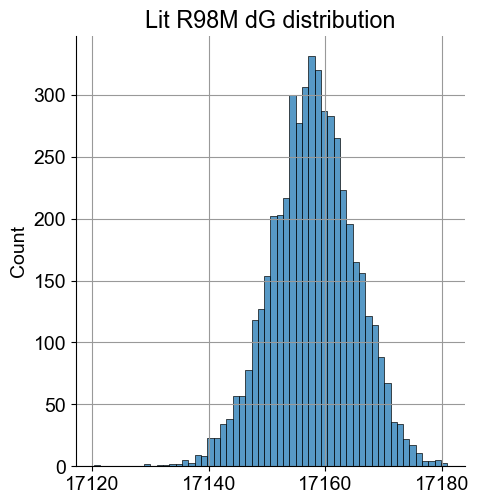

delta G lit - delta G dark (DeltaDeltaG)

Mean:  -216.5580077527617

std:  10.85883658026017

variance:  117.91433187679641
The 95% confidence interval:  [-238.38668691 -195.68983579]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


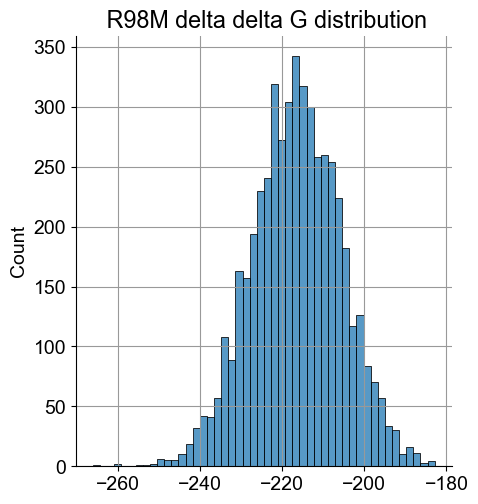

Intercept, x-Slope : Intercept    16867.430483
x               28.944577
dtype: float64
Intercept, x-Slope : Intercept    16596.879599
x               32.025705
dtype: float64


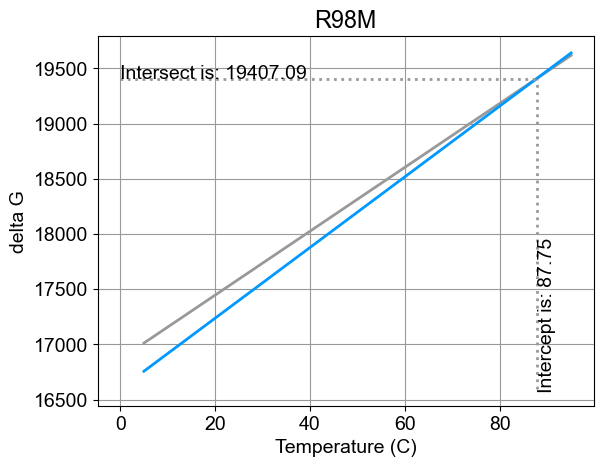

Intercept, x-Slope: 
 Intercept   -269.74996
x              3.07412
dtype: float64
Y Intercept is: 87.75


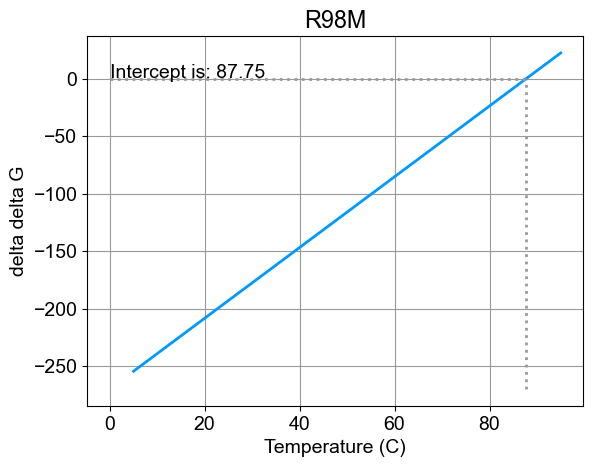

######################## D116M ########################
Intercept, x-Slope : Intercept       5.420185
x           -3248.712939
dtype: float64


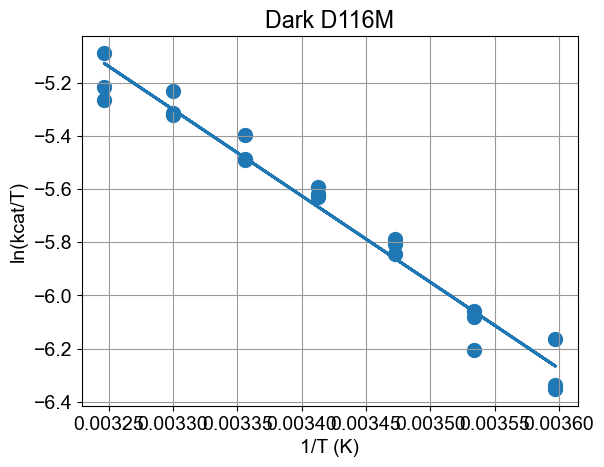

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     550.7
Date:                Wed, 08 May 2024   Prob (F-statistic):           1.71e-15
Time:                        18:11:26   Log-Likelihood:                 25.907
No. Observations:                  21   AIC:                            -47.81
Df Residuals:                      19   BIC:                            -45.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4202      0.473     11.451      0.0

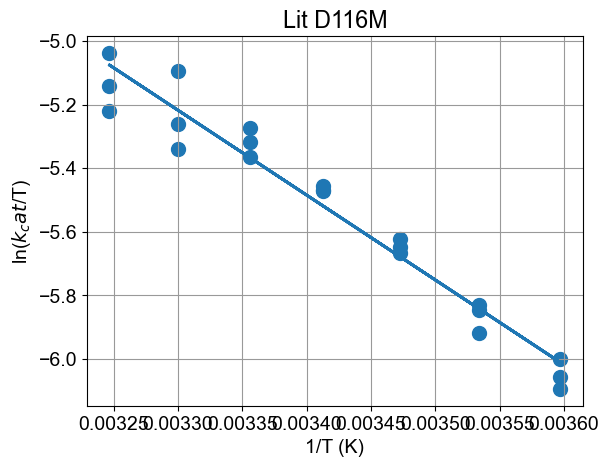

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     398.5
Date:                Wed, 08 May 2024   Prob (F-statistic):           3.29e-14
Time:                        18:11:27   Log-Likelihood:                 26.630
No. Observations:                  21   AIC:                            -49.26
Df Residuals:                      19   BIC:                            -47.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5941      0.457      7.859      0.0

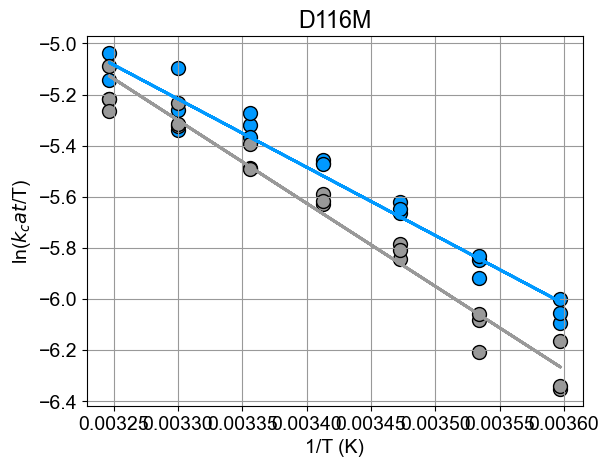

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


dark slopes


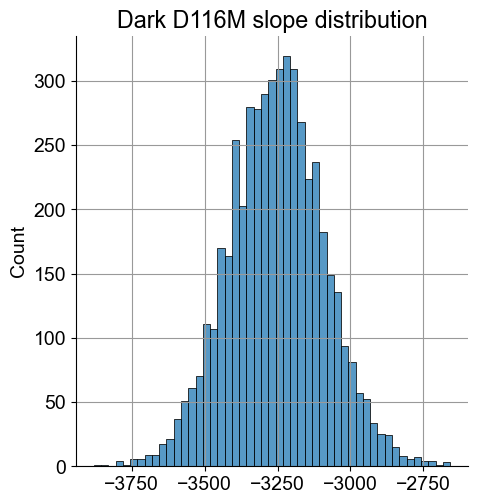


Mean:  -3253.879568876071

std:  163.39999030844712

variance:  26699.556832800616
The 95% confidence interval:  [-3576.15497753 -2928.02564782]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


dark intercepts


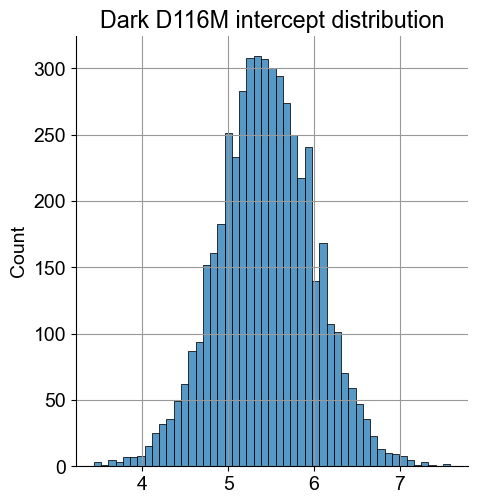


Mean:  5.439391848512998

std:  0.557408534845

variance:  0.31070427471804957
The 95% confidence interval:  [4.33517633 6.54421504]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


lit slopes


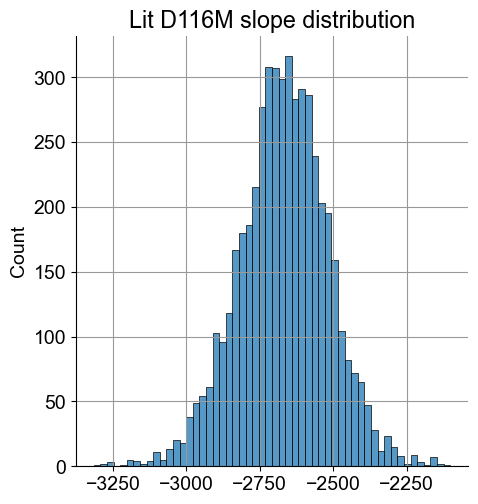


Mean:  -2670.040285510057

std:  152.47838873350236

variance:  23249.659030765055
The 95% confidence interval:  [-2979.22150493 -2378.22918678]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


lit intercepts


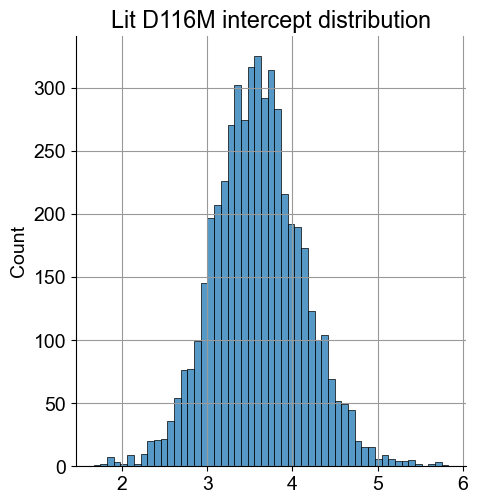


Mean:  3.595327892412084

std:  0.5284364302991003

variance:  0.27924506086725587
The 95% confidence interval:  [2.58915075 4.67321914]
dark enthalpy

Mean:  6.466123336374917

std:  0.3247091566028165

variance:  0.10543603638171241
The 95% confidence interval:  [5.81858504 7.1065504 ]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


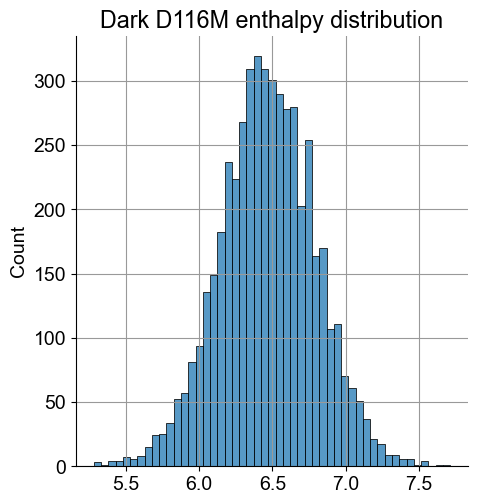

lit enthalpy

Mean:  5.305915426108163

std:  0.30300570344190786

variance:  0.09181245631832542
The 95% confidence interval:  [4.72602717 5.92032166]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


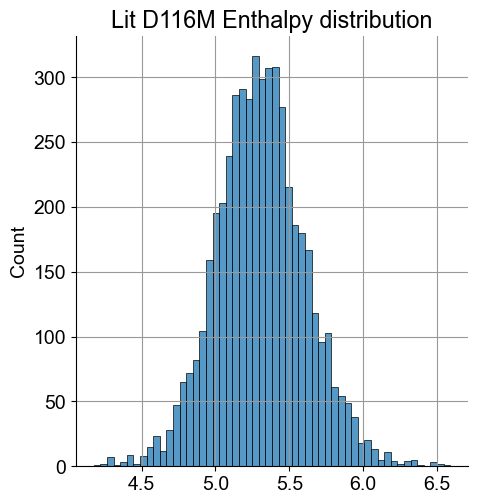

p value that enthalpy are different:  0.0
dark entropy

Mean:  -36.40717143599006

std:  1.1076846142467294

variance:  1.2269652046389259
The 95% confidence interval:  [-38.60147322 -34.21166208]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


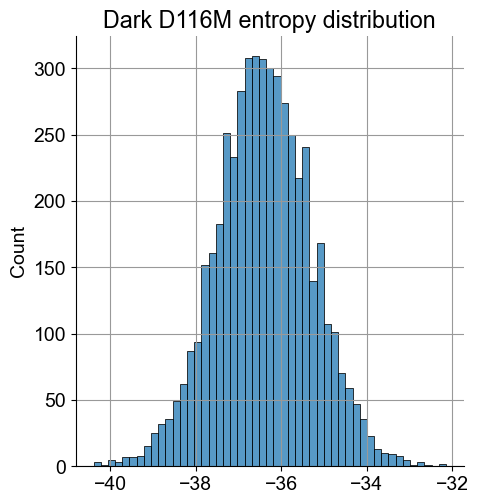

lit entropy

Mean:  -40.07170318275985

std:  1.0501111247113302

variance:  1.1027333742424947
The 95% confidence interval:  [-42.07118269 -37.92971311]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


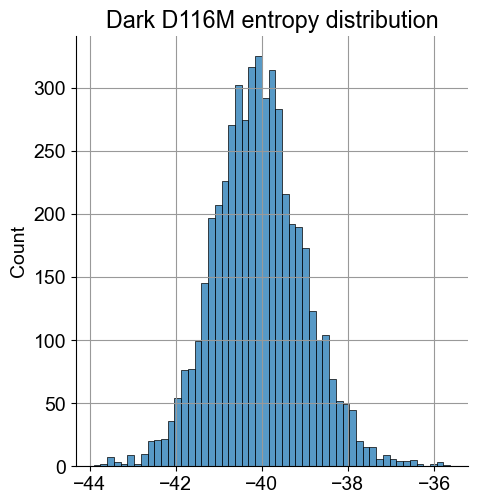

p value that entropy are different:  0.0
kcat_dark

kcat_dark_mean:  0.9138863355385777

std:  0.0150513448050808

variance:  0.0002265429804414328
The 95% confidence interval:  [0.88482149 0.9438065 ]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


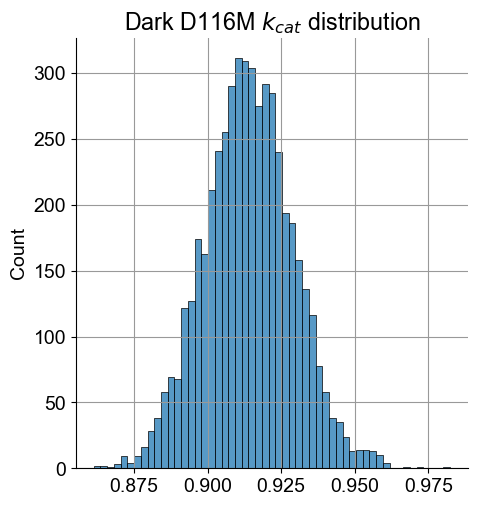

Kcat_lit

kcat lit mean:  1.07856107138607

std:  0.015447038182513972

variance:  0.00023861098861204457
The 95% confidence interval:  [1.04770312 1.10866799]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


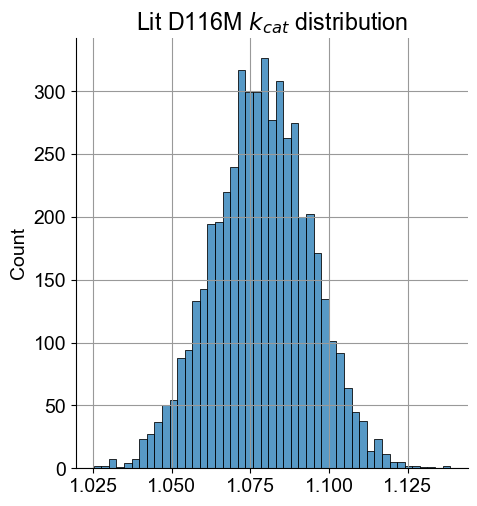

delta G dark

Mean:  17042.40663853003

std:  9.505569396587239

variance:  90.35584955333587
The 95% confidence interval:  [17023.73122799 17060.98631354]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


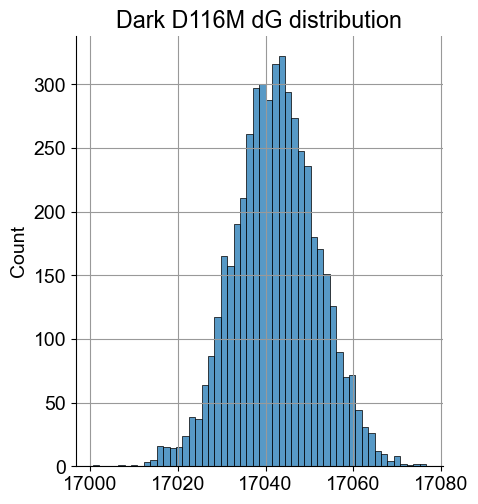

delta G lit

Mean:  16946.745200699897

std:  8.271599915613525

variance:  68.41936516397767
The 95% confidence interval:  [16930.79251397 16963.44306622]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


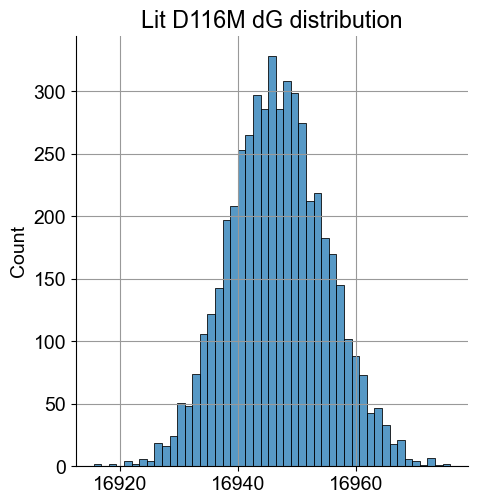

delta G lit - delta G dark (DeltaDeltaG)

Mean:  -95.66143783012885

std:  12.608189708585506

variance:  158.96644772768147
The 95% confidence interval:  [-120.94286624  -70.65008483]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


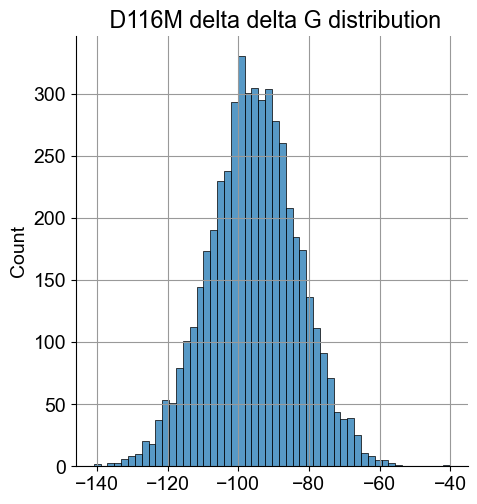

Intercept, x-Slope : Intercept    16404.788501
x               36.407087
dtype: float64
Intercept, x-Slope : Intercept    16244.957477
x               40.072719
dtype: float64


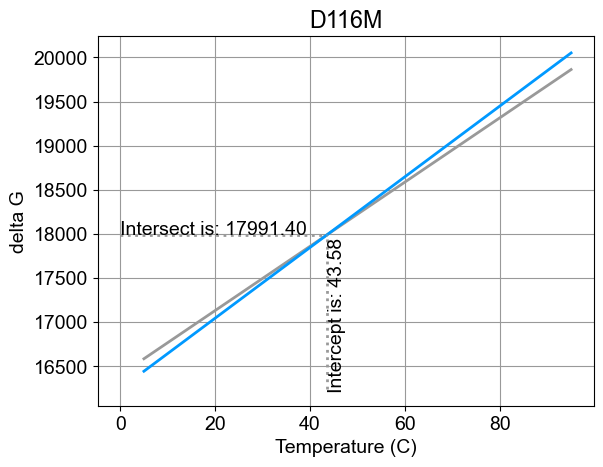

Intercept, x-Slope: 
 Intercept   -159.089345
x              3.650358
dtype: float64
Y Intercept is: 43.58


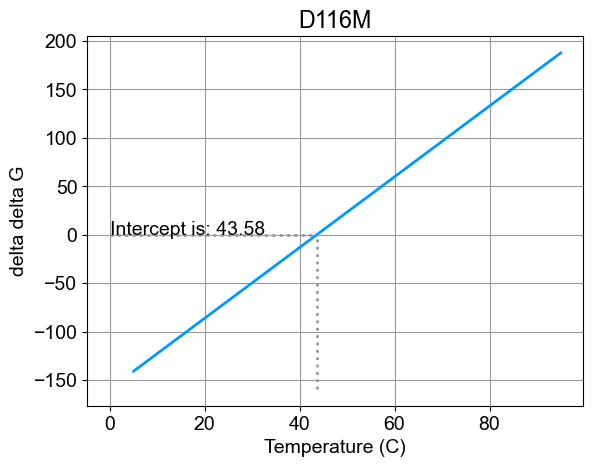

######################## H124Q ########################
Intercept, x-Slope : Intercept       8.710198
x           -4476.499734
dtype: float64


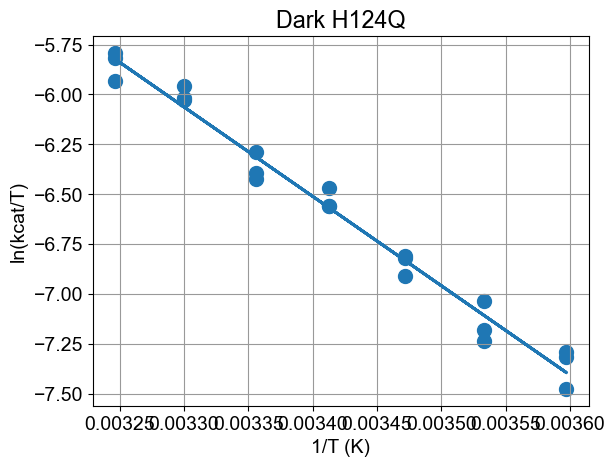

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     946.7
Date:                Wed, 08 May 2024   Prob (F-statistic):           1.13e-17
Time:                        18:15:46   Log-Likelihood:                 24.864
No. Observations:                  21   AIC:                            -45.73
Df Residuals:                      19   BIC:                            -43.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.7102      0.497     17.511      0.0

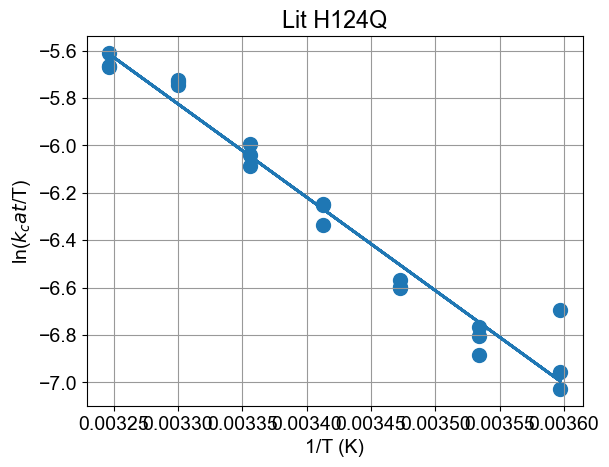

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     467.9
Date:                Wed, 08 May 2024   Prob (F-statistic):           7.63e-15
Time:                        18:15:46   Log-Likelihood:                 20.161
No. Observations:                  21   AIC:                            -36.32
Df Residuals:                      19   BIC:                            -34.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.1670      0.622     11.517      0.0

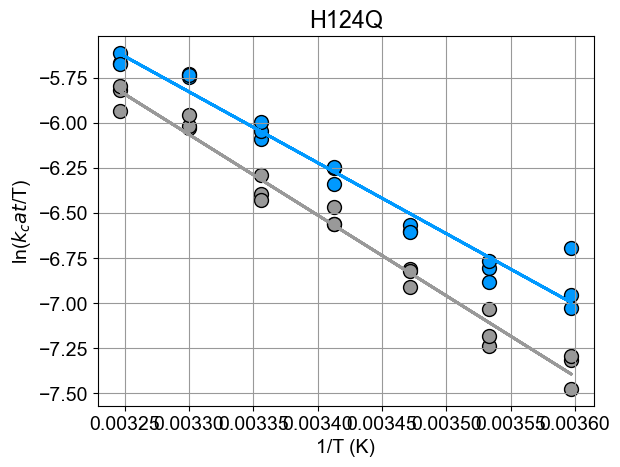

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


dark slopes


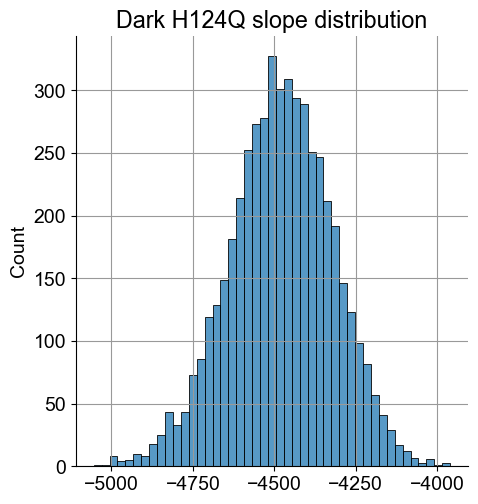


Mean:  -4480.066102968125

std:  157.82707341022464

variance:  24909.38510123644
The 95% confidence interval:  [-4808.87920219 -4184.69105462]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


dark intercepts


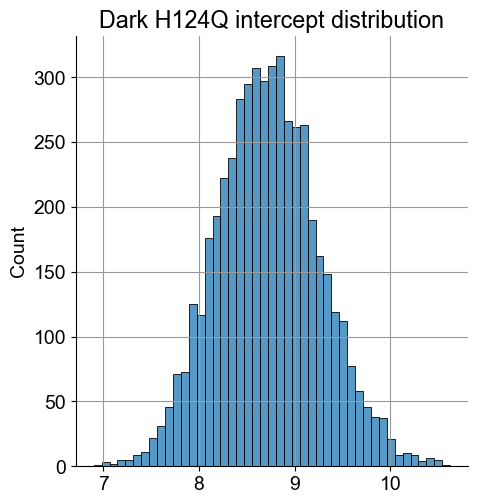


Mean:  8.722261363349846

std:  0.5365902625946068

variance:  0.2879291099113492
The 95% confidence interval:  [7.71331653 9.84063864]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


lit slopes


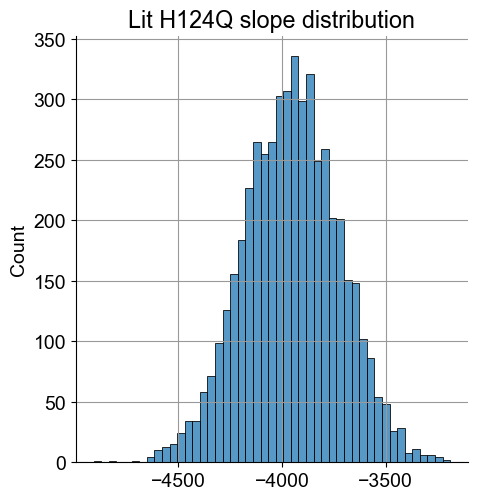


Mean:  -3954.026726130241

std:  230.00002449024623

variance:  52900.01126551387
The 95% confidence interval:  [-4408.37553109 -3507.5311249 ]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


lit intercepts


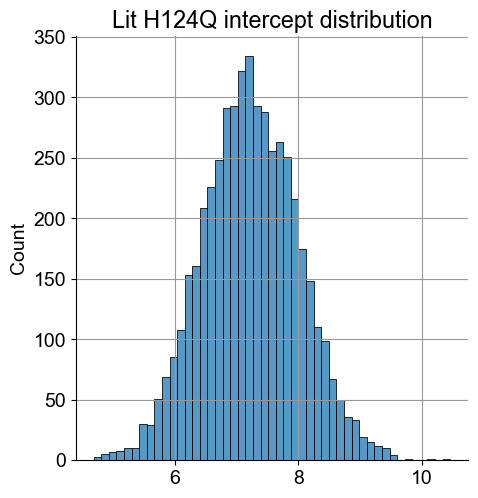


Mean:  7.223908819619613

std:  0.7738567528451865

variance:  0.5988542739240961
The 95% confidence interval:  [5.72956096 8.76096503]
dark enthalpy

Mean:  8.902806438810687

std:  0.3136346324096173

variance:  0.09836668264671579
The 95% confidence interval:  [8.31583588 9.55622523]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


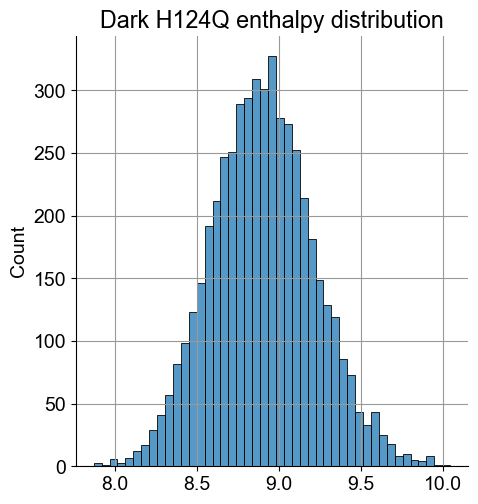

lit enthalpy

Mean:  7.857458748945672

std:  0.45705702815451255

variance:  0.2089011269854349
The 95% confidence interval:  [6.97018079 8.76034263]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


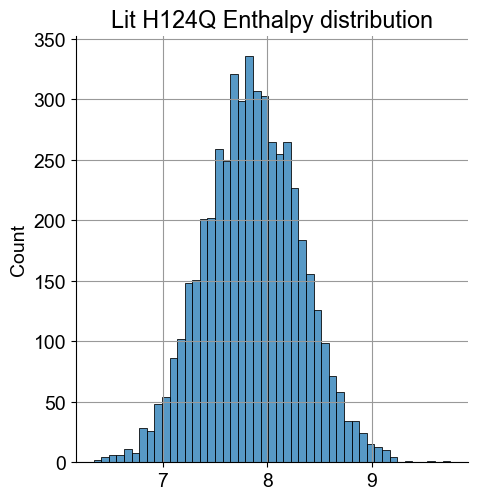

p value that enthalpy are different:  0.0
dark entropy

Mean:  -29.883439155544114

std:  1.0663144549732042

variance:  1.1370265168848015
The 95% confidence interval:  [-31.88841863 -27.66099506]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


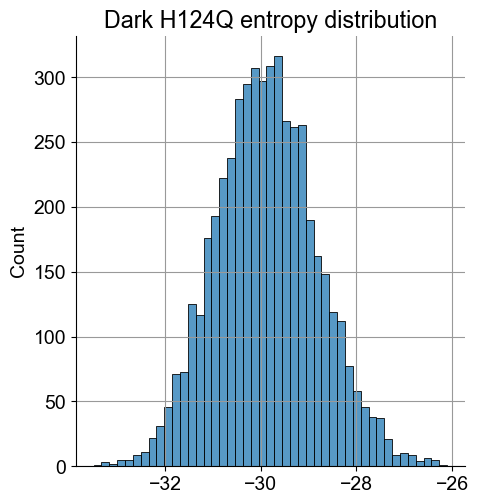

lit entropy

Mean:  -32.86097171139015

std:  1.537811434831919

variance:  2.364864009099805
The 95% confidence interval:  [-35.83054614 -29.80652706]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


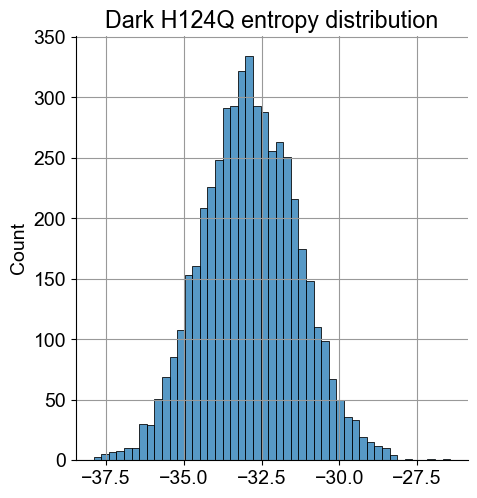

p value that entropy are different:  0.0
kcat_dark

kcat_dark_mean:  0.35768167294562775

std:  0.006302240560817045

variance:  3.9718236086407546e-05
The 95% confidence interval:  [0.34550568 0.36997275]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


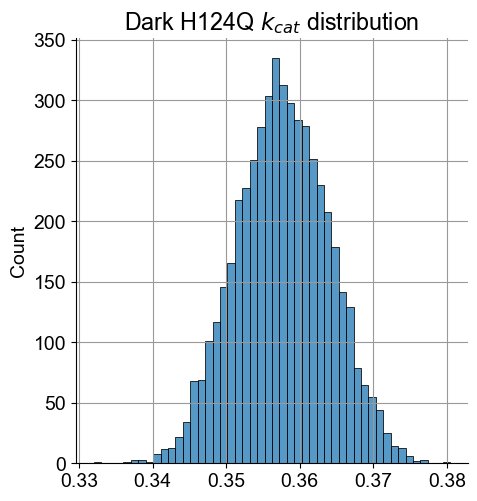

Kcat_lit

kcat lit mean:  0.4889442098916991

std:  0.012131214699226652

variance:  0.00014716637007873278
The 95% confidence interval:  [0.46804196 0.51521191]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


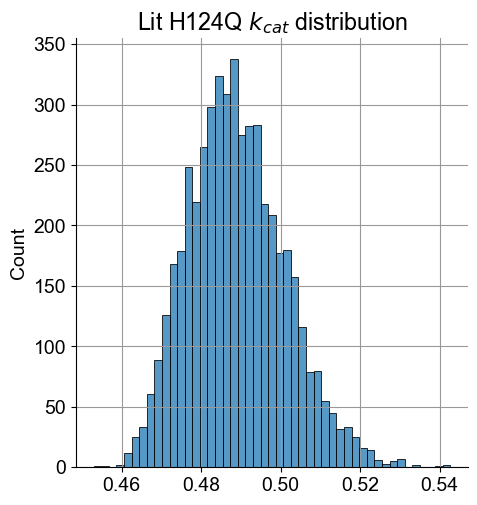

delta G dark

Mean:  17583.945513496248

std:  10.17623331014004

variance:  103.55572438240371
The 95% confidence interval:  [17564.35180439 17603.84965834]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


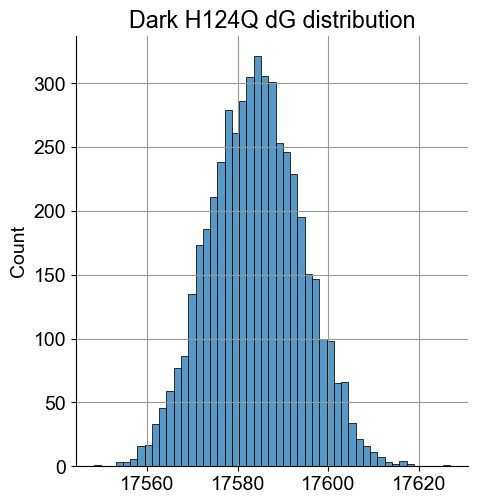

delta G lit

Mean:  17403.571031104515

std:  14.26125549502386

variance:  203.38340829434824
The 95% confidence interval:  [17373.18523942 17428.6161259 ]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


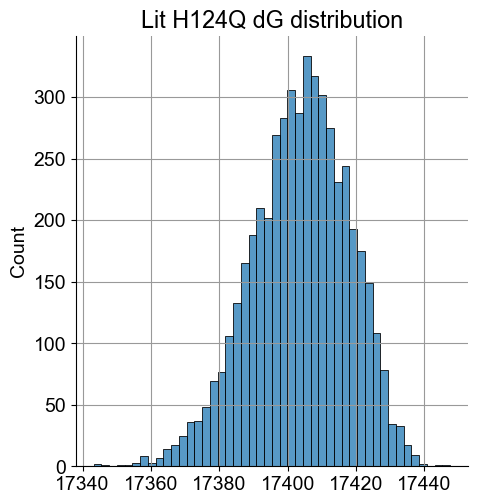

delta G lit - delta G dark (DeltaDeltaG)

Mean:  -180.37448239173753

std:  17.309785248612762

variance:  299.628665353092
The 95% confidence interval:  [-215.62588901 -148.35953143]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


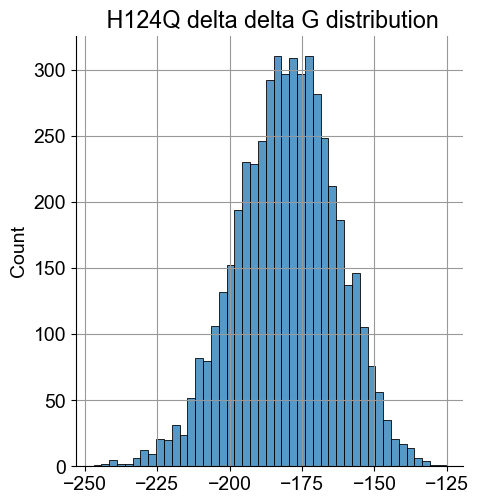

Intercept, x-Slope : Intercept    17060.509635
x               29.883214
dtype: float64
Intercept, x-Slope : Intercept    16828.014811
x               32.860583
dtype: float64


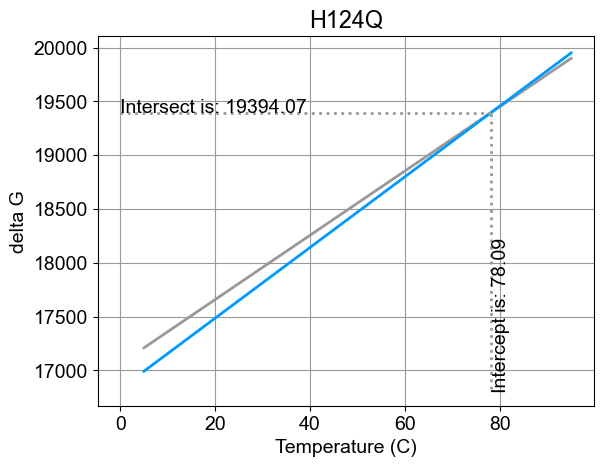

Intercept, x-Slope: 
 Intercept   -231.537824
x              2.965042
dtype: float64
Y Intercept is: 78.09


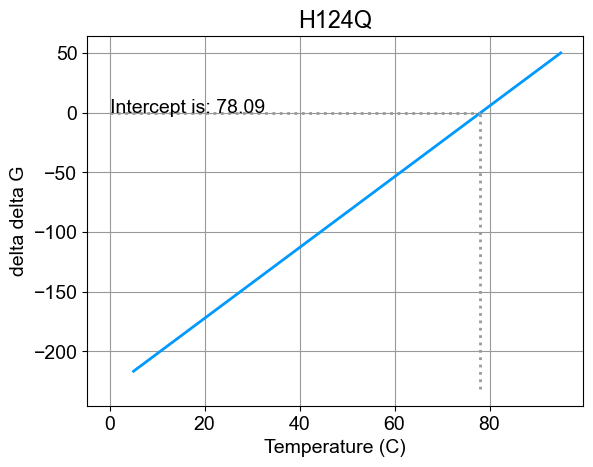

######################## D127W ########################
Intercept, x-Slope : Intercept       7.229930
x           -4203.857861
dtype: float64


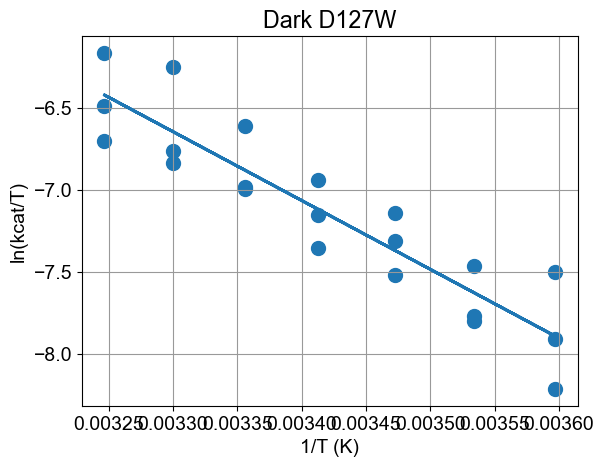

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     101.2
Date:                Wed, 08 May 2024   Prob (F-statistic):           4.80e-09
Time:                        18:19:40   Log-Likelihood:                 2.7030
No. Observations:                  21   AIC:                            -1.406
Df Residuals:                      19   BIC:                            0.6830
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2299      1.429      5.059      0.0

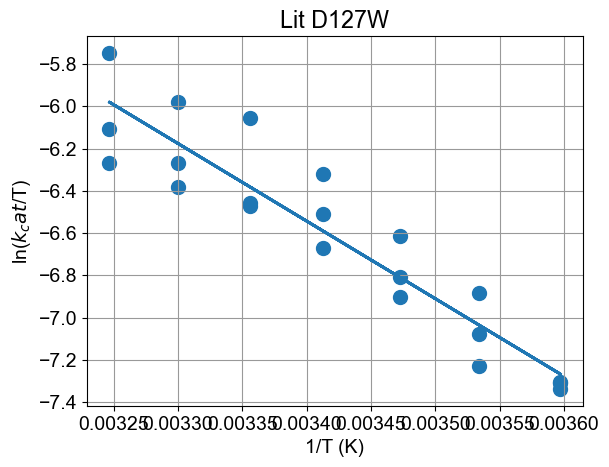

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     129.1
Date:                Wed, 08 May 2024   Prob (F-statistic):           6.48e-10
Time:                        18:19:40   Log-Likelihood:                 8.0977
No. Observations:                  21   AIC:                            -12.20
Df Residuals:                      19   BIC:                            -10.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9455      1.105      5.379      0.0

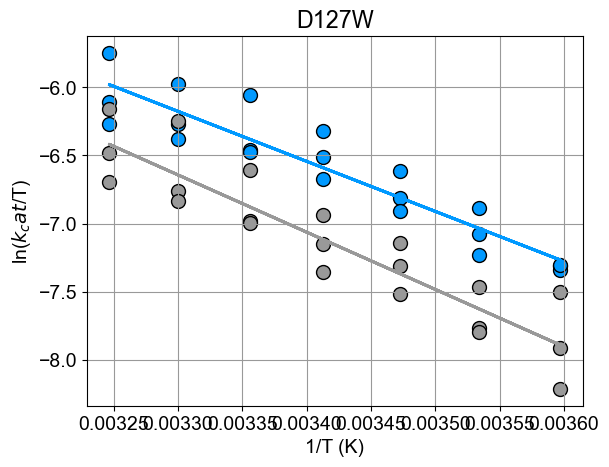

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


dark slopes


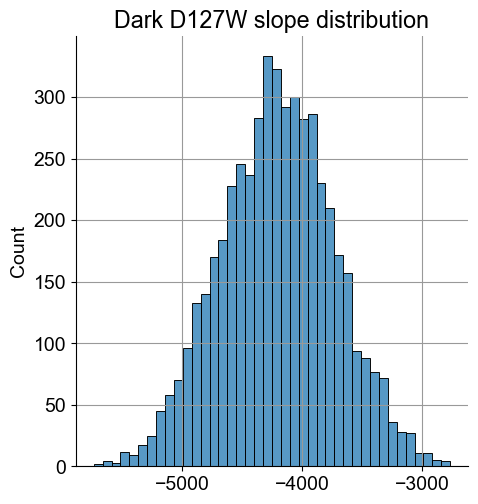


Mean:  -4206.784543181113

std:  472.03242402796707

variance:  222814.6093337185
The 95% confidence interval:  [-5131.16517693 -3293.00127675]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


dark intercepts


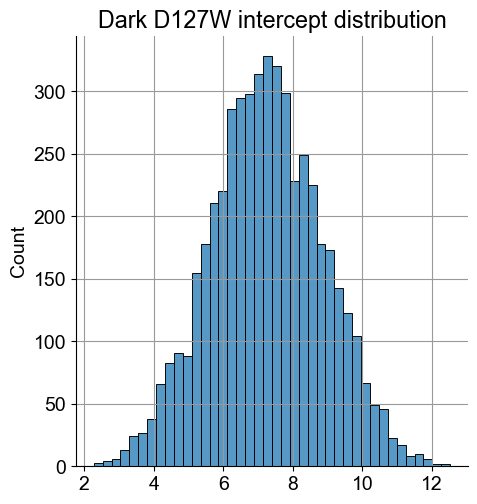


Mean:  7.2395022991199305

std:  1.6128446057407433

variance:  2.6012677222670133
The 95% confidence interval:  [ 4.11085059 10.38269427]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


lit slopes


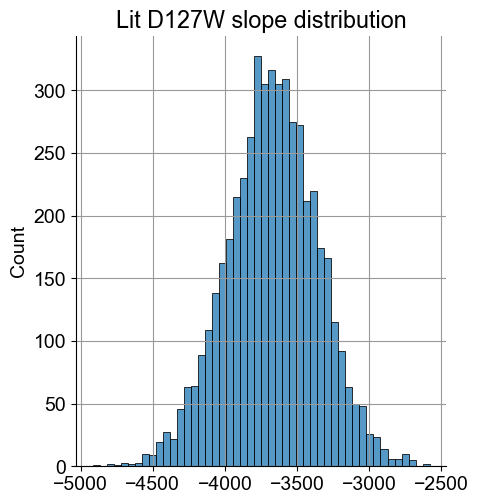


Mean:  -3670.5298698825227

std:  316.4554780181965

variance:  100144.06956772525
The 95% confidence interval:  [-4308.09055964 -3056.00744661]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


lit intercepts


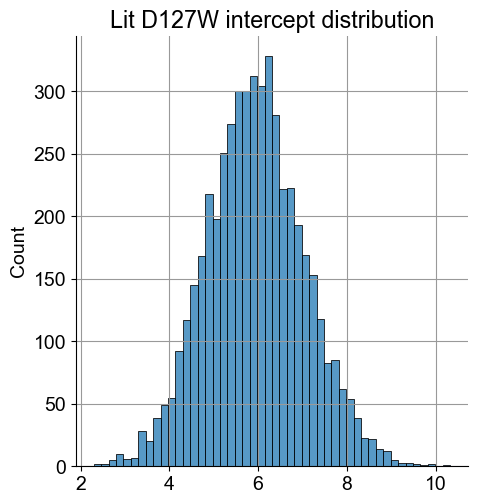


Mean:  5.938289528680005

std:  1.0979462184403634

variance:  1.205485898587494
The 95% confidence interval:  [3.82251146 8.15392649]
dark enthalpy

Mean:  8.359740159393926

std:  0.9380248432449303

variance:  0.879890606544676
The 95% confidence interval:  [ 6.54386616 10.19667329]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


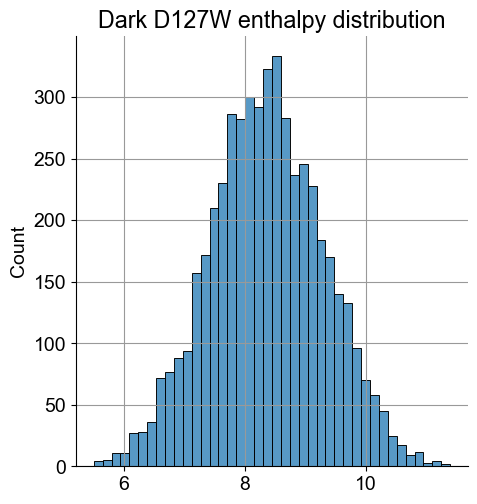

lit enthalpy

Mean:  7.294092588898919

std:  0.6288616735879797

variance:  0.39546700450787475
The 95% confidence interval:  [6.07291101 8.56105591]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


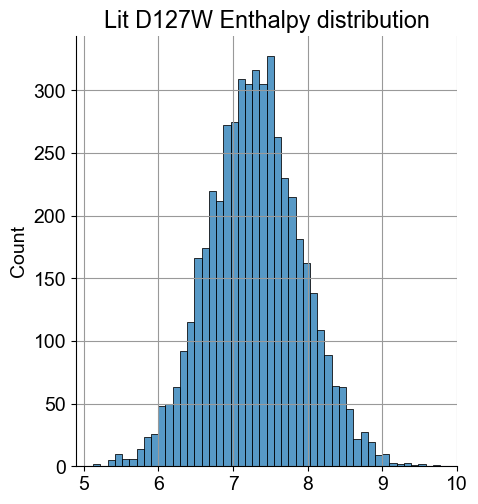

p value that enthalpy are different:  0.0
dark entropy

Mean:  -32.829984282520094

std:  3.205051669053895

variance:  10.27235620130516
The 95% confidence interval:  [-39.04725429 -26.58381981]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


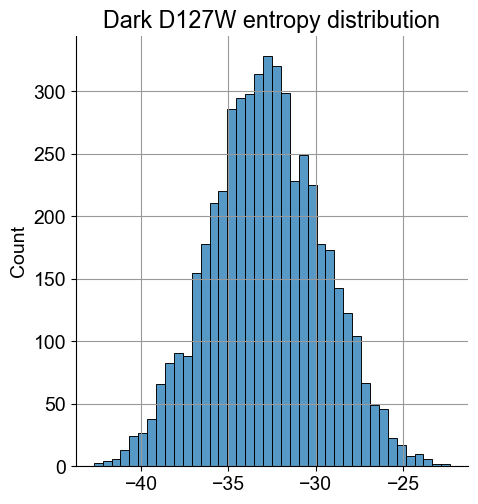

lit entropy

Mean:  -35.41575984133615

std:  2.181843401043285

variance:  4.760440626676129
The 95% confidence interval:  [-39.62024303 -31.01283665]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


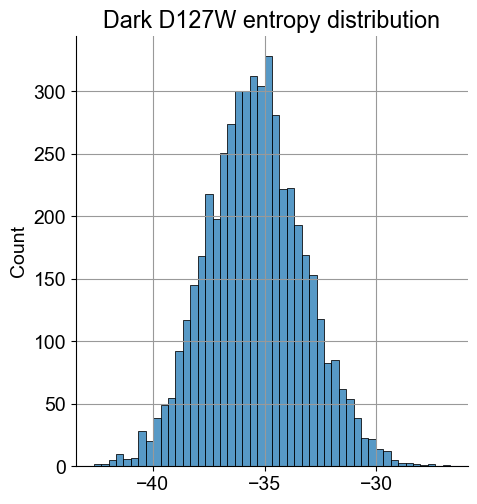

p value that entropy are different:  0.0
kcat_dark

kcat_dark_mean:  0.20822949746377958

std:  0.010148635106345592

variance:  0.0001029947945217502
The 95% confidence interval:  [0.18947574 0.22898449]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


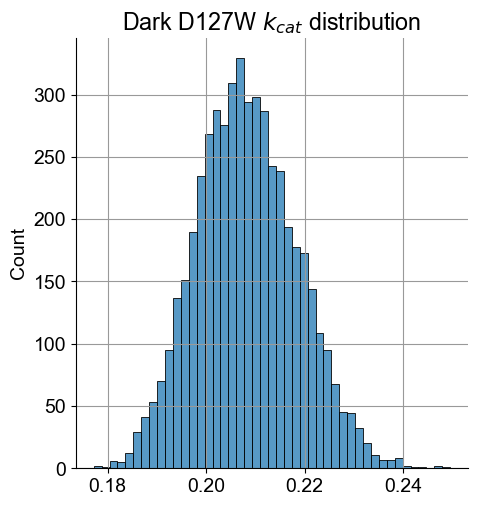

Kcat_lit

kcat lit mean:  0.3588110985211645

std:  0.012242917821076168

variance:  0.0001498890367736244
The 95% confidence interval:  [0.33677827 0.38381818]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


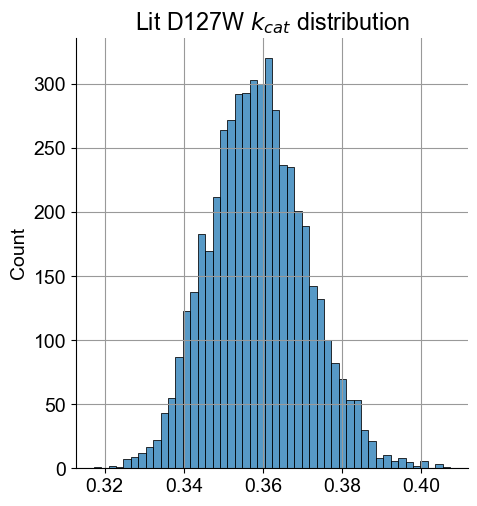

delta G dark

Mean:  17896.850593466013

std:  28.070406998519797

variance:  787.9477490625492
The 95% confidence interval:  [17841.31768854 17950.65117559]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


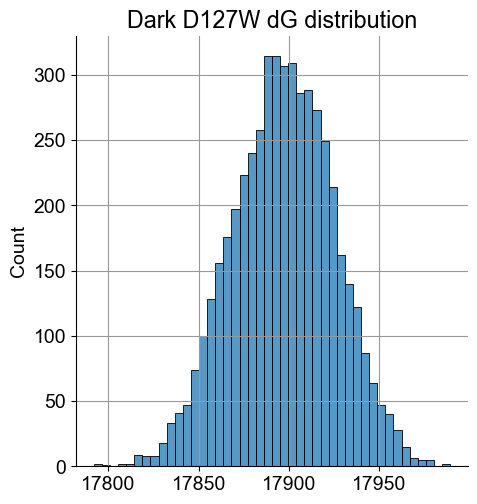

delta G lit

Mean:  17582.37082280707

std:  19.651728838070408

variance:  386.1904463250481
The 95% confidence interval:  [17543.14266801 17618.61904767]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


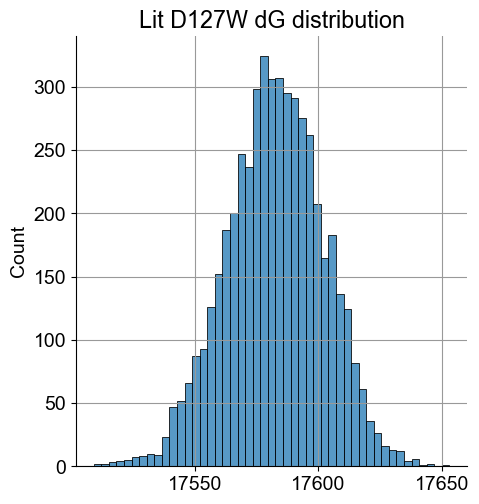

delta G lit - delta G dark (DeltaDeltaG)

Mean:  -314.4797706589424

std:  34.48460891899672

variance:  1189.1882522961482
The 95% confidence interval:  [-381.66273406 -246.33404508]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


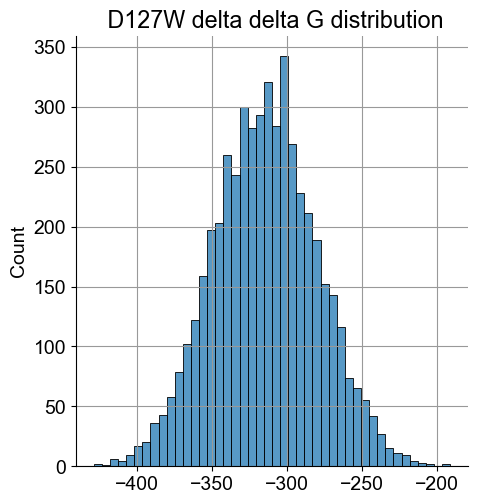

Intercept, x-Slope : Intercept    17321.806339
x               32.830467
dtype: float64
Intercept, x-Slope : Intercept    16962.039019
x               35.416802
dtype: float64


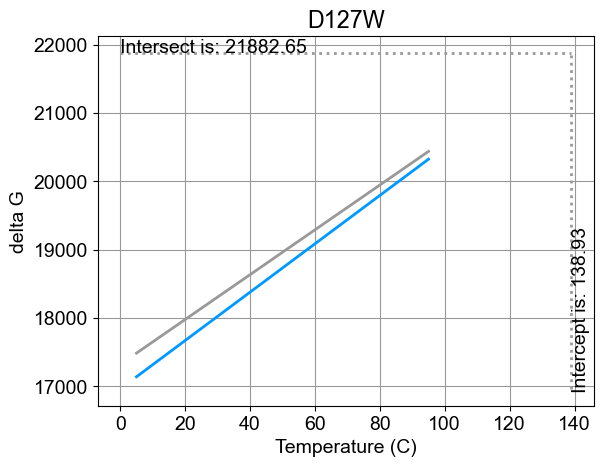

Intercept, x-Slope: 
 Intercept   -359.222806
x              2.585555
dtype: float64
Y Intercept is: 138.93


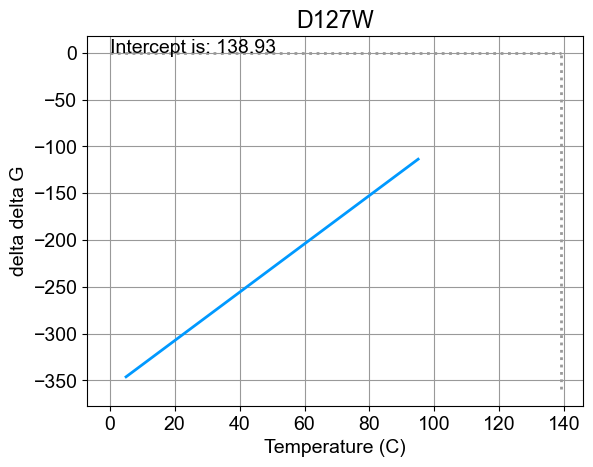

mutant                                   csv  dark_enthalpy_mean  \
0  DL121  ./input_data/eyring/dl121_eyring.csv           12.620982   
0    A9N    ./input_data/eyring/a9n_eyring.csv           10.496567   
0   M16A   ./input_data/eyring/m16a_eyring.csv           12.962628   
0   M16P   ./input_data/eyring/m16p_eyring.csv           13.149161   
0   G86K   ./input_data/eyring/g86k_eyring.csv            8.331798   
0   D87A   ./input_data/eyring/d87a_eyring.csv           11.653660   
0   R98M   ./input_data/eyring/r98m_eyring.csv            8.965722   
0  D116M  ./input_data/eyring/d116m_eyring.csv            6.466123   
0  H124Q  ./input_data/eyring/h124q_eyring.csv            8.902806   
0  D127W  ./input_data/eyring/d127w_eyring.csv            8.359740   

   dark_enthalpy_std  dark_entropy_mean  dark_entropy_std  lit_enthalpy_mean  \
0           0.166070         -17.336830          0.565841          10.930935   
0           0.515440         -23.806088          1.769232           7.895299   
0           0.703225         -17.839946          2.356621          11.319455   
0           0.643599         -20.207702          2.155271          11.749964   
0           0.252919         -31.999860          0.860275           7.636738   
0           0.389686         -20.096344          1.324539           9.512543   
0           0.264955         -28.945599          0.898444           7.854495   
0           0.324709         -36.407171          1.107685           5.305915   
0           0.313635         -29.883439          1.066314           7.857459   
0           0.938025         -32.829984          3.205052           7.294093   

   lit_enthalpy_std  lit_entropy_mean  lit_entropy_std  ...  \
0          0.454796        -22.491616         1.544976  ...   
0          0.886468        -31.855559         2.991108  ...   
0          0.488310        -22.647228         1.653613  ...   
0          0.852421        -24.789402         2.854290  ...   
0          0.273583        -33.859244         0.926446  ...   
0          0.437167        -26.953879         1.504028  ...   
0          0.251288        -32.025355         0.862849  ...   
0          0.303006        -40.071703         1.050111  ...   
0          0.457057        -32.860972         1.537811  ...   
0          0.628862        -35.415760         2.181843  ...   

   calculated_intersect  calculated_intercept  delta_entropy_mean  \
0          18304.703027             54.867876        -1497.465453   
0          18189.329256             50.162801        -2338.371255   
0          19060.203689             68.819474        -1396.515395   
0          19319.492122             32.374511        -1330.983877   
0          20283.817535            100.533497         -540.150991   
0          17927.531263             39.217897        -1992.113782   
0          19407.092714             87.748674         -894.669178   
0          17991.400424             43.581843        -1064.546472   
0          19394.072004             78.089217         -864.973207   
0          21882.654861            138.934504         -751.167800   

   delta_entropy_std  delta_enthalpy_mean  delta_enthalpy_std  \
0         474.760246         -1690.047382          480.931254   
0        1009.232453         -2601.268679         1024.865241   
0         838.196078         -1643.173159          857.759010   
0        1031.951177         -1399.197579         1060.877516   
0         367.315708          -695.060733          372.366274   
0         582.866508         -2141.116810          586.275920   
0         363.489686         -1111.227186          366.875908   
0         445.222098         -1160.207910          445.666309   
0         544.398093         -1045.347690          554.981439   
0        1129.042620         -1065.647570         1131.630181   

   ddelta_entropy_mean  ddelta_entropy_std  ddelta_enthalpy_mean  \
0             0.000000            0.000000              0.000000   
0          -840.905801         1116.014129  

In [17]:
######For temperatures 5 through 35C with 5000 iterations of bootstrapping#########

energetics_df_all = pd.DataFrame()

mutant = ('DL121','A9N','M16A','M16P','G86K',\
          'D87A','R98M','D116M','H124Q','D127W')

csv_name = ("./input_data/eyring/dl121_eyring.csv",\
            "./input_data/eyring/a9n_eyring.csv",\
            "./input_data/eyring/m16a_eyring.csv",\
            "./input_data/eyring/m16p_eyring.csv",\
            "./input_data/eyring/g86k_eyring.csv",\
            "./input_data/eyring/d87a_eyring.csv",\
            "./input_data/eyring/r98m_eyring.csv",\
            "./input_data/eyring/d116m_eyring.csv",\
            "./input_data/eyring/h124q_eyring.csv",\
            "./input_data/eyring/d127w_eyring.csv")



for idx, mut in enumerate(mutant):
    
    print('######################## %s ########################' % mut)
    if mut == 'DL121':
        dark_enthalpy_mean, dark_enthalpy_std, dark_entropy_mean, dark_entropy_std, \
        lit_enthalpy_mean, lit_enthalpy_std, lit_entropy_mean, lit_entropy_std, \
        kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std, \
        dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std, ddelta_G_mean, ddelta_G_std, \
        calculated_intersect, calculated_intercept, \
        delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std, \
        ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std, \
        dark_enthalpy_list_DL121, dark_entropy_list_DL121, lit_enthalpy_list_DL121, lit_entropy_list_DL121 \
        = enthalpy_entropy_looper_DL121(csv_name[idx],5000,0,7,17.5,mut,"no") #In the looping function the input values correspond to:
    else:
##this is the function of functions from the cell above. 
        dark_enthalpy_mean, dark_enthalpy_std, dark_entropy_mean, dark_entropy_std, \
        lit_enthalpy_mean, lit_enthalpy_std, lit_entropy_mean, lit_entropy_std, \
        kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std, \
        dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std, ddelta_G_mean, ddelta_G_std, \
        calculated_intersect, calculated_intercept, \
        delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std,\
        ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std \
        = enthalpy_entropy_looper(csv_name[idx],5000,0,7,17.5,mut,"no", \
                                 dark_enthalpy_list_DL121, dark_entropy_list_DL121, \
                                  lit_enthalpy_list_DL121, lit_entropy_list_DL121) #In the looping function the input values correspond to:
    #1st entry is path to the CSV name
    #3rd and 4th numbers are temp discernment 0=5, 7=35,
    #5th number is temp in C
    #6th is the mutation name, dont change
    #7th is if to save the figure
    #5000 bootstraps takes ~15 minutes
    
    temp = pd.DataFrame([[mutant[idx],csv_name[idx],\
                              dark_enthalpy_mean,dark_enthalpy_std,dark_entropy_mean,dark_entropy_std,\
                                     lit_enthalpy_mean,lit_enthalpy_std,lit_entropy_mean,lit_entropy_std,\
                         kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std,\
                         dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std, ddelta_G_mean, ddelta_G_std,\
                         calculated_intersect, calculated_intercept,\
                         delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std,\
                         ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std]],\
                            columns=['mutant','csv',\
                                     'dark_enthalpy_mean','dark_enthalpy_std','dark_entropy_mean','dark_entropy_std',\
                                     'lit_enthalpy_mean','lit_enthalpy_std','lit_entropy_mean','lit_entropy_std',\
                                    'kcat_dark_mean', 'kcat_dark_std', 'kcat_lit_mean', 'kcat_lit_std', 'kcat_ratio_mean', 'kcat_ratio_std',\
                                    'dG_dark_mean', 'dG_dark_std', 'dG_lit_mean', 'dG_lit_std', 'ddelta_G_mean', 'ddelta_G_std',\
                                    'calculated_intersect', 'calculated_intercept',\
                                    'delta_entropy_mean', 'delta_entropy_std', 'delta_enthalpy_mean', 'delta_enthalpy_std',\
                                    'ddelta_entropy_mean', 'ddelta_entropy_std', 'ddelta_enthalpy_mean', 'ddelta_enthalpy_std'])

    energetics_df_all = pd.concat([energetics_df_all, temp])
#save out    
#energetics_df_all.to_csv('./output/energetics_df_5-35C_5000boot_17.5.csv')

energetics_df_all

This section runs the functions for each proten, plots them, calls the energetics calculations, and saves them into a 
pandas dataframe named energetics_df. This is done for kinetics measurments between 10 and 35C with 5000 iterations of boostrapping.
The point of this second section is to have a second dataframe to allow checking on the effect of 5C samples, which may suffer from "cold denaturation".

In [ ]:
#For temperatures 10 through 35C with 5000 iterations of boostrapping

energetics_df = pd.DataFrame()

mutant = ('DL121','A9N','M16A','M16P','G86K',\
          'D87A','R98M','D116M','H124Q','D127W')

csv_name = ("./input_data/eyring/dl121_eyring.csv",\
            "./input_data/eyring/a9n_eyring.csv",\
            "./input_data/eyring/m16a_eyring.csv",\
            "./input_data/eyring/m16p_eyring.csv",\
            "./input_data/eyring/g86k_eyring.csv",\
            "./input_data/eyring/d87a_eyring.csv",\
            "./input_data/eyring/r98m_eyring.csv",\
            "./input_data/eyring/d116m_eyring.csv",\
            "./input_data/eyring/h124q_eyring.csv",\
            "./input_data/eyring/d127w_eyring.csv")



for idx, mut in enumerate(mutant):
    
    print('######################## %s ########################' % mut)
    if mut == 'DL121':
        dark_enthalpy_mean, dark_enthalpy_std, dark_entropy_mean, dark_entropy_std, \
        lit_enthalpy_mean, lit_enthalpy_std, lit_entropy_mean, lit_entropy_std, \
        kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std, \
        dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std, ddelta_G_mean, ddelta_G_std, \
        calculated_intersect, calculated_intercept, \
        delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std, \
        ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std, \
        dark_enthalpy_list_DL121, dark_entropy_list_DL121, lit_enthalpy_list_DL121, lit_entropy_list_DL121 \
        = enthalpy_entropy_looper_DL121(csv_name[idx],5000,1,7,30,mut,"no") #In the looping function the input values correspond to:
    else:
##this is the function of functions from the cell above. 
        dark_enthalpy_mean, dark_enthalpy_std, dark_entropy_mean, dark_entropy_std, \
        lit_enthalpy_mean, lit_enthalpy_std, lit_entropy_mean, lit_entropy_std, \
        kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std, \
        dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std, ddelta_G_mean, ddelta_G_std, \
        calculated_intersect, calculated_intercept, \
        delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std,\
        ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std \
        = enthalpy_entropy_looper(csv_name[idx],5000,1,7,30,mut,"no", \
                                 dark_enthalpy_list_DL121, dark_entropy_list_DL121, \
                                  lit_enthalpy_list_DL121, lit_entropy_list_DL121) #In the looping function the input values correspond to:
    #1st entry is path to the CSV name
    #3rd and 4th numbers are temp discernment 0=5, 7=35,
    #5th number is temp in C
    #6th is the mutation name, dont change
    #7th is if to save the figure
    #5000 bootstraps takes ~15 minutes
    
    temp = pd.DataFrame([[mutant[idx],csv_name[idx],\
                              dark_enthalpy_mean,dark_enthalpy_std,dark_entropy_mean,dark_entropy_std,\
                                     lit_enthalpy_mean,lit_enthalpy_std,lit_entropy_mean,lit_entropy_std,\
                         kcat_dark_mean, kcat_dark_std, kcat_lit_mean, kcat_lit_std, kcat_ratio_mean, kcat_ratio_std,\
                         dG_dark_mean, dG_dark_std, dG_lit_mean, dG_lit_std, ddelta_G_mean, ddelta_G_std,\
                         calculated_intersect, calculated_intercept,\
                         delta_entropy_mean, delta_entropy_std, delta_enthalpy_mean, delta_enthalpy_std,\
                         ddelta_entropy_mean, ddelta_entropy_std, ddelta_enthalpy_mean, ddelta_enthalpy_std]],\
                            columns=['mutant','csv',\
                                     'dark_enthalpy_mean','dark_enthalpy_std','dark_entropy_mean','dark_entropy_std',\
                                     'lit_enthalpy_mean','lit_enthalpy_std','lit_entropy_mean','lit_entropy_std',\
                                    'kcat_dark_mean', 'kcat_dark_std', 'kcat_lit_mean', 'kcat_lit_std', 'kcat_ratio_mean', 'kcat_ratio_std',\
                                    'dG_dark_mean', 'dG_dark_std', 'dG_lit_mean', 'dG_lit_std', 'ddelta_G_mean', 'ddelta_G_std',\
                                    'calculated_intersect', 'calculated_intercept',\
                                    'delta_entropy_mean', 'delta_entropy_std', 'delta_enthalpy_mean', 'delta_enthalpy_std',\
                                    'ddelta_entropy_mean', 'ddelta_entropy_std', 'ddelta_enthalpy_mean', 'ddelta_enthalpy_std'])


    energetics_df = pd.concat([energetics_df, temp])
    
#energetics_df.to_csv('./output/energetics_df_10-35C_5000boot.csv')
energetics_df

This secton allows loading in the CSV files to be able to produce plots and graphs without having to run the long calculations above. 
This is currently set to load in the 30C samples. 

In [15]:
#load in energetics data to skip the above. 
load_saved_data = "yes"
temperature = 303
if load_saved_data == 'yes':
    energetics_path_all = './output/energetics_df_5-35C_5000boot.csv' #30C
    #energetics_path_all = './output/energetics_df_5-35C_5000boot_17.5.csv' #17.5C
    energetics_df_all = pd.read_csv(energetics_path_all,header=(0))
    energetics_path = './output/energetics_df_10-35C_5000boot.csv'
    energetics_df = pd.read_csv(energetics_path,header=(0))
mutant = ('DL121','A9N','M16A','M16P','G86K',\
          'D87A','R98M','D116M','H124Q','D127W')

In [16]:
#now I want to reindex the pandas dataframe so that the mutants are sorted by this allosteric effect. 
energetics_df_all.sort_values(by=['kcat_ratio_mean'], inplace=True)
energetics_df_all = energetics_df_all.reset_index(drop=True)

In [17]:
#lets calculate the allosteric effect of kcat_lit/kcat_dark relative to DL121 so that we can make a color bar of it. 
#currently set for 30C
color_scale = []
y = energetics_df_all[['kcat_ratio_mean']].to_numpy().T
for i, txt in enumerate(energetics_df_all['mutant']):
#    color = np.subtract(y[0][i],y[0][5]) #17.5C
    color = np.subtract(y[0][i],y[0][3]) #30C
    color_scale.append(color)
offset = colors.TwoSlopeNorm(0)
offset(color_scale)
wowzers = plt.cm.RdBu(offset(color_scale))
energetics_df_all

Unnamed: 0 mutant                                   csv  \
0           0   M16P   ./input_data/eyring/m16p_eyring.csv   
1           0  D116M  ./input_data/eyring/d116m_eyring.csv   
2           0   D87A   ./input_data/eyring/d87a_eyring.csv   
3           0  DL121  ./input_data/eyring/dl121_eyring.csv   
4           0   G86K   ./input_data/eyring/g86k_eyring.csv   
5           0  H124Q  ./input_data/eyring/h124q_eyring.csv   
6           0    A9N    ./input_data/eyring/a9n_eyring.csv   
7           0   R98M   ./input_data/eyring/r98m_eyring.csv   
8           0   M16A   ./input_data/eyring/m16a_eyring.csv   
9           0  D127W  ./input_data/eyring/d127w_eyring.csv   

   dark_enthalpy_mean  dark_enthalpy_std  dark_entropy_mean  dark_entropy_std  \
0           13.156230           0.646546         -20.185232          2.164338   
1            6.458452           0.328429         -36.433128          1.120010   
2           11.662790           0.394364         -20.065079          1.339850   
3           12.616080           0.161810         -17.353539          0.550739   
4            8.321717           0.255156         -32.034706          0.866960   
5            8.909612           0.311516         -29.861074          1.058777   
6           10.484176           0.499373         -23.851298          1.714027   
7            8.962137           0.265481         -28.958195          0.899863   
8           12.971744           0.696919         -17.809741          2.334727   
9            8.359063           0.950598         -32.831763          3.247319   

   lit_enthalpy_mean  lit_enthalpy_std  lit_entropy_mean  ...  \
0          11.742906          0.840369        -24.812622  ...   
1           5.312499          0.301670        -40.048300  ...   
2           9.520078          0.432347        -26.927964  ...   
3          10.951452          0.454782        -22.421308  ...   
4           7.641702          0.275955        -33.842019  ...   
5           7.859143          0.460853        -32.856213  ...   
6           7.910597          0.866592        -31.803239  ...   
7           7.842981          0.253370        -32.065071  ...   
8          11.303475          0.474708        -22.701684  ...   
9           7.303681          0.633547        -35.382564  ...   

   delta_entropy_mean  delta_entropy_std  delta_enthalpy_mean  \
0        -1402.099209        1090.422684         -1413.323832   
1        -1095.397180         462.848164         -1145.952972   
2        -2079.453947         603.155079         -2142.711267   
3        -1535.533977         493.762191         -1664.628431   
4         -547.615806         383.561236          -680.014546   
5         -907.527338         569.282703         -1050.468971   
6        -2409.438269        1026.990722         -2573.579134   
7         -941.383261         380.753720         -1119.155365   
8        -1482.258952         850.823855         -1668.268930   
9         -772.892586        1196.179184         -1055.381127   

   delta_enthalpy_std  ddelta_entropy_mean  ddelta_entropy_std  \
0         1075.052638           133.434768         1191.126088   
1          444.738453           440.136797          673.333655   
2          581.709274          -543.919970          783.496496   
3          478.908575             0.000000            0.000000   
4          373.216720           987.918171          632.588823   
5          556.339325           628.006639          753.793460   
6          998.951099          -873.904293         1132.315661   
7          368.720972           594.150716          618.500906   
8          835.520597            53.275025          989.135179   
9         1149.550081           762.641391         1293.350637   

   ddelta_enthalpy_mean  ddelta_enthalpy_std  fol_distance  corex score  
0            251.304598          1171.018071         10.24          NaN  
1            518.675458           650.319537         11.87          NaN  
2           -478.082837           757.003122   

plot the enthalpy of activation with error. 

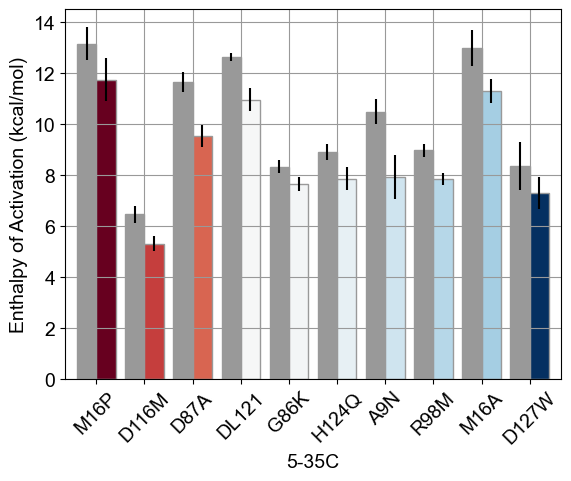

In [18]:
########enthalpy of activation
yerr = energetics_df_all[['dark_enthalpy_std', 'lit_enthalpy_std']].to_numpy().T

#wowzers = np.concatenate((plt.cm.RdBu(offset(color_scale)), plt.cm.RdBu(offset(color_scale))), axis=0)
wowzers = plt.cm.RdBu(offset(color_scale))

#edge_colors = np.where(energetics_df_all.index==dark_enthalpy_mean, 'r', 'w')

#color=(plt.cm.RdBu(offset(np.concatenate((color_scale, color_scale), axis=0)))))

ax = energetics_df_all.plot.bar(x='mutant', y=['dark_enthalpy_mean','lit_enthalpy_mean'],
                                yerr=yerr, 
                                rot = 0, 
                                color={'dark_enthalpy_mean': "#999999", 'lit_enthalpy_mean': wowzers},
                                edgecolor="#999999",#{'dark_enthalpy_mean': "#999999", 'lit_enthalpy_mean': "#0099FF"}
                                legend=False,
                                width=0.8
                                ,)

ax.set_ylabel("Enthalpy of Activation (kcal/mol)")
ax.set_xlabel("5-35C")
ax.set_xticklabels(energetics_df_all['mutant'],rotation=45)
#ax.legend(['Dark', 'Lit'])

if to_plot == 'yes':
    figure_name = ('enthalpy_of_activation.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')

plt.show()


Plots the distance to the active site. This was calculated by any atom's closest distance to the folate in the alphafold homology model. 
Those calculations were done in pymol. The coloring is from the kcat ratio to DL121

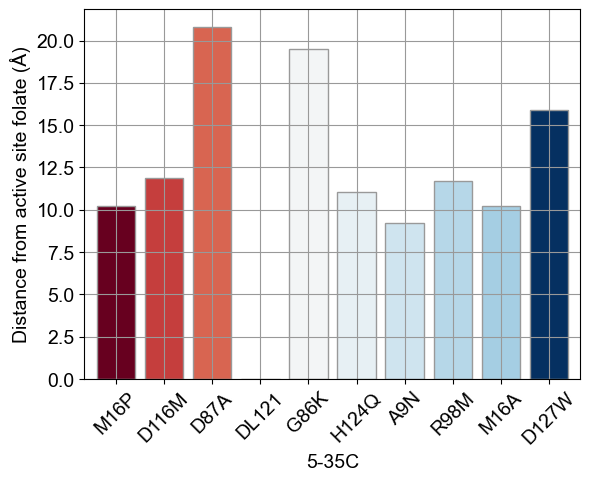

In [16]:
#color by active site distance. (any atom's closest distance to the folate in the homology model)
distance = [10.24,11.87,20.8,0,19.52,11.04,9.24,20.8,10.24,15.88]
########
yerr = energetics_df_all[['dark_enthalpy_std', 'lit_enthalpy_std']].to_numpy().T
wowzers = plt.cm.RdBu(offset(color_scale))

ax = energetics_df_all.plot.bar(x='mutant', y=['fol_distance'],
                                rot = 0, 
                                color={'fol_distance': wowzers},
                                edgecolor="#999999",#{'dark_enthalpy_mean': "#999999", 'lit_enthalpy_mean': "#0099FF"}
                                legend=False,
                                width=0.8
                                ,)#,stacked=True)
ax.set_ylabel("Distance from active site folate (Å)")
ax.set_xlabel("5-35C")
ax.set_xticklabels(energetics_df_all['mutant'],rotation=45)
if to_plot == 'yes':
    figure_name = ('distance_from_active_fol.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')

plt.show()


plot the entropy of activation with error.

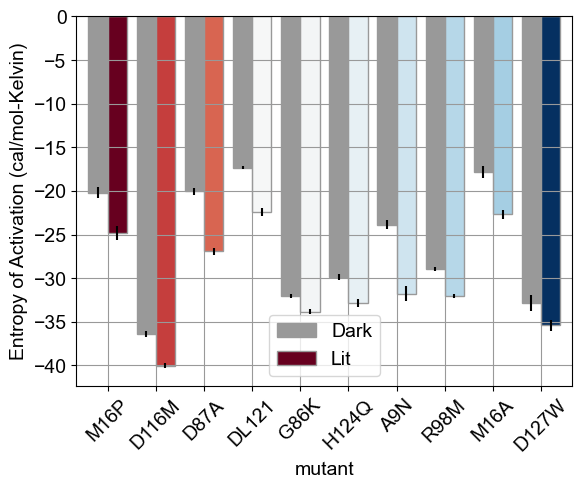

In [18]:

########
yerr = energetics_df_all[['dark_enthalpy_std', 'lit_enthalpy_std']].to_numpy().T

#wowzers = np.concatenate((plt.cm.RdBu(offset(color_scale)), plt.cm.RdBu(offset(color_scale))), axis=0)
wowzers = plt.cm.RdBu(offset(color_scale))

#edge_colors = np.where(energetics_df_all.index==dark_enthalpy_mean, 'r', 'w')

#color=(plt.cm.RdBu(offset(np.concatenate((color_scale, color_scale), axis=0)))))

ax = energetics_df_all.plot.bar(x='mutant', y=['dark_entropy_mean','lit_entropy_mean'],
                                yerr=yerr, 
                                rot = 0, 
                                color={'dark_entropy_mean': "#999999", 'lit_entropy_mean': wowzers},
                                edgecolor="#999999",#{'dark_enthalpy_mean': "#999999", 'lit_enthalpy_mean': "#0099FF"}
                                legend=False,
                                width=0.8
                                ,)#,stacked=True)



####################

ax.set_ylabel("Entropy of Activation (cal/mol-Kelvin)")
#ax.set_xlabel("5-35C")
ax.set_xticklabels(energetics_df_all['mutant'],rotation=45)
ax.legend(['Dark', 'Lit'])

if to_plot == 'yes':
    figure_name = ('entropy_of_activation.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')

plt.show()

Compare the two temperature ranges. 

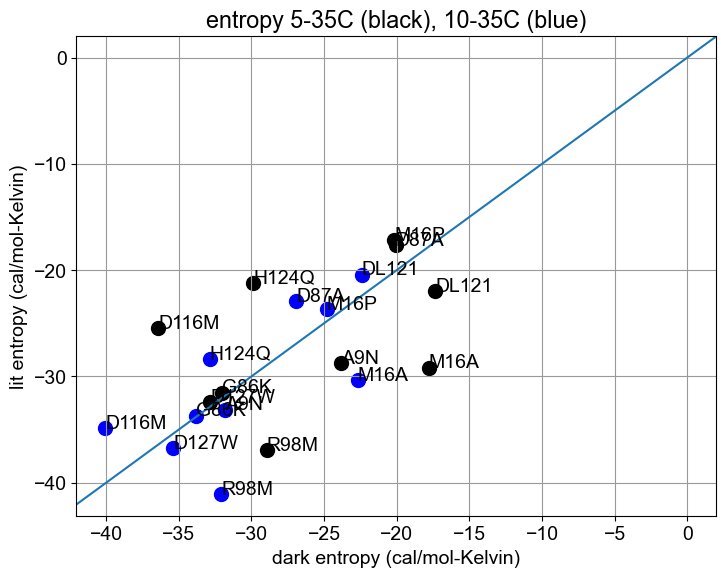

In [19]:
ax = plt
a1 = ax.figure().add_axes([0,0,1,1])
xerr = energetics_df_all[['dark_entropy_std']].to_numpy().T
yerr = energetics_df[['dark_entropy_std']].to_numpy().T
x = energetics_df_all[['dark_entropy_mean']].to_numpy().T
y = energetics_df[['dark_entropy_mean']].to_numpy().T
ax.scatter(x, y, color='black')

x1 = energetics_df_all[['lit_entropy_mean']].to_numpy().T
y1 = energetics_df[['lit_entropy_mean']].to_numpy().T
ax.scatter(x1, y1, color='blue')


ax.axline((0, 0), slope=1)
plt.xlabel('dark entropy (cal/mol-Kelvin)')
plt.ylabel('lit entropy (cal/mol-Kelvin)')
title = ('entropy 5-35C (black), 10-35C (blue)')
plt.title(title)
plt.grid(True)
for i, txt in enumerate(energetics_df_all['mutant']):
    plt.annotate(txt, (x[0][i], y[0][i]))
    
for i, txt in enumerate(energetics_df_all['mutant']):
    plt.annotate(txt, (x1[0][i], y1[0][i]))

plt.show() 

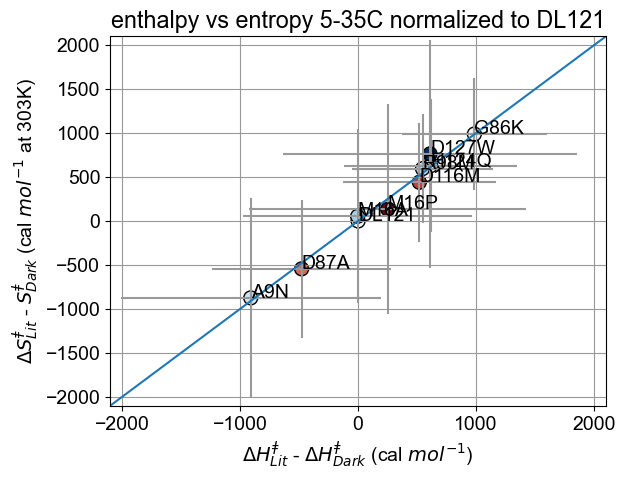

In [20]:
#plot enthalpy vs entropy 5-35C normalized to DL121
x_err = energetics_df_all[['ddelta_enthalpy_std']].to_numpy().T
x = energetics_df_all[['ddelta_enthalpy_mean']].to_numpy().T
y_err = energetics_df_all[['ddelta_entropy_std']].to_numpy().T
y = energetics_df_all[['ddelta_entropy_mean']].to_numpy().T
for i, txt in enumerate(energetics_df_all['mutant']):
    plt.annotate(txt, (x[0][i], y[0][i]))
    plt.errorbar(x[0][i], y[0][i], yerr=y_err[0][i], xerr=x_err[0][i], c="#999999" )
ax = plt
ax.axline((0, 0), slope=1)
ax.ylim(-2100, 2100)
ax.xlim(-2100, 2100)
plt.grid(True)
ax.scatter(x, y, c=color_scale, cmap='RdBu', edgecolors='black', norm=TwoSlopeNorm(0))
plt.xlabel("$ΔH^{ǂ}_{Lit}$ - $ΔH^{ǂ}_{Dark}$ (cal $mol^{-1}$)")
ylabel = ("$ΔS^{ǂ}_{Lit}$ - $S^{ǂ}_{Dark}$ (cal $mol^{-1}$ at " + str(temperature) + "K)")
plt.ylabel(ylabel)
#plt.ylabel('ΔΔEntropy (lit-dark) (cal/mol-Kelvin @ 290.5)')
title = ('enthalpy vs entropy 5-35C normalized to DL121')
plt.title(title)
#plt.colorbar()
if to_plot == 'yes':
    figure_name = ('ddEnthalpy_vs_ddEntropy_5-35C_at30_normalized.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')

plt.show() 

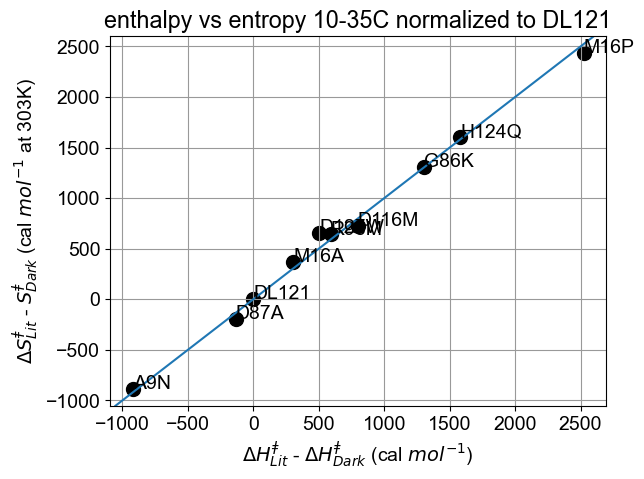

In [21]:
#plot enthalpy vs entropy 10-35C normalized to DL121
d_entropy = np.subtract(energetics_df['lit_entropy_mean'].to_numpy().T\
                        ,energetics_df['dark_entropy_mean'].to_numpy().T)
dd_entropy = np.subtract(d_entropy,d_entropy[0])
dd_entropy = np.multiply(dd_entropy,temperature)
d_enthalpy = np.subtract(energetics_df['lit_enthalpy_mean'].to_numpy().T\
                        ,energetics_df['dark_enthalpy_mean'].to_numpy().T)
dd_enthalpy = np.subtract(d_enthalpy,d_enthalpy[0])
dd_enthalpy = np.multiply(dd_enthalpy,1000)
for i, txt in enumerate(mutant):
    plt.annotate(txt, (dd_enthalpy[i], dd_entropy[i]))
    
ax.axline((0, 0), slope=1)

ax = plt
ax.scatter(dd_enthalpy, dd_entropy, color='black')
plt.xlabel("$ΔH^{ǂ}_{Lit}$ - $ΔH^{ǂ}_{Dark}$ (cal $mol^{-1}$)")
ylabel = ("$ΔS^{ǂ}_{Lit}$ - $S^{ǂ}_{Dark}$ (cal $mol^{-1}$ at " + str(temperature) + "K)")
plt.ylabel(ylabel)
title = ('enthalpy vs entropy 10-35C normalized to DL121')
plt.grid(True)
plt.title(title)
if to_plot == 'yes':
    figure_name = ('ddEnthalpy_vs_ddEntropy_10-35C_at30.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')
plt.show() 

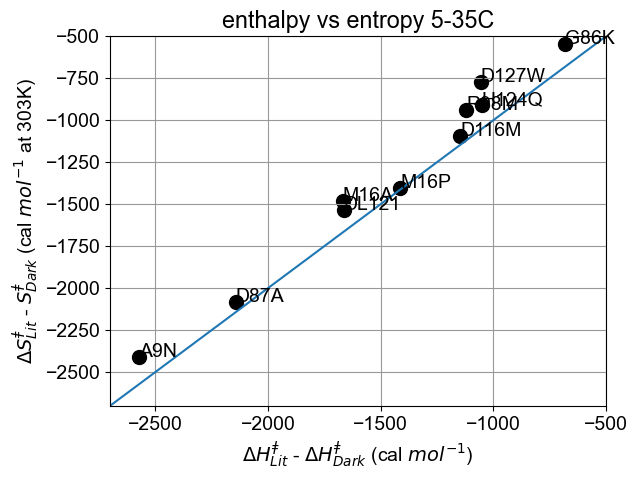

In [22]:
#calculated without bootstrapping

dd_entropy_all = np.subtract(energetics_df_all['lit_entropy_mean'].to_numpy().T\
                        ,energetics_df_all['dark_entropy_mean'].to_numpy().T)
#dd_entropy_all = np.subtract(d_entropy_all,d_entropy_all[0])
dd_entropy_all = np.multiply(dd_entropy_all,temperature)
dd_enthalpy_all = np.subtract(energetics_df_all['lit_enthalpy_mean'].to_numpy().T\
                        ,energetics_df_all['dark_enthalpy_mean'].to_numpy().T)
#dd_enthalpy_all = np.subtract(d_enthalpy_all,d_enthalpy_all[0])
dd_enthalpy_all = np.multiply(dd_enthalpy_all,1000)

for i, txt in enumerate(energetics_df_all['mutant']):
    plt.annotate(txt, (dd_enthalpy_all[i], dd_entropy_all[i]))
ax = plt
ax.axline((-1500, -1500), slope=1)
ax.ylim(-2700, -500)
ax.xlim(-2700, -500)
plt.grid(True)
ax.scatter(dd_enthalpy_all, dd_entropy_all, color='black')
#$cm^{2}$ $dmol^{-1}$
plt.xlabel("$ΔH^{ǂ}_{Lit}$ - $ΔH^{ǂ}_{Dark}$ (cal $mol^{-1}$)")
#plt.xlabel('ΔΔEnthalpy of Activation (lit-dark) (cal/mol)')
ylabel = ("$ΔS^{ǂ}_{Lit}$ - $S^{ǂ}_{Dark}$ (cal $mol^{-1}$ at " + str(temperature) + "K)")
#ylabel = ('ΔΔEntropy (lit-dark) (cal/mol-Kelvin @ ' + str(temperature) + ')')
plt.ylabel(ylabel)
#plt.ylabel('ΔΔEntropy (lit-dark) (cal/mol-Kelvin @ 290.5)')
title = ('enthalpy vs entropy 5-35C')
plt.title(title)
if to_plot == 'yes':
    figure_name = ('ddEnthalpy_vs_ddEntropy_5-35C_at30_notNormalized.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')

plt.show() 

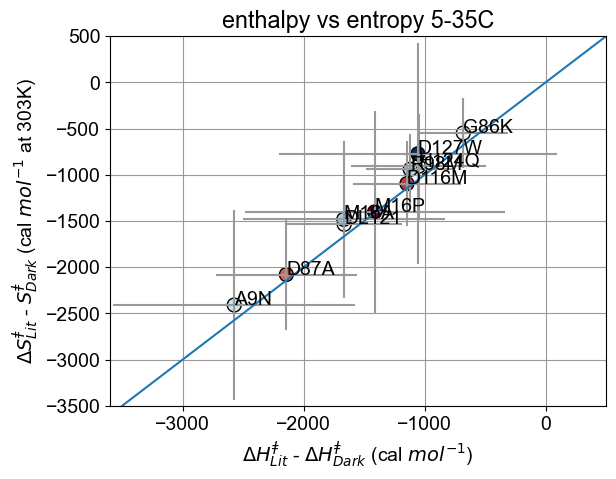

In [23]:
#calculated from bootstrapping

x_err = energetics_df_all[['delta_enthalpy_std']].to_numpy().T
x = energetics_df_all[['delta_enthalpy_mean']].to_numpy().T
y_err = energetics_df_all[['delta_entropy_std']].to_numpy().T
y = energetics_df_all[['delta_entropy_mean']].to_numpy().T
for i, txt in enumerate(energetics_df_all['mutant']):
    #plt.annotate(txt, (dd_enthalpy_all[i], dd_entropy_all[i]))
    plt.annotate(txt, (x[0][i], y[0][i]))
    plt.errorbar(x[0][i], y[0][i], yerr=y_err[0][i], xerr=x_err[0][i], c="#999999" )
ax = plt
ax.axline((0, 0), slope=1)
ax.ylim(-3500, 500)
ax.xlim(-3600, 500)
plt.grid(True)
#plt.errorbar(x, y, yerr=y_err, xerr=x_err, c="#999999" )
#ax.scatter(dd_enthalpy_all, dd_entropy_all, c="#0099FF" , edgecolors='black')
ax.scatter(x, y, c=color_scale, cmap='RdBu', edgecolors='black', norm=TwoSlopeNorm(0))
plt.xlabel("$ΔH^{ǂ}_{Lit}$ - $ΔH^{ǂ}_{Dark}$ (cal $mol^{-1}$)")
ylabel = ("$ΔS^{ǂ}_{Lit}$ - $S^{ǂ}_{Dark}$ (cal $mol^{-1}$ at " + str(temperature) + "K)")
plt.ylabel(ylabel)
#plt.ylabel('ΔΔEntropy (lit-dark) (cal/mol-Kelvin @ 290.5)')
title = ('enthalpy vs entropy 5-35C')
plt.title(title)
#plt.colorbar()
if to_plot == 'yes':
    figure_name = ('ddEnthalpy_vs_ddEntropy_5-35C_at30.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')

plt.show() 


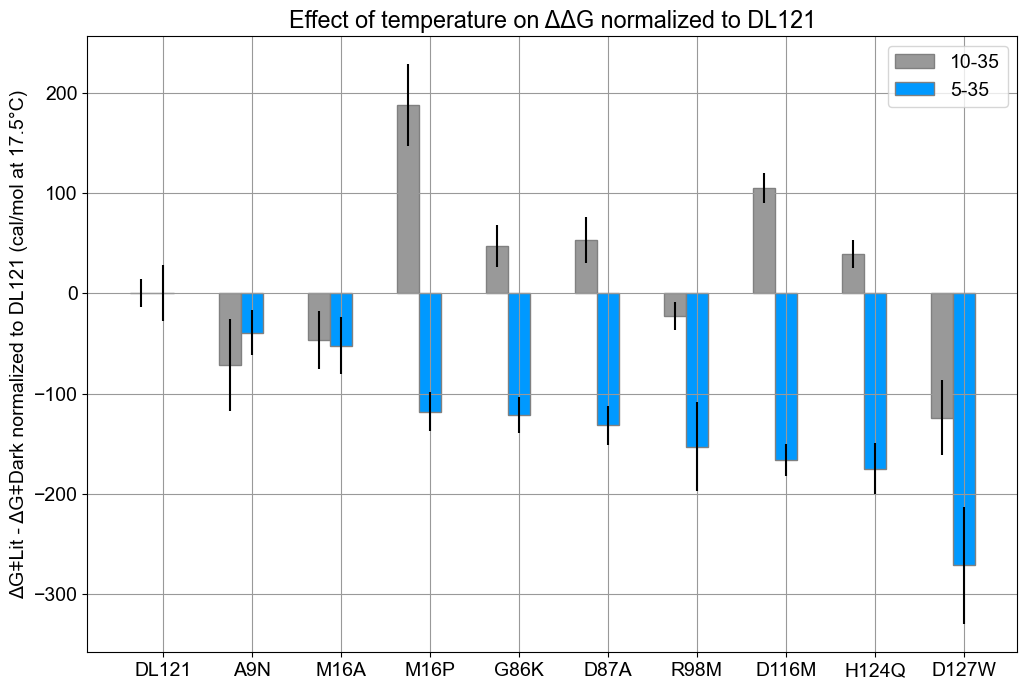

In [24]:
#goal is to compare the effect of slicing temperature on allostery. 
dd_G = np.subtract(energetics_df['ddelta_G_mean'],energetics_df['ddelta_G_mean'][0])
dd_G_all = np.subtract(energetics_df_all['ddelta_G_mean'],energetics_df_all['ddelta_G_mean'][0])
fig = plt.subplots(figsize =(12, 8)) 
barWidth = 0.25
br1 = np.arange(len(dd_G)) 
br2 = [x + barWidth for x in br1] 

yerr = energetics_df[['ddelta_G_std']].to_numpy().T
yerr_all = energetics_df_all[['ddelta_G_std']].to_numpy().T
plt.bar(br1, dd_G, yerr=yerr, edgecolor ='grey', label ='10-35',width = barWidth,color ="#999999")
plt.bar(br2, dd_G_all, yerr=yerr_all, edgecolor ='grey', label ='5-35',width = barWidth,color ="#0099FF")       

plt.xticks([r + barWidth for r in range(len(dd_G))], 
       mutant)   
plt.legend()
#plt.xlabel('ΔGǂLit - ΔGǂDark (kcal/mol at 17.5°C)')
plt.ylabel('ΔGǂLit - ΔGǂDark normalized to DL121 (cal/mol at 17.5°C)')
title = ('Effect of temperature on ΔΔG normalized to DL121')
plt.title(title)
if to_plot == 'yes':
    figure_name = ('Effect_of_temperature_slice_on_ΔΔG.pdf')
    #plt.savefig('./output/%s' % figure_name, bbox_inches='tight')
plt.show()

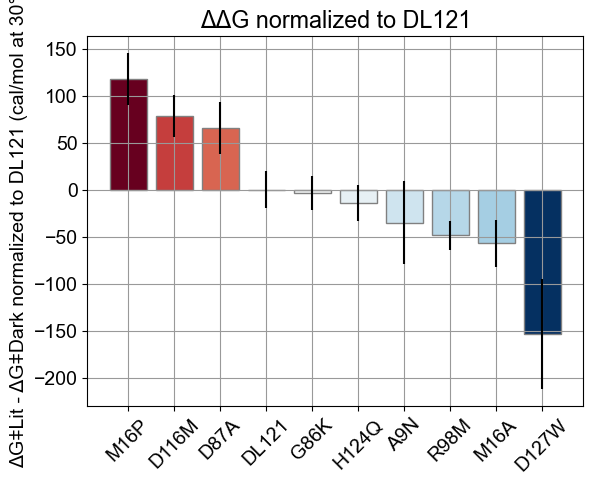

In [27]:
#goal is to compare the effect of slicing temperature on allostery. TLDR some, but not consistant. Probably best to leave as is. 
#dd_G_all = np.subtract(energetics_df_all['ddelta_G_mean'],energetics_df_all['ddelta_G_mean'][5])#17.5C
dd_G_all = np.subtract(energetics_df_all['ddelta_G_mean'],energetics_df_all['ddelta_G_mean'][3])#30C
barWidth = 0.25
br1 = np.arange(len(dd_G_all)) 
yerr_all = energetics_df_all[['ddelta_G_std']].to_numpy().T
plt.bar(br1, dd_G_all, yerr=yerr_all, edgecolor ='grey',width = 0.8,color =wowzers) 

br1 = np.arange(len(dd_G_all)) 
br2 = [x + barWidth for x in br1] 
#plt.xticks(energetics_df_all['mutant'])
#plt.xticks(labels=energetics_df_all['mutant'])   
plt.xticks([r for r in range(len(dd_G_all))], 
       energetics_df_all['mutant'],rotation=45)   




#plt.legend()
#plt.xlabel('ΔGǂLit - ΔGǂDark (kcal/mol at 17.5°C)')
#plt.set_xticklabels(energetics_df_all['mutant'],rotation=45)
plt.ylabel('ΔGǂLit - ΔGǂDark normalized to DL121 (cal/mol at 30°C)')
title = ('ΔΔG normalized to DL121')
plt.title(title)
to_plot = "no"
if to_plot == 'yes':
    figure_name = ('ddG.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')
plt.show()

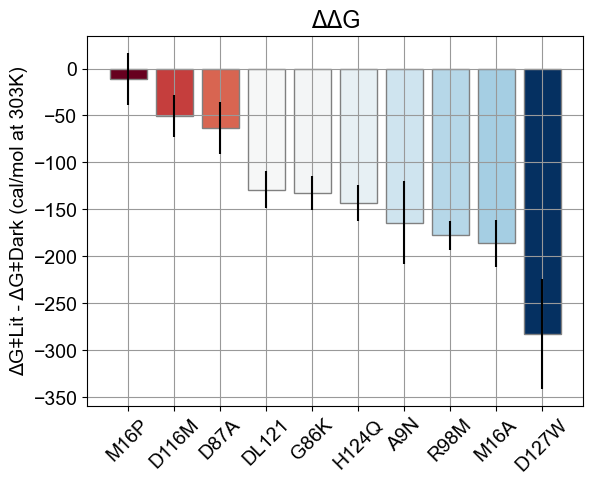

In [28]:
#goal is to compare the effect of slicing temperature on allostery. TLDR some, but not consistant. Probably best to leave as is. 
#dd_G_all = np.subtract(energetics_df_all['ddelta_G_mean'],energetics_df_all['ddelta_G_mean'][5])#17.5C
#dd_G_all = np.subtract(energetics_df_all['ddelta_G_mean'],energetics_df_all['ddelta_G_mean'][3])#30C
barWidth = 0.25
br1 = np.arange(len(energetics_df_all['ddelta_G_mean'])) 
yerr_all = energetics_df_all[['ddelta_G_std']].to_numpy().T
plt.bar(br1, energetics_df_all['ddelta_G_mean'], yerr=yerr_all, edgecolor ='grey',width = 0.8,color =wowzers) 

br1 = np.arange(len(dd_G_all)) 
br2 = [x + barWidth for x in br1] 
#plt.xticks(energetics_df_all['mutant'])
#plt.xticks(labels=energetics_df_all['mutant'])   
plt.xticks([r for r in range(len(dd_G_all))], 
       energetics_df_all['mutant'],rotation=45)   




#plt.legend()
#plt.xlabel('ΔGǂLit - ΔGǂDark (kcal/mol at 17.5°C)')
#plt.set_xticklabels(energetics_df_all['mutant'],rotation=45)
plt.ylabel('ΔGǂLit - ΔGǂDark (cal/mol at 303K)')
title = ('ΔΔG')
plt.title(title)
to_plot = "no"
if to_plot == 'yes':
    figure_name = ('ddG_unnormalized_303K.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')
plt.show()

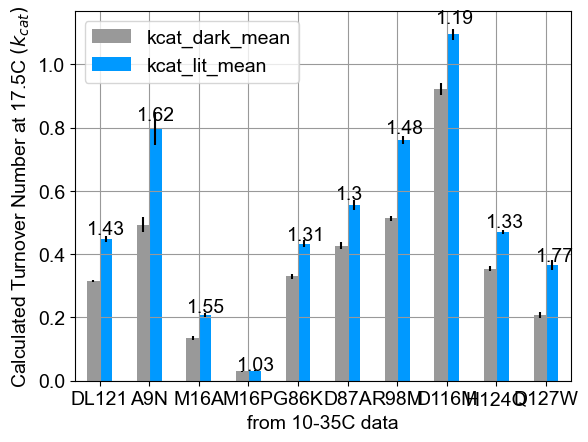

In [30]:
yerr = energetics_df[['kcat_dark_std', 'kcat_lit_std']].to_numpy().T

ax = energetics_df.plot.bar(x='mutant', y=['kcat_dark_mean','kcat_lit_mean']\
                            ,yerr=yerr, rot = 0, color=["#999999","#0099FF"])

ax.set_ylabel("Calculated Turnover Number at 17.5C $(k_{cat})$")
ax.set_xlabel("from 10-35C data")

kcat_ratio = np.divide(energetics_df['kcat_lit_mean'].to_numpy().T\
                        ,energetics_df['kcat_dark_mean'].to_numpy().T)
kcat_ratio = np.around(kcat_ratio, decimals=2, out=None)

#this section allows me to put the ratio on the plot above the bar. 
i=0
for p in ax.patches:
    ax.annotate(kcat_ratio[i], (p.get_x() * 1.005, p.get_height() * 1.03 * kcat_ratio[i]))
    i=i+1
    if i == len(mutant):
        break

plt.show()


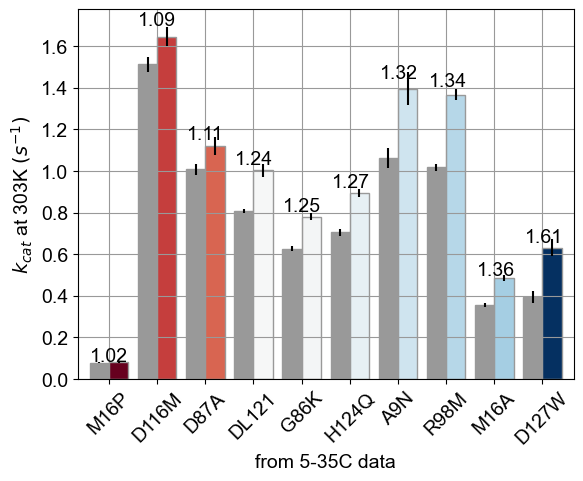

In [31]:
#from 5-35C data#
########
yerr = energetics_df_all[['kcat_dark_std', 'kcat_lit_std']].to_numpy().T

#wowzers = np.concatenate((plt.cm.RdBu(offset(color_scale)), plt.cm.RdBu(offset(color_scale))), axis=0)
wowzers = plt.cm.RdBu(offset(color_scale))


ax = energetics_df_all.plot.bar(x='mutant', y=['kcat_dark_mean','kcat_lit_mean'],
                                yerr=yerr, 
                                rot = 0, 
                                color={'kcat_dark_mean': "#999999", 'kcat_lit_mean': wowzers},
                                edgecolor="#999999",#{'dark_enthalpy_mean': "#999999", 'lit_enthalpy_mean': "#0099FF"}
                                legend=False,
                                width=0.8
                                
                                ,)#,stacked=True)
########Add hatches######
bars = ax.patches
hatches = '//////////'#10 hatches for first 10 bars. 
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
######################

####Ratio above the numbers
kcat_ratio_all = np.around(energetics_df_all['kcat_ratio_mean'], decimals=2, out=None)

i=0
for p in ax.patches:
    ax.annotate(kcat_ratio_all[i], (p.get_x() * 1.005, p.get_height() * 1.03 * kcat_ratio_all[i]))
    i=i+1
    if i == len(energetics_df_all['mutant']):
        break

#######


ax.set_ylabel("$k_{cat}$ at 303K $(s^{-1})$")
ax.set_xlabel("from 5-35C data")

ax.set_xticklabels(energetics_df_all['mutant'],rotation=45)
#ax.legend(['Dark', 'Lit'])
to_plot = 'no'
if to_plot == 'yes':
    figure_name = ('kcat_back-calculate.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')

plt.show()

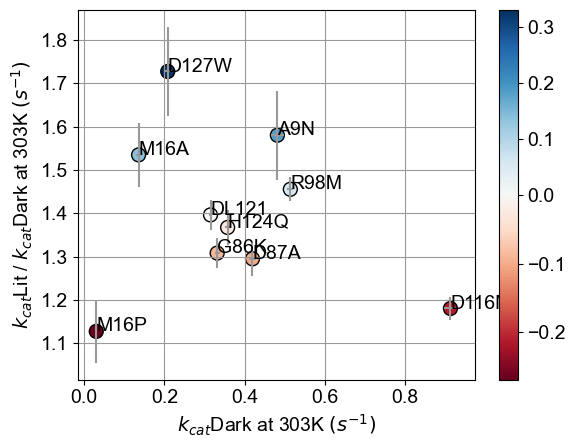

In [79]:
#calculated from bootstrapping

x_err = energetics_df_all[['kcat_dark_std']].to_numpy().T
x = energetics_df_all[['kcat_dark_mean']].to_numpy().T
y_err = energetics_df_all[['kcat_ratio_std']].to_numpy().T
y = energetics_df_all[['kcat_ratio_mean']].to_numpy().T
for i, txt in enumerate(energetics_df_all['mutant']):

    plt.annotate(txt, (x[0][i], y[0][i]))
    plt.errorbar(x[0][i], y[0][i], yerr=y_err[0][i], xerr=x_err[0][i], c="#999999" )
ax = plt
plt.grid(True)
ax.scatter(x, y, c=color_scale, cmap='RdBu', edgecolors='black', norm=TwoSlopeNorm(0))
plt.xlabel("$k_{cat}$Dark at 303K $(s^{-1})$")
ylabel = ("$k_{cat}$Lit / $k_{cat}$Dark at 303K $(s^{-1})$")
plt.ylabel(ylabel)
#plt.ylabel('ΔΔEntropy (lit-dark) (cal/mol-Kelvin @ 290.5)')
#title = ('enthalpy vs entropy 5-35C')
#plt.title(title)
plt.colorbar()

if to_plot == 'yes':
    figure_name = ('kcat_ratio_vs_kcat_dark.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')

plt.show() 